In [2]:
import pandas as pd
from scripts.aux_msa_functions import *
from scipy.spatial.distance import cdist
import os
import numpy as np
import torch
from Bio import Phylo
import seaborn as sns
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import re
from scipy.stats import pearsonr
from math import floor,ceil
from scipy import stats
from ete3 import Tree

torch.set_grad_enabled(False)

In [4]:
deletekeys = dict.fromkeys(string.ascii_lowercase)
deletekeys["."] = None
deletekeys["*"] = None
translation = str.maketrans(deletekeys)

def read_sequence(filename: str) -> Tuple[str, str]:
    """ Reads the first (reference) sequences from a fasta or MSA file."""
    record = next(SeqIO.parse(filename, "fasta"))
    return record.description, str(record.seq)

def remove_insertions(sequence: str) -> str:
    """ Removes any insertions into the sequence. Needed to load aligned sequences in an MSA. """
    return sequence.translate(translation)

def read_msa(filename: str) -> List[Tuple[str, str]]:
    """ Reads the sequences from an MSA file, automatically removes insertions."""
    return [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(filename, "fasta")]

def greedy_select(msa: List[Tuple[str, str]], num_seqs: int, mode: str = "max") -> List[Tuple[str, str]]:
    assert mode in ("max", "min")
    if len(msa) <= num_seqs:
        return msa
    
    array = np.array([list(seq) for _, seq in msa], dtype=np.bytes_).view(np.uint8)

    optfunc = np.argmax if mode == "max" else np.argmin
    all_indices = np.arange(len(msa))
    indices = [0]
    pairwise_distances = np.zeros((0, len(msa)))
    for _ in range(num_seqs - 1):
        dist = cdist(array[indices[-1:]], array, "hamming")
        pairwise_distances = np.concatenate([pairwise_distances, dist])
        shifted_distance = np.delete(pairwise_distances, indices, axis=1).mean(0)
        shifted_index = optfunc(shifted_distance)
        index = np.delete(all_indices, indices)[shifted_index]
        indices.append(index)
    indices = sorted(indices)
    return [msa[idx] for idx in indices]

def Seq_tuples_to_fasta(sequences, file_path, export_type = "fasta"):
    MSA_SeqRecords = [SeqRecord(Seq(record[1]), id = record[0], name= record[0], description= record[0]) for record in sequences]
    with open(f"{file_path}", "w") as output_handle:
        SeqIO.write(MSA_SeqRecords, output_handle, export_type)

In [15]:
tree = Tree("./data/seed-trees/PF00004_seed.newick")

leaf_names_1 = tree.get_leaves()
leaf_names_2 = []

for node in tree.traverse("levelorder"):
    if node.is_leaf():
        leaf_names_2.append(node.name)

In [3]:
def read_stockholm_preserve_dots(filename):
    records = []
    with open(filename) as fh:
        for line in fh:
            if line.startswith("#") or not line.strip():
                continue
            if line.startswith("//"):
                break
            parts = line.strip().split()
            if len(parts) == 2:
                seq_id, seq = parts
                records.append((seq_id, remove_insertions(seq)))
    return records

fams = ["PF00001"]

for fam in fams:

    msa = read_stockholm_preserve_dots(f"./pfam_full_msas/stockholm/{fam}_full.sth")
    Seq_tuples_to_fasta(msa, f"{fam}_full.fasta")



FileNotFoundError: [Errno 2] No such file or directory: './pfam_full_msas/stockholm/PF00001_full.sth'

In [70]:


fams = ["PF01356","PF03440","PF04008","PF06351","PF06355","PF16747","PF18648"]
lengths = [68,87,154,175,131,125,155]

for a, fam in enumerate(fams):

    L = lengths[a]

    h = np.zeros((L,21))
    J = np.zeros((L,L,21,21))

    folder = f"./data/protein-families-DCA-params/{fam}_full_no_gapped"
    files = os.listdir(folder)

    for file in files:

        if re.match(r"parameters_[0-9]+.txt", file):

            file_path = os.path.join(folder, file)

            with open(file_path, 'r') as f:
                    for line in f:
                        if line.strip():
                            parts = line.strip().split()
                            if parts[0] == "h":
                                i = int(parts[1])
                                j = int(parts[2])
                                h[i][j] = float(parts[3])
                            else:
                                i = int(parts[1])
                                j = int(parts[2])
                                k = int(parts[3])
                                l = int(parts[4])
                                J[i][j][k][l] =  float(parts[5])   

            np.save(f"./data/protein-families-DCA-params/{fam}_h.npy", h) 
            np.save(f"./data/protein-families-DCA-params/{fam}_J.npy", J)            
                     
                    

In [23]:
x = np.load("./data/protein-families-DCA-params/PF00004_h.npy")

## Phylogeny Scores

In [11]:
phylogeny = True
include_nat = False

large_families = ["PF00004","PF00005","PF00041","PF00072","PF00076","PF00096","PF00153",
                  "PF00271","PF00397","PF00512","PF00595","PF01535","PF07679","PF02518"]

small_families = ["PF01356","PF03440","PF04008","PF06351","PF06355","PF16747","PF18648","PF13354"]

protein_families = large_families
models_list = ["MSA-1b", "ESM2-33T-650M","ESMC","Potts"]
init_seqs = ["0"]
proposal_types = ["logits"]
context_types = ["static"]
context_sizes = ["10"]
context_sampling_methods = ["random"]

scores_folders_common_path = "./scores/msa-seed-simulations/"
msas_folders_common_path = "./data/msa-seed-simulations/"
tree_scores_folders_common_path = "./scores/msa-seed-sim-trees/"

scores_folders = []
msas_folders = []
tree_scores_folders = []

max_nat_hmmer_score = {}
mean_stat_energy_score = {}
std_stat_energy_score = {}

tool_types = []
model_order = []
proposal_order = []
context_type_order = []
context_sampling_order = []
context_size_order = []
init_seq_order = []
n_mutations_order = []

for model in models_list:
    
  scores_path_model = scores_folders_common_path + f"{model}/"

  if not os.path.exists(scores_path_model):
    continue

  msas_path_model = msas_folders_common_path + f"{model}/"
  tree_scores_path_model = tree_scores_folders_common_path + f"{model}/"

  for family in protein_families:
                    
    scores_path_fam = scores_path_model + f"{family}/"

    if not os.path.exists(scores_path_fam):
      continue

    msas_path_fam = msas_path_model + f"{family}/"
    tree_scores_path_fam = tree_scores_path_model + f"{family}/"

    for init_seq in init_seqs:

      scores_path_init = scores_path_fam + f"init-seq-{init_seq}/"

      if not os.path.exists(scores_path_init):
        continue

      msas_path_init = msas_path_fam + f"init-seq-{init_seq}/"
      tree_scores_path_init = tree_scores_path_fam + f"init-seq-{init_seq}/"

      if model in ["Potts"]:

        scores_folders.append(scores_path_init)
        msas_folders.append(msas_path_init)
        tree_scores_folders.append(tree_scores_path_init)

        tool_type = f"{model}"
        tool_types.append(tool_type) 
        model_order.append(model)
        proposal_order.append(None)
        context_type_order.append(None)
        context_sampling_order.append(None)
        context_size_order.append(None)
        init_seq_order.append(init_seq) 
        n_mutations_order.append(None)

        continue      

      for proposal in proposal_types:
        
        scores_path_proposal = scores_path_init + f"{proposal}-proposal/"


        if not os.path.exists(scores_path_proposal):        
          continue

        msas_path_proposal = msas_path_init + f"{proposal}-proposal/"
        tree_scores_path_proposal = tree_scores_path_init + f"{proposal}-proposal/"

        if model in ["ESM2-33T-650M","ESMC"]:

          scores_folders.append(scores_path_proposal)
          msas_folders.append(msas_path_proposal)
          tree_scores_folders.append(tree_scores_path_proposal)

          tool_type = f"{model}-{proposal}"
          tool_types.append(tool_type) 
          model_order.append(model.split("-")[0])
          proposal_order.append(proposal)
          context_type_order.append(None)
          context_sampling_order.append(None)
          context_size_order.append(None)
          init_seq_order.append(init_seq)
          n_mutations_order.append(None)

          continue       

        for context in context_types:
            
          scores_path_context = scores_path_proposal + f"{context}-context/"

          if not os.path.exists(scores_path_context):
            continue

          msas_path_context = msas_path_proposal + f"{context}-context/"
          tree_scores_path_context = tree_scores_path_proposal + f"{context}-context/"

          for context_size in context_sizes:
              
            scores_path_size = scores_path_context + f"{context_size}/"

            if not os.path.exists(scores_path_size):
              continue

            msas_path_size = msas_path_context + f"{context_size}/"
            tree_scores_path_size = tree_scores_path_context + f"{context_size}/"

            if init_seq == "-1":
              init_seq_dummy = "random"
            else:
              init_seq_dummy = init_seq

            if context == "dynamic":
                
              for context_sampling_method in context_sampling_methods:
                    
                scores_path_sampling = scores_path_size + f"{context_sampling_method}/"

                if not os.path.exists(scores_path_sampling):
                  continue

                msas_path_sampling = msas_path_size + f"{context_sampling_method}/"
                tree_scores_path_sampling = tree_scores_path_size + f"{context_sampling_method}/"

                scores_folders.append(scores_path_sampling)
                msas_folders.append(msas_path_sampling)
                tree_scores_folders.append(tree_scores_path_sampling)

                tool_type = f"{model}_{proposal}_{context}_{context_sampling_method}_{context_size}_init-seq-{init_seq_dummy}"
                tool_types.append(tool_type)
                model_order.append(model.split("-")[0])
                proposal_order.append(proposal.capitalize())
                context_type_order.append(f"{context} {context_sampling_method}".capitalize())
                context_sampling_order.append(context_sampling_method.capitalize())
                context_size_order.append(context_size)
                init_seq_order.append(init_seq_dummy.capitalize())
                n_mutations_order.append(None)

            elif context == "static":
               
              scores_folders.append(scores_path_size)
              msas_folders.append(msas_path_size)
              tree_scores_folders.append(tree_scores_path_size)
              
              tool_type = f"{model}_{proposal}_{context}_{context_size}_init-seq-{init_seq_dummy}"
              tool_types.append(tool_type)
              model_order.append(model.split("-")[0])
              proposal_order.append(proposal.capitalize())
              context_type_order.append(context.capitalize())
              context_sampling_order.append(None)
              context_size_order.append(context_size)
              init_seq_order.append(init_seq_dummy.capitalize())
              n_mutations_order.append(None)
              

if include_nat:

  for family in protein_families:
    nat_scores_path = f"./scores/protein-families-msa-seed/{family}/" 
    scores_folders.append(nat_scores_path)

    scores = pd.read_csv(os.path.join(nat_scores_path, f"{family}_seed.tsv"), delimiter = "\t")
    max_nat_hmmer_score[family] = scores["hmmer_seq_score"].max()
    try:
      mean_stat_energy_score[family] = scores["stat_energy_scores"].mean()
      std_stat_energy_score[family] = scores["stat_energy_scores"].std()
    except:
      pass

    nat_msas_path = f"./data/protein-families-msa-seed/{family}/"
    msas_folders.append(nat_msas_path)
   
    tool_type = f"nat"
    tool_types.append(tool_type) 
    model_order.append("Natural")
    proposal_order.append(None)
    context_type_order.append(None)
    context_sampling_order.append(None)
    context_size_order.append(None)
    init_seq_order.append(None)
    n_mutations_order.append(None)

    bootstrap_nat_path = f"./scores/sequences-bootstrap-seed-msa/{family}/"
    scores_folders.append(bootstrap_nat_path)

    tool_type = f"nat-bootstrap"
    tool_types.append(tool_type) 
    model_order.append("Natural")
    proposal_order.append(None)
    context_type_order.append(None)
    context_sampling_order.append(None)
    context_size_order.append(None)
    init_seq_order.append(None)
    n_mutations_order.append(None)

    

tree_path = f"./data/seed-trees/{family}_seed.newick"
tree = Phylo.read(tree_path,"newick")
tree.root_at_midpoint()

## No phylogeny scores 

In [46]:
phylogeny = False
include_nat = True

protein_families = ["PF00004"]
n_sequences_list = ["50"]
n_mutations_list = ["500","1000"]
models_list = ["MSA-1b"]
init_seqs = ["0"]
proposal_types = ["logits", "random"]
context_sizes = ["10"]

scores_folders_common_path = "./scores/no-phylogeny/"
msas_folders_common_path = "./data/no-phylogeny/"

scores_folders = []
tool_types = []
msas_folders = []

max_nat_hmmer_score = {}
mean_stat_energy_score = {}
std_stat_energy_score = {}

model_order = []
proposal_order = []
context_type_order = []
context_sampling_order = []
context_size_order = []
init_seq_order = []
n_mutations_order = []

for n_mutations in n_mutations_list:

  scores_path_mutations = scores_folders_common_path + f"{n_mutations}-mutations/"
  msas_path_mutations = msas_folders_common_path + f"{n_mutations}-mutations/"

  for n_sequences in n_sequences_list:

    scores_path_sequences = scores_path_mutations + f"{n_sequences}-sequences/msa-seed-simulations/"
    msas_path_sequences = msas_path_mutations + f"{n_sequences}-sequences/msa-seed-simulations/"

    for model in models_list:
        
      scores_path_model = scores_path_sequences + f"{model}/"

      if not os.path.exists(scores_path_model):
        continue
      
      msas_path_model = msas_path_sequences + f"{model}/"

      for family in protein_families:
                    
        scores_path_fam = scores_path_model + f"{family}/"

        if not os.path.exists(scores_path_fam):
          continue

        msas_path_final = msas_path_model + f"{family}/"

        for init_seq in init_seqs:

          scores_path_init = scores_path_fam + f"init-seq-{init_seq}/"

          if not os.path.exists(scores_path_init):
            continue

          msas_path_init = msas_path_model + f"init-seq-{init_seq}/"

          if model in ["Potts"]:

            scores_folders.append(scores_path_init)
            msas_folders.append(msas_path_init)

            tool_type = f"{model}"
            tool_types.append(tool_type)  

            continue

          for proposal in proposal_types:
        
            scores_path_proposal = scores_path_init + f"{proposal}-proposal/"

            if not os.path.exists(scores_path_proposal):
              continue

            msas_path_proposal = msas_path_init + f"{proposal}-proposal/"

            if model in ["ESM2-33T-650M"]:

              scores_folders.append(scores_path_proposal)
              msas_folders.append(msas_path_proposal)

              tool_type = f"{model}-{proposal}prop"
              tool_types.append(tool_type)
              model_order.append(model)
              proposal_order.append(proposal.capitalize())
              context_type_order.append(None)
              context_sampling_order.append(None)
              context_size_order.append(context_size)
              init_seq_order.append(init_seq_dummy.capitalize())
              n_mutations_order.append(n_mutations)

              continue

            for context_size in context_sizes:
              
              scores_path_size = scores_path_proposal + f"context-size-{context_size}/"

              if not os.path.exists(scores_path_size):
                continue

              msas_path_size = msas_path_proposal + f"context-size-{context_size}/"

              scores_folders.append(scores_path_size)
              msas_folders.append(msas_path_size)

              if init_seq == "-1":
                init_seq_dummy = "random"
              else:
                init_seq_dummy = init_seq
              
              tool_type = f"{model}-{proposal}prop-no-phylogeny-size-{context_size}-muts-{n_mutations}-init-seq-{init_seq_dummy}"
              tool_types.append(tool_type)
              model_order.append(model)
              proposal_order.append(proposal.capitalize())
              context_type_order.append(None)
              context_sampling_order.append(None)
              context_size_order.append(context_size)
              init_seq_order.append(init_seq_dummy.capitalize())
              n_mutations_order.append(n_mutations)


if include_nat:

  for family in protein_families:
    nat_scores_path = f"./scores/protein-families-msa-seed/{family}/" 
    scores_folders.append(nat_scores_path)

    scores = pd.read_csv(os.path.join(nat_scores_path, f"{family}_seed.tsv"), delimiter = "\t")
    max_nat_hmmer_score[family] = scores["hmmer_seq_score"].max()
    try:
      mean_stat_energy_score[family] = scores["stat_energy_scores"].mean()
      std_stat_energy_score[family] = scores["stat_energy_scores"].std()
    except:
      pass

    nat_msas_path = f"./data/protein-families-msa-seed/{family}/"
    msas_folders.append(nat_msas_path)
   
    tool_type = f"nat"
    tool_types.append(tool_type) 
    model_order.append("Natural")
    proposal_order.append(proposal.capitalize())
    context_type_order.append(None)
    context_sampling_order.append(None)
    context_size_order.append(context_size)
    init_seq_order.append(init_seq_dummy.capitalize()) 
    n_mutations_order.append(None)      


## Comparing simulated and natural hamming distances

In [4]:
corr_1 = pd.read_csv("./other-analyses/hamming_dist_correlations/mean_correlations_all_methods_all_fams_seq_0.tsv", delimiter = "\t")
corr_2 = pd.read_csv("./other-analyses/hamming_dist_correlations/mean_correlations_all_methods_all_fams_seq_10.tsv", delimiter = "\t")
mean_corr_all_dist = pd.read_csv("./other-analyses/hamming_dist_correlations/mean_correlations_all_distance_measures.tsv", delimiter = "\t")

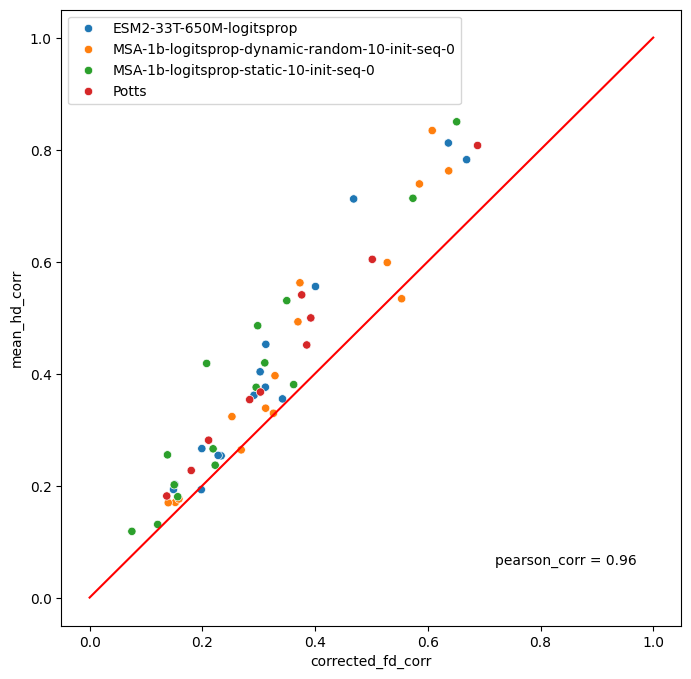

In [38]:
rcParams["figure.figsize"] = 8,8

axes = plt.gca()
sns.scatterplot(x="corrected_fd_corr", y="mean_hd_corr", data = mean_corr_all_dist, hue="tool", ax=axes)
pearson_corr = pearsonr(mean_corr_all_dist["corrected_fd_corr"], mean_corr_all_dist["mean_hd_corr"])
axes.annotate(f"pearson_corr = {pearson_corr.statistic:.2f}",xy = (0.7,0.1), xycoords = "axes fraction")
axes.plot([0,1],[0,1],'r-')

plt.legend(loc = 'best')

plt.savefig("corrected_fd_corr_vs_hd_corr.png")

In [42]:
hd_dataframe = pd.DataFrame(columns=["tool","sim_ind","ham_dist_sim","ham_dist_corr_nat"])
sim_ind = 4

for j,folder in enumerate(scores_folders):
        
    for i,file in enumerate(os.listdir(folder)):

        if not tool_types[j].startswith("nat"):
            file_sim_ind = file.split('.')[0]
            file_sim_ind = int(file_sim_ind.split('-')[1])
        else:
            file_sim_ind = sim_ind

        # if file_sim_ind != sim_ind:
        #     continue
            
        file_path = os.path.join(folder,file)
        dist_dataframe = pd.DataFrame()
        
        df = pd.read_csv(file_path, delimiter="\t") 
        
        num_sim_array = np.array([list(seq) for seq in df["sequence"]], dtype=np.bytes_).view(np.uint8)
        
        distance_matrix_sim = cdist(num_sim_array,num_sim_array, "hamming")
        pairwise_distances_sim = distance_matrix_sim[np.triu_indices_from(distance_matrix_sim, k=1)]

        num_nat_array = np.array([list(seq) for seq in df["corr_nat_seq"]], dtype=np.bytes_).view(np.uint8)
        
        distance_matrix_nat = cdist(num_nat_array,num_nat_array, "hamming")
        pairwise_distances_nat = distance_matrix_nat[np.triu_indices_from(distance_matrix_nat, k=1)]

        dist_dataframe["ham_dist_sim"] = list(pairwise_distances_sim)
        dist_dataframe["ham_dist_corr_nat"] = list(pairwise_distances_nat)
        dist_dataframe["tool"] = tool_types[j]
        dist_dataframe["sim_ind"] = file_sim_ind
        dist_dataframe["family"] = re.findall("PF[0-9]{5}",folder)[0]

        hd_dataframe = pd.concat((hd_dataframe, dist_dataframe)).reset_index(drop=True)

In [ ]:
hd_corr_table = []
for tool in list(hd_dataframe["tool"].unique()):

    if tool.startswith("nat"):
        continue

    for family in list(hd_dataframe["family"].unique()):

        corrs_list = []

        try:
            for sim_ind in list(hd_dataframe["sim_ind"].unique()):
                cur_df = hd_dataframe.loc[(hd_dataframe["family"] == family) & (hd_dataframe["tool"] == tool) & (hd_dataframe["sim_ind"] == sim_ind),:]
                pearson_corr = pearsonr(cur_df["ham_dist_sim"], cur_df["ham_dist_corr_nat"]).statistic

                corrs_list.append(pearson_corr)
        except:
            continue

        mean_corr = np.mean(corrs_list)
        sd_corr = np.mean(corrs_list)
        hd_corr_table.append({"tool":tool,"family":family,"mean_hd_corr":mean_corr,"sd_hd_corr":sd_corr})


hd_corr_table = pd.DataFrame(hd_corr_table)


In [45]:
hd_corr_table.to_csv("small_families_correlations.tsv", sep="\t", index = False)

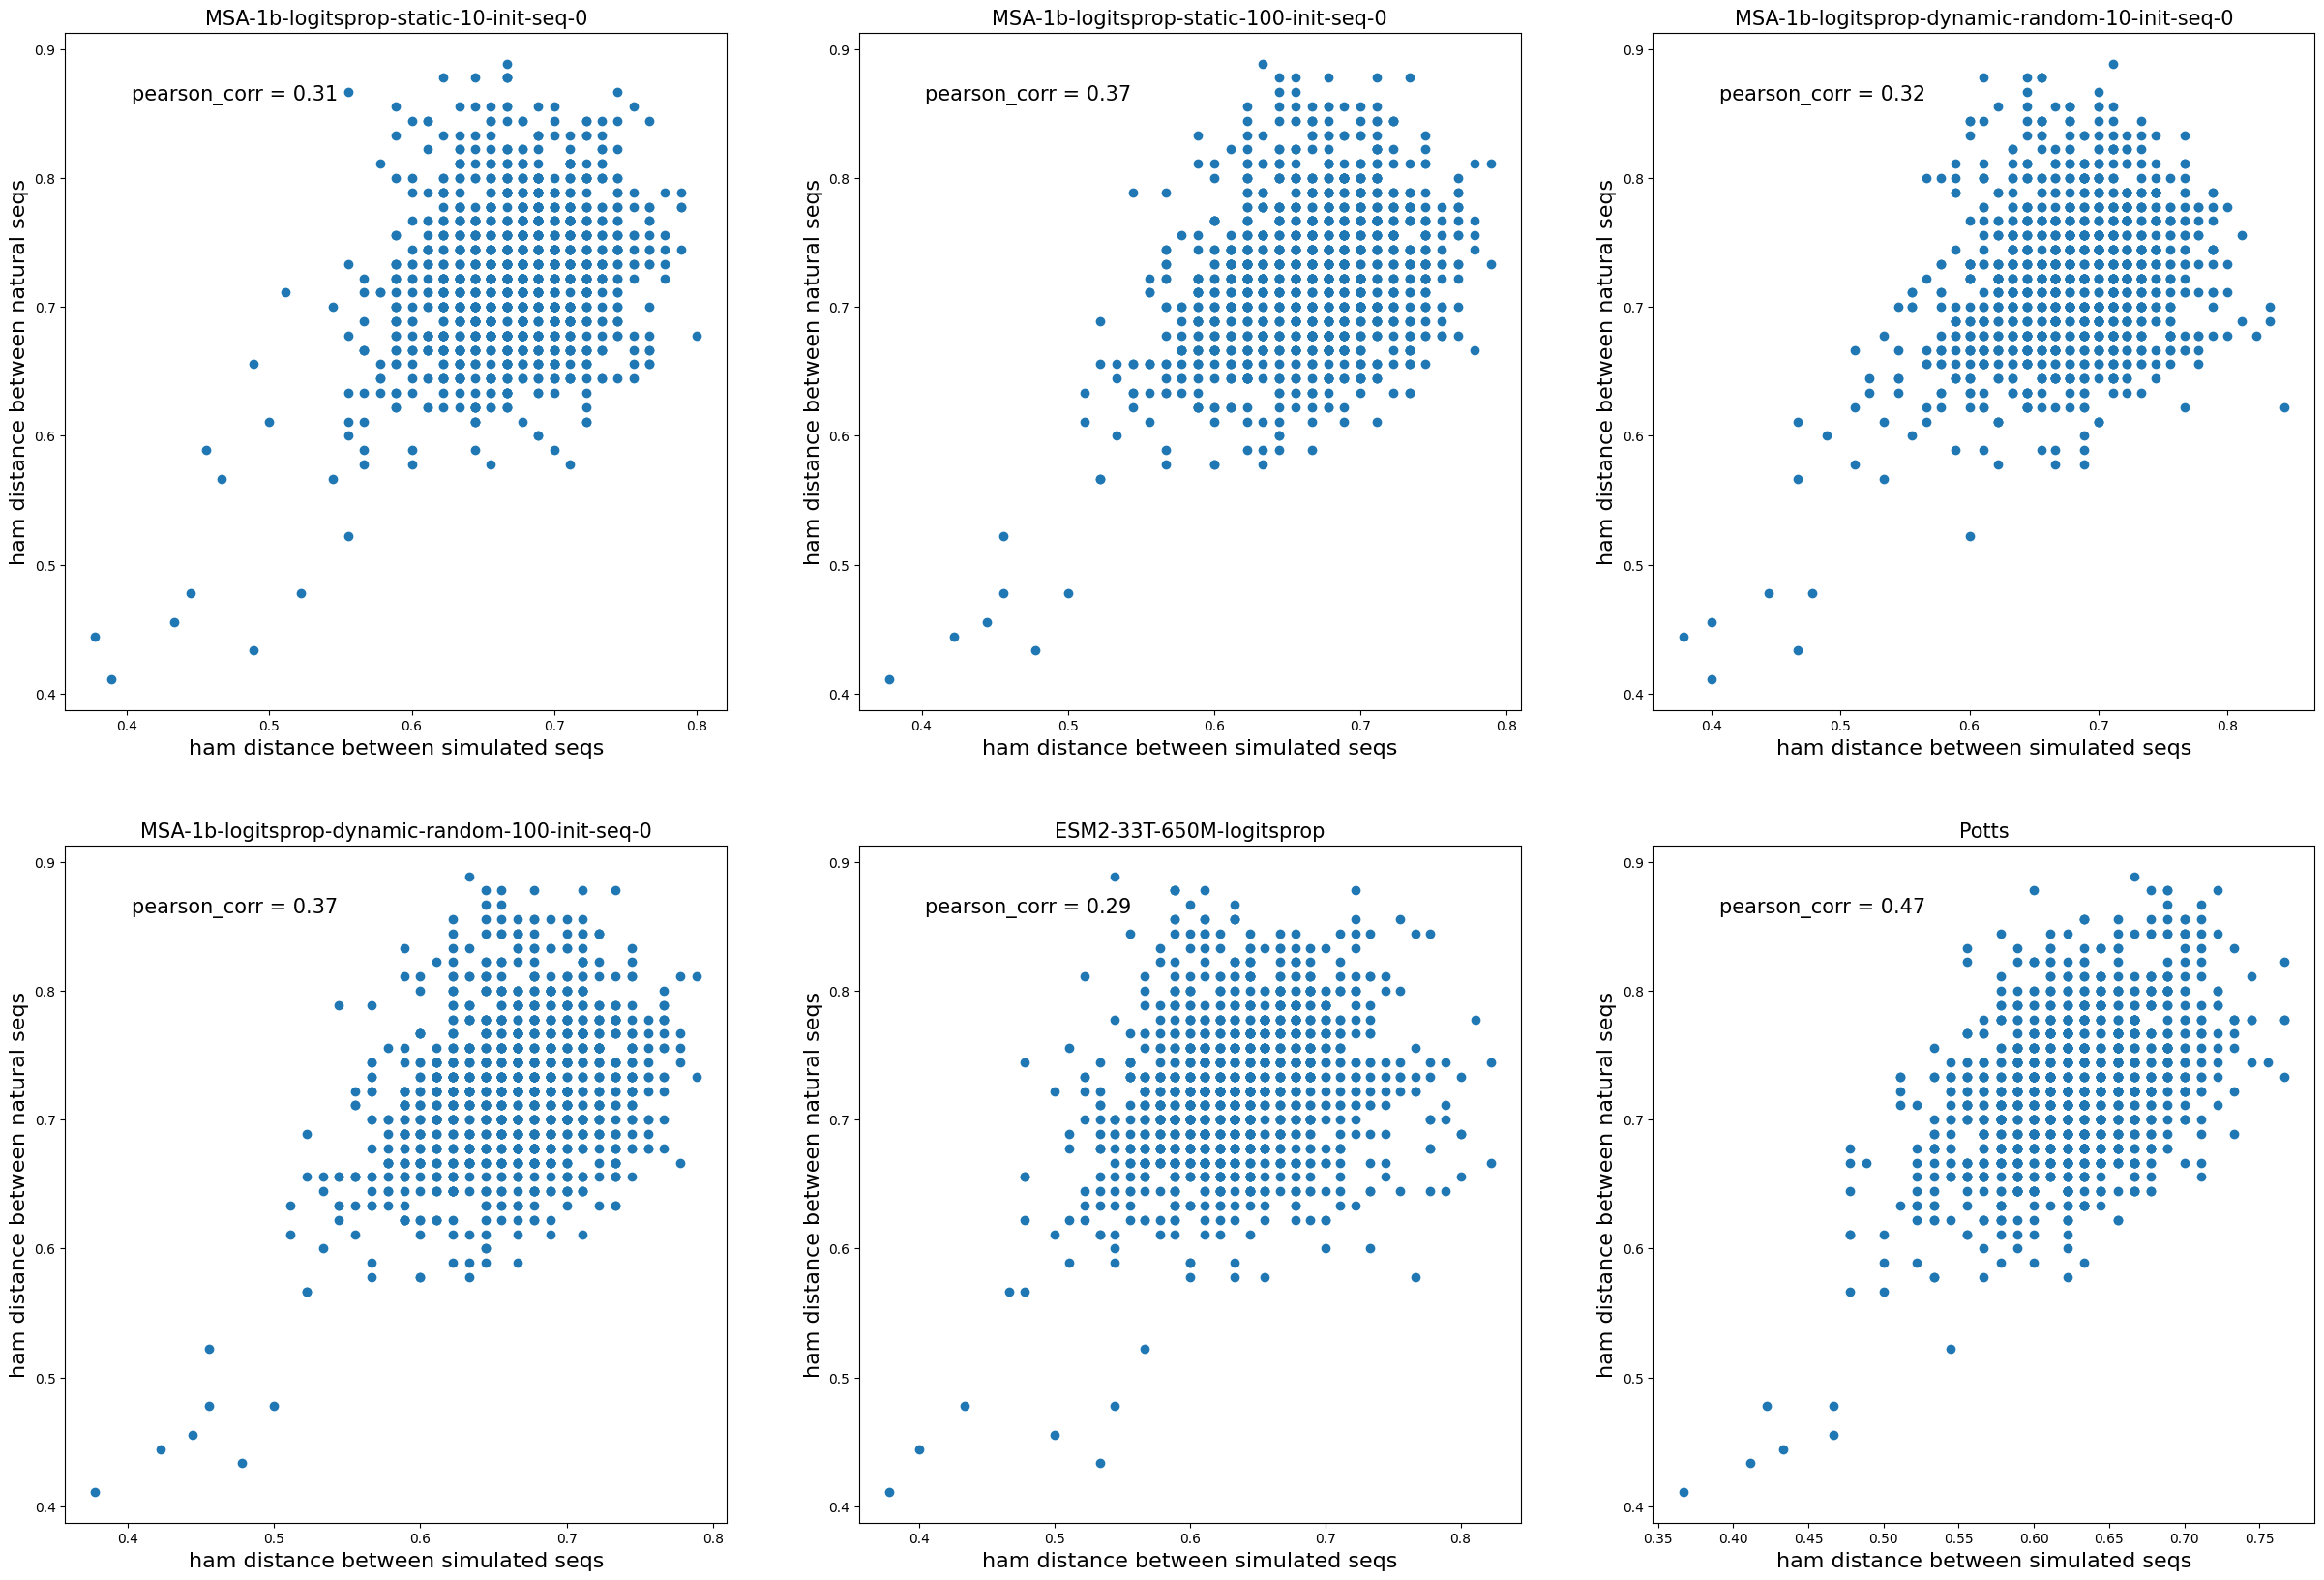

In [143]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from math import floor,ceil
from scipy import stats

plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=16)

ncols = 3
nrows = max(2,int(ceil((len(tool_types) - 1)/3)))

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (30,10 * nrows))

for k in range(len(tool_types)):

    if tool_types[k].startswith("nat"):
        continue

    i = floor(k/3)
    j = k % 3
    
    main_dataframe_tool_sim = hd_dataframe.loc[(hd_dataframe["tool"] == tool_types[k]) & (hd_dataframe["sim_ind"] == sim_ind), :]
    axes[i][j].scatter(main_dataframe_tool_sim["ham_dist_sim"], main_dataframe_tool_sim["ham_dist_corr_nat"])
    axes[i][j].set_title(tool_types[k])
    axes[i][j].set_xlabel("ham distance between simulated seqs")
    axes[i][j].set_ylabel("ham distance between natural seqs")
    pearson_corr = pearsonr(main_dataframe_tool_sim["ham_dist_sim"], main_dataframe_tool_sim["ham_dist_corr_nat"])
    axes[i][j].annotate(f"pearson_corr = {pearson_corr.statistic:.2f}",xy = (0.1,0.9), xycoords = "axes fraction", fontsize = 15)

    # values = np.vstack([main_dataframe_tool_sim["ham_dist_sim"], main_dataframe_tool_sim["ham_dist_corr_nat"]])
    # kernel = stats.gaussian_kde(values)(values)
    # sns.scatterplot(
    #     data=main_dataframe_tool_sim,
    #     x="ham_dist_sim",
    #     y="ham_dist_corr_nat",
    #     ax=axes[i][j],
    # )

    # sns.kdeplot(
    #     data=main_dataframe_tool_sim,
    #     x="ham_dist_sim",
    #     y="ham_dist_corr_nat",
    #     fill=True,
    #     ax=axes[i][j],
    # )

# plt.savefig(f"ham_distances_scatterplots_sim_{sim_ind}.png")

### Comparing Hamming Distances with Corresponding Patristic Distances

In [ ]:
hd_dataframe = pd.DataFrame(columns=["tool","sim_ind","ham_dist_sim","ham_dist_corr_nat"])
sim_ind = 1

for j,folder in enumerate(scores_folders):
        
    for i,file in enumerate(os.listdir(folder)):

        if not tool_types[j].startswith("nat") and tool_types[j] != "full_sampling":
            file_sim_ind = file.split('.')[0]
            file_sim_ind = int(file_sim_ind.split('-')[1])
        else:
            file_sim_ind = sim_ind

        if file_sim_ind != sim_ind:
            continue
            
        file_path = os.path.join(folder,file)
        dist_dataframe = pd.DataFrame()
        
        df = pd.read_csv(file_path, delimiter="\t") 
        
        num_sim_array = np.array([list(seq) for seq in df["sequence"]], dtype=np.bytes_).view(np.uint8)
        
        distance_matrix_sim = cdist(num_sim_array,num_sim_array, "hamming")
        pairwise_distances_sim = distance_matrix_sim[np.triu_indices_from(distance_matrix_sim, k=1)]

        patristic_distance_matrix = np.zeros((df.shape[0], df.shape[0]))

        for a in range(df.shape[0]):
            for b in range(a + 1, df.shape[0]):
                if tool_types[j].startswith("nat"):
                    patristic_distance_matrix[a][b] = tree.distance(df["sequence_name"][a],df["sequence_name"][b])
                else:
                    patristic_distance_matrix[a][b] = tree.distance(df["corr_nat_seq_name"][a],df["corr_nat_seq_name"][b])
                patristic_distance_matrix[b][a] = patristic_distance_matrix[a][b]

        patristic_pairwise_dist = patristic_distance_matrix[np.triu_indices_from(patristic_distance_matrix, k=1)]

        dist_dataframe["ham_dist_sim"] = list(pairwise_distances_sim)
        dist_dataframe["corr_patristic_dist"] = list(patristic_pairwise_dist)
        dist_dataframe["tool"] = tool_types[j]
        dist_dataframe["sim_ind"] = file_sim_ind

        hd_dataframe = pd.concat((hd_dataframe, dist_dataframe)).reset_index(drop=True)

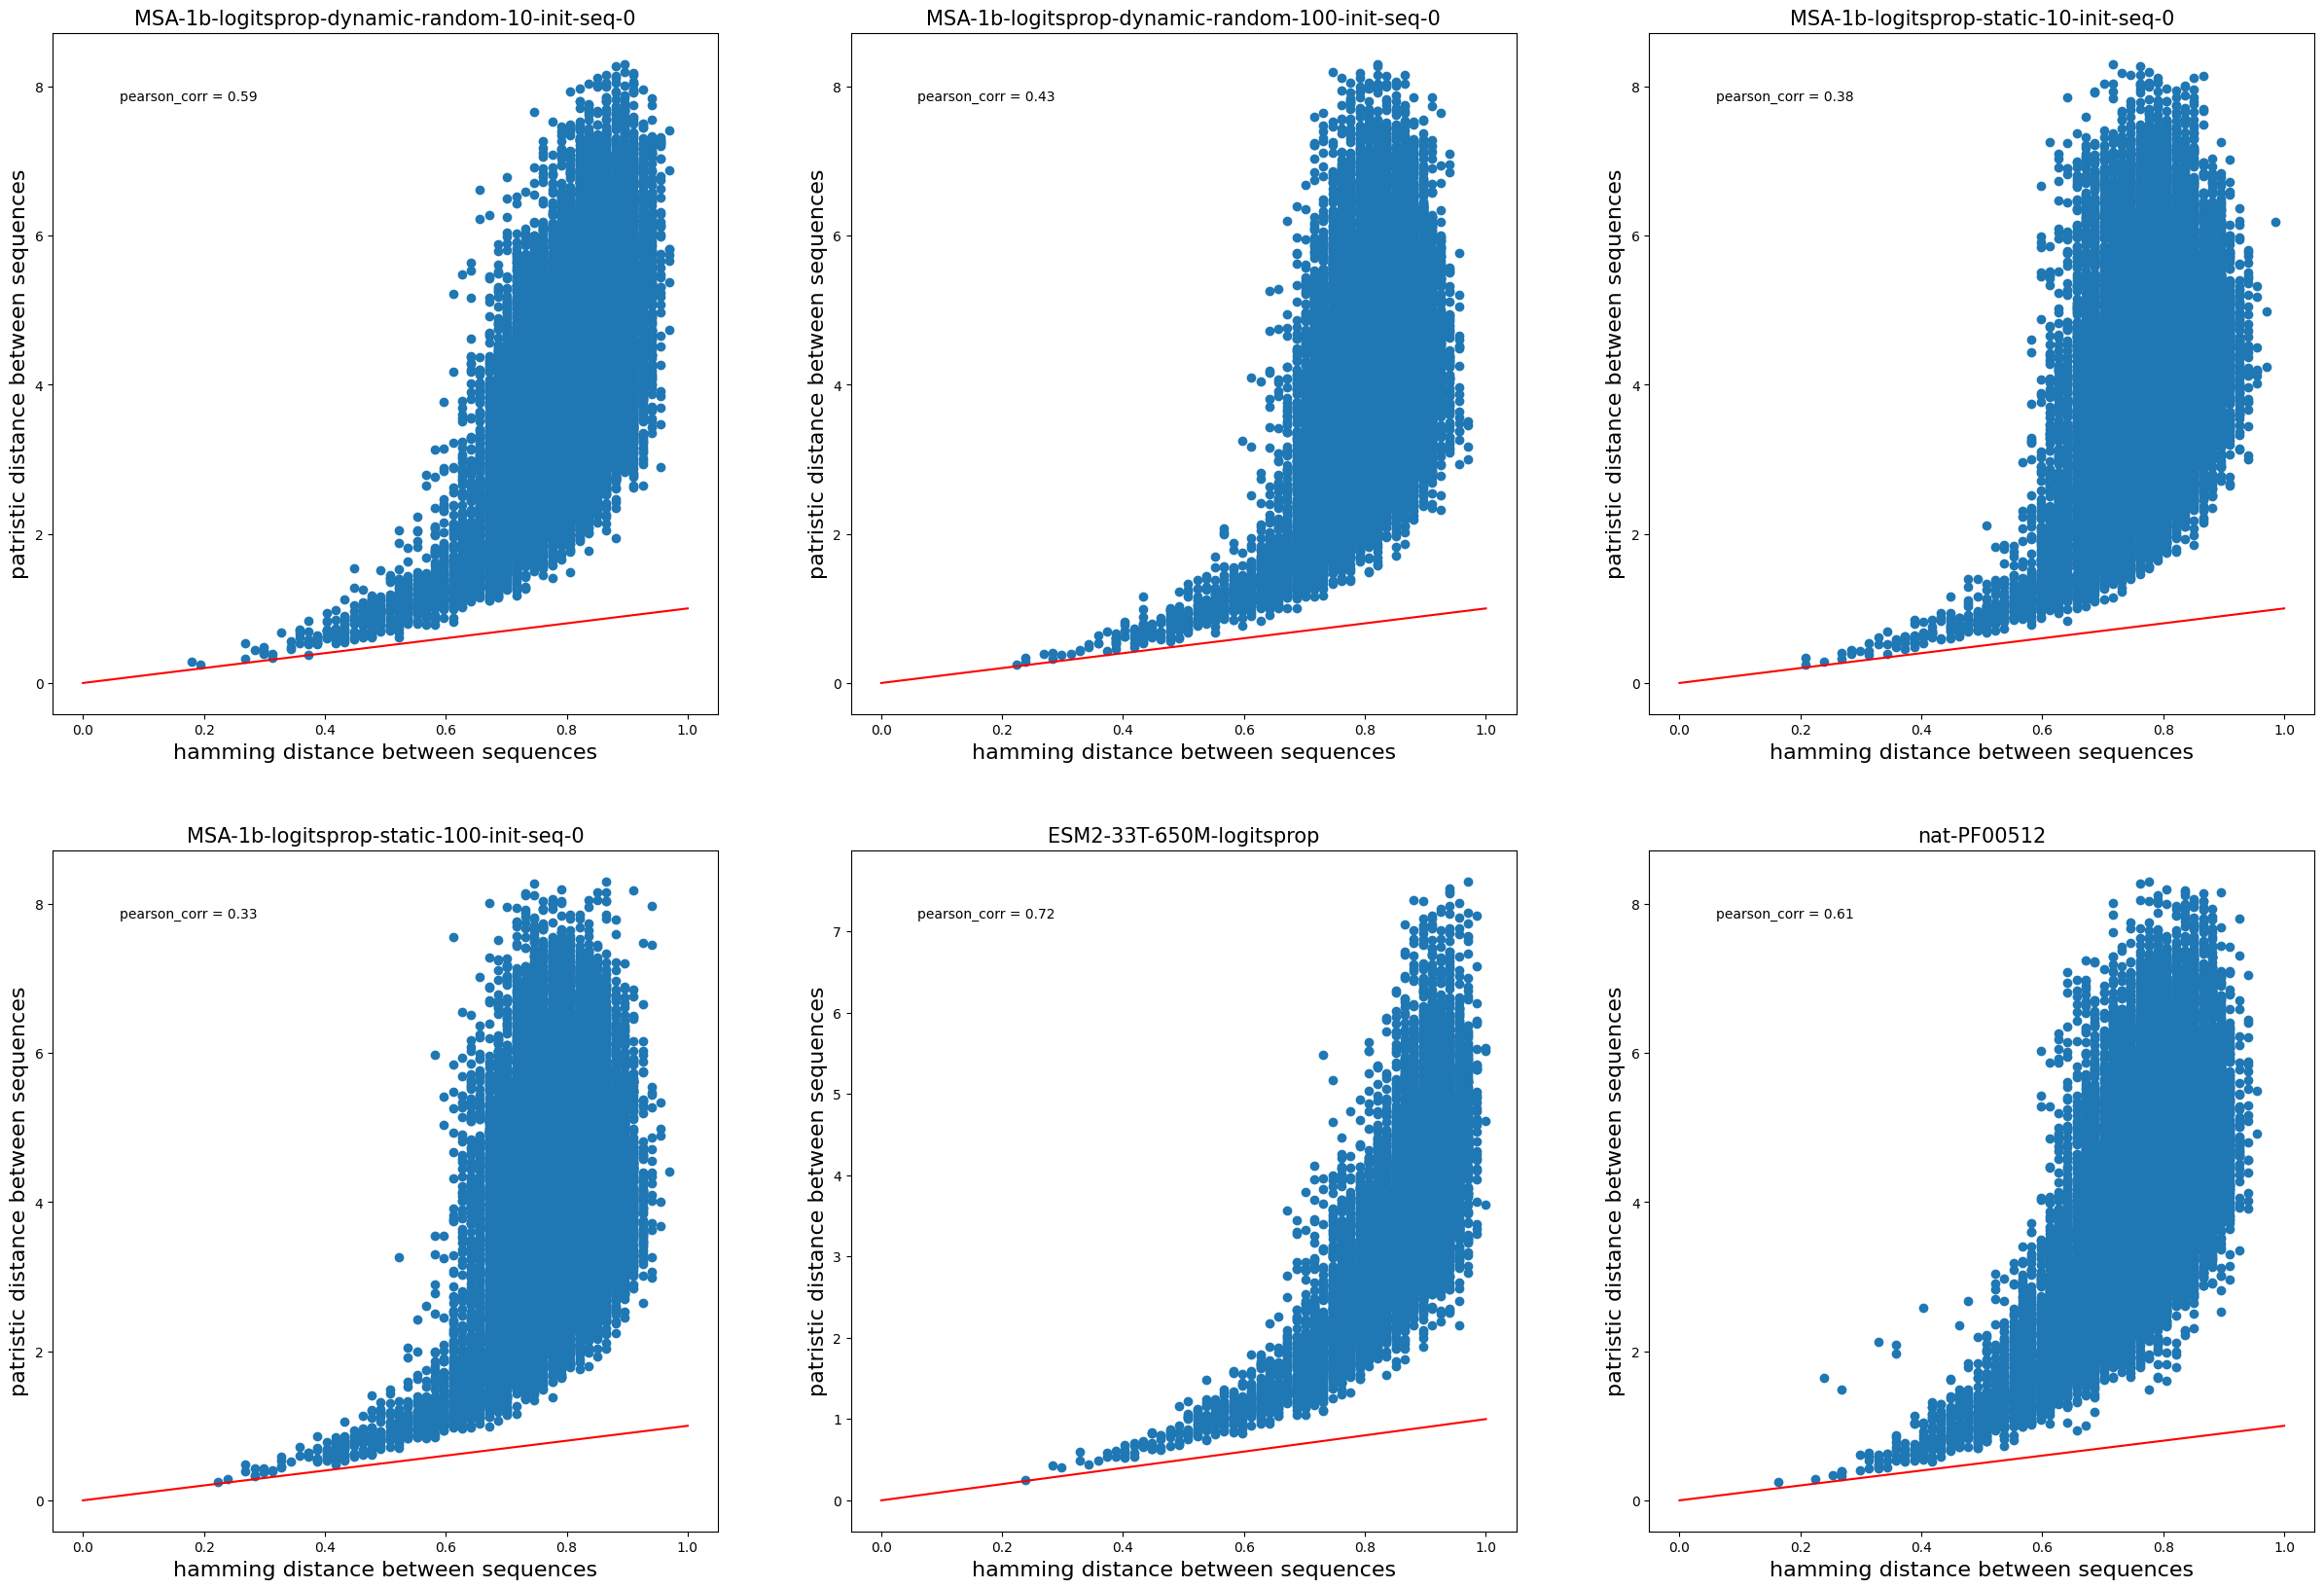

In [ ]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from math import floor,ceil
from scipy import stats

plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=16)

fig, axes = plt.subplots(nrows = int(ceil(len(tool_types)/3)), ncols = 3, figsize = (30,10 * int(ceil(len(tool_types)/3))))

for k in range(len(tool_types)):

    i = floor(k/3)
    j = k % 3
    
    main_dataframe_tool_sim = hd_dataframe.loc[(hd_dataframe["tool"] == tool_types[k]) & (hd_dataframe["sim_ind"] == sim_ind), :]
    axes[i][j].scatter(main_dataframe_tool_sim["ham_dist_sim"], main_dataframe_tool_sim["corr_patristic_dist"])
    axes[i][j].set_title(tool_types[k])
    axes[i][j].set_xlabel("hamming distance between sequences")
    axes[i][j].set_ylabel("patristic distance between sequences")
    pearson_corr = pearsonr(main_dataframe_tool_sim["ham_dist_sim"], main_dataframe_tool_sim["corr_patristic_dist"])
    axes[i][j].annotate(f"pearson_corr = {pearson_corr.statistic:.2f}",xy = (0.1,0.9), xycoords = "axes fraction")

    dummy = [0,0.5,1]
    axes[i][j].plot(dummy,dummy,'r-')
    
    # values = np.vstack([main_dataframe_tool_sim["ham_dist_sim"], main_dataframe_tool_sim["ham_dist_corr_nat"]])
    # kernel = stats.gaussian_kde(values)(values)
    # sns.scatterplot(
    #     data=main_dataframe_tool_sim,
    #     x="ham_dist_sim",
    #     y="ham_dist_corr_nat",
    #     ax=axes[i][j],
    # )

    # sns.kdeplot(
    #     data=main_dataframe_tool_sim,
    #     x="ham_dist_sim",
    #     y="corr_patristic_dist",
    #     fill=True,
    #     ax=axes[i][j],
    # )

plt.savefig(f"ham_patristic_scatterplots_sim_{sim_ind}.png")

### Computing and Comparing FastTree Distances

In [154]:
from Bio.Align import substitution_matrices

blomat = substitution_matrices.load("BLOSUM45")

In [12]:
blosum_dist_mat = np.array([ 
      [0, 1.31097856157468, 1.06573001937323, 1.2682782988532, 0.90471293383305, 1.05855446876905, 1.05232790675508, 0.769574440593014, 1.27579668305679, 0.964604099952603, 0.987178199640556, 1.05007594438157, 1.05464162250736, 1.1985987403937, 0.967404475245526, 0.700490199584332, 0.880060189098976, 1.09748548316685, 1.28141710375267, 0.800038509951648],
      [1.31097856157468, 0, 0.8010890222701, 0.953340718498495, 1.36011107208122, 0.631543775840481, 0.791014908659279, 1.15694899265629, 0.761152570032029, 1.45014917711188, 1.17792001455227, 0.394661075648738, 0.998807558909651, 1.135143404599, 1.15432562628921, 1.05309036790541, 1.05010474413616, 1.03938321130789, 0.963216908696184, 1.20274751778601],
      [1.06573001937323, 0.8010890222701, 0, 0.488217214273568, 1.10567116937273, 0.814970207038261, 0.810176440932339, 0.746487413974582, 0.61876156253224, 1.17886558630004, 1.52003670190022, 0.808442678243754, 1.2889025816028, 1.16264109995678, 1.18228799147301, 0.679475681649858, 0.853658619686283, 1.68988558988005, 1.24297493464833, 1.55207513886163],
      [1.2682782988532, 0.953340718498495, 0.488217214273568, 0, 1.31581050011876, 0.769778474953791, 0.482077627352988, 0.888361752320536, 0.736360849050364, 1.76756333403346, 1.43574761894039, 0.763612910719347, 1.53386612356483, 1.74323672079854, 0.886347403928663, 0.808614044804528, 1.01590147813779, 1.59617804551619, 1.1740494822217, 1.46600946033173],
      [0.90471293383305, 1.36011107208122, 1.10567116937273, 1.31581050011876, 0, 1.3836789310481, 1.37553994252576, 1.26740695314856, 1.32361065635259, 1.26087264215993, 1.02417540515351, 1.37259631233791, 1.09416720447891, 0.986982088723923, 1.59321190226694, 0.915638787768407, 0.913042853922533, 1.80744143643002, 1.3294417177004, 0.830022143283238],
      [1.05855446876905, 0.631543775840481, 0.814970207038261, 0.769778474953791, 1.3836789310481, 0, 0.506942797642807, 1.17699648087288, 0.614595446514896, 1.17092829494457, 1.19833088638994, 0.637341078675405, 0.806490842729072, 1.83315144709714, 0.932064479113502, 0.850321696813199, 1.06830084665916, 1.05739353225849, 0.979907428113788, 1.5416250309563],
      [1.05232790675508, 0.791014908659279, 0.810176440932339, 0.482077627352988, 1.37553994252576, 0.506942797642807, 0, 1.17007322676118, 0.769786956320484, 1.46659942462342, 1.19128214039009, 0.633592151371708, 1.27269395724349, 1.44641491621774, 0.735428579892476, 0.845319988414402, 1.06201695511881, 1.324395996498, 1.22734387448031, 1.53255698189437],
      [0.769574440593014, 1.15694899265629, 0.746487413974582, 0.888361752320536, 1.26740695314856, 1.17699648087288, 1.17007322676118, 0, 1.1259007054424, 1.7025415585924, 1.38293205218175, 1.16756929156758, 1.17264582493965, 1.33271035269688, 1.07564768421292, 0.778868281341681, 1.23287107008366, 0.968539655354582, 1.42479529031801, 1.41208067821187],
      [1.27579668305679, 0.761152570032029, 0.61876156253224, 0.736360849050364, 1.32361065635259, 0.614595446514896, 0.769786956320484, 1.1259007054424, 0, 1.4112324673522, 1.14630894167097, 0.967795284542623, 0.771479459384692, 1.10468029976148, 1.12334774065132, 1.02482926701639, 1.28754326478771, 1.27439749294131, 0.468683841672724, 1.47469999960758],
      [0.964604099952603, 1.45014917711188, 1.17886558630004, 1.76756333403346, 1.26087264215993, 1.17092829494457, 1.46659942462342, 1.7025415585924, 1.4112324673522, 0, 0.433350517223017, 1.463460928818, 0.462965544381851, 0.66291968000662, 1.07010201755441, 1.23000200130049, 0.973485453109068, 0.963546200571036, 0.708724769805536, 0.351200119909572],
      [0.987178199640556, 1.17792001455227, 1.52003670190022, 1.43574761894039, 1.02417540515351, 1.19833088638994, 1.19128214039009, 1.38293205218175, 1.14630894167097, 0.433350517223017, 0, 1.49770950074319, 0.473800072611076, 0.538473125003292, 1.37979627224964, 1.5859723170438, 0.996267398224516, 0.986095542821092, 0.725310666139274, 0.570542199221932],
      [1.05007594438157, 0.394661075648738, 0.808442678243754, 0.763612910719347, 1.37259631233791, 0.637341078675405, 0.633592151371708, 1.16756929156758, 0.967795284542623, 1.463460928818, 1.49770950074319, 0, 1.0079761868248, 1.44331961488922, 0.924599080166146, 1.06275728888356, 1.05974425835993, 1.04892430642749, 0.972058829603409, 1.21378822764856],
      [1.05464162250736, 0.998807558909651, 1.2889025816028, 1.53386612356483, 1.09416720447891, 0.806490842729072, 1.27269395724349, 1.17264582493965, 0.771479459384692, 0.462965544381851, 0.473800072611076, 1.0079761868248, 0, 0.72479754849538, 1.1699868662153, 1.34481214251794, 1.06435197383538, 1.05348497728858, 0.774878150710318, 0.609532859331199],
      [1.1985987403937, 1.135143404599, 1.16264109995678, 1.74323672079854, 0.986982088723923, 1.83315144709714, 1.44641491621774, 1.33271035269688, 1.10468029976148, 0.66291968000662, 0.538473125003292, 1.44331961488922, 0.72479754849538, 0, 1.32968844979665, 1.21307373491949, 0.960087571600877, 0.475142555482979, 0.349485367759138, 0.692733248746636],
      [0.967404475245526, 1.15432562628921, 1.18228799147301, 0.886347403928663, 1.59321190226694, 0.932064479113502, 0.735428579892476, 1.07564768421292, 1.12334774065132, 1.07010201755441, 1.37979627224964, 0.924599080166146, 1.1699868662153, 1.32968844979665, 0, 0.979087429691819, 0.97631161216338, 1.21751652292503, 1.42156458605332, 1.40887880416009],
      [0.700490199584332, 1.05309036790541, 0.679475681649858, 0.808614044804528, 0.915638787768407, 0.850321696813199, 0.845319988414402, 0.778868281341681, 1.02482926701639, 1.23000200130049, 1.5859723170438, 1.06275728888356, 1.34481214251794, 1.21307373491949, 0.979087429691819, 0, 0.56109848274013, 1.76318885009194, 1.29689226231656, 1.02015839286433],
      [0.880060189098976, 1.05010474413616, 0.853658619686283, 1.01590147813779, 0.913042853922533, 1.06830084665916, 1.06201695511881, 1.23287107008366, 1.28754326478771, 0.973485453109068, 0.996267398224516, 1.05974425835993, 1.06435197383538, 0.960087571600877, 0.97631161216338, 0.56109848274013, 0, 1.39547634461879, 1.02642577026706, 0.807404666228614],
      [1.09748548316685, 1.03938321130789, 1.68988558988005, 1.59617804551619, 1.80744143643002, 1.05739353225849, 1.324395996498, 0.968539655354582, 1.27439749294131, 0.963546200571036, 0.986095542821092, 1.04892430642749, 1.05348497728858, 0.475142555482979, 1.21751652292503, 1.76318885009194, 1.39547634461879, 0, 0.320002937404137, 1.268589159299],
      [1.28141710375267, 0.963216908696184, 1.24297493464833, 1.1740494822217, 1.3294417177004, 0.979907428113788, 1.22734387448031, 1.42479529031801, 0.468683841672724, 0.708724769805536, 0.725310666139274, 0.972058829603409, 0.774878150710318, 0.349485367759138, 1.42156458605332, 1.29689226231656, 1.02642577026706, 0.320002937404137, 0, 0.933095433689795],
      [0.800038509951648, 1.20274751778601, 1.55207513886163, 1.46600946033173, 0.830022143283238, 1.5416250309563, 1.53255698189437, 1.41208067821187, 1.47469999960758, 0.351200119909572, 0.570542199221932, 1.21378822764856, 0.609532859331199, 0.692733248746636, 1.40887880416009, 1.02015839286433, 0.807404666228614, 1.268589159299, 0.933095433689795, 0]])

mapping_dict = {k:v for k, v in zip(list("ARNDCQEGHILKMFPSTWYV-"),range(21))}



In [13]:
from numba import njit

@njit
def calc_fasttree_distance(seq1, seq2, blosum_dist_mat, corrected = True):

    assert len(seq1) == len(seq2), "seqs must be of the same length"

    dist = 0
    count = 0

    for i in range(len(seq1)):

        char_1 = seq1[i]
        char_2 = seq2[i]

        if char_1 == 20 or char_2 == 20:
            continue

        dist += blosum_dist_mat[char_1, char_2]
        count += 1

    if count == 0:
        return 3.0
    
    uncorrected_dist = dist/count

    if not corrected:
        return uncorrected_dist

    corrected_dist = min(3.0, -1.3 * np.log(1 - uncorrected_dist)) if uncorrected_dist < 1 else 3.0

    return corrected_dist

In [26]:
fd_dataframe = pd.DataFrame()
sim_ind = 4

for j,folder in enumerate(scores_folders):

    # if tool_types[j].startswith("nat"):
    #         continue
    print(folder)
        
    for i,file in enumerate(os.listdir(folder)):


        if not tool_types[j].startswith("nat"):
            file_sim_ind = file.split('.')[0]
            file_sim_ind = int(file_sim_ind.split('-')[1])
        else:
            file_sim_ind = sim_ind

        # if file_sim_ind != sim_ind:
        #     continue
            
        file_path = os.path.join(folder,file)
        dist_dataframe = pd.DataFrame()
        
        df = pd.read_csv(file_path, delimiter="\t") 

        fd_distances_sim_corrected = []
        fd_distances_corr_nat_corrected = []

        fd_distances_sim_uncorrected = []
        fd_distances_corr_nat_uncorrected = []

        valid_chars = list(mapping_dict.keys())

        for k in range(len(df)):

            for l in range(k+1, len(df)):

                seq_1_sim = df.loc[k,"sequence"]
                seq_2_sim = df.loc[l, "sequence"]

                seq_1_sim = np.array([mapping_dict[char] if char in valid_chars else 20 for char in seq_1_sim])
                seq_2_sim = np.array([mapping_dict[char] if char in valid_chars else 20 for char in seq_2_sim])

                dist_sim = calc_fasttree_distance(seq_1_sim, seq_2_sim, blosum_dist_mat, corrected=True)
                fd_distances_sim_corrected.append(dist_sim)

                dist_sim = calc_fasttree_distance(seq_1_sim, seq_2_sim, blosum_dist_mat, corrected=False)
                fd_distances_sim_uncorrected.append(dist_sim)

                seq_1_nat = df.loc[k,"corr_nat_seq"]
                seq_2_nat = df.loc[l, "corr_nat_seq"]

                seq_1_nat = np.array([mapping_dict[char] if char in valid_chars else 20 for char in seq_1_nat ])
                seq_2_nat = np.array([mapping_dict[char] if char in valid_chars else 20 for char in seq_2_nat ])

                dist_nat = calc_fasttree_distance(seq_1_nat, seq_2_nat, blosum_dist_mat, corrected=True)
                fd_distances_corr_nat_corrected.append(dist_nat)

                dist_nat = calc_fasttree_distance(seq_1_nat, seq_2_nat, blosum_dist_mat, corrected=False)
                fd_distances_corr_nat_uncorrected.append(dist_nat)

        dist_dataframe["fd_sim_corrected"] = list(fd_distances_sim_corrected)
        dist_dataframe["fd_corr_nat_corrected"] = list(fd_distances_corr_nat_corrected)
        dist_dataframe["fd_sim_uncorrected"] = list(fd_distances_sim_uncorrected)
        dist_dataframe["fd_corr_nat_uncorrected"] = list(fd_distances_corr_nat_uncorrected)
        dist_dataframe["tool"] = tool_types[j]
        dist_dataframe["sim_ind"] = file_sim_ind
        dist_dataframe["family"] = re.findall("PF[0-9]{5}",folder)[0]

        fd_dataframe = pd.concat((fd_dataframe, dist_dataframe)).reset_index(drop=True)

fd_dataframe = fd_dataframe.dropna()

./scores/msa-seed-simulations/MSA-1b/PF00004/init-seq-0/logits-proposal/static-context/10/
./scores/msa-seed-simulations/MSA-1b/PF00005/init-seq-0/logits-proposal/static-context/10/
./scores/msa-seed-simulations/MSA-1b/PF00041/init-seq-0/logits-proposal/static-context/10/
./scores/msa-seed-simulations/MSA-1b/PF00072/init-seq-0/logits-proposal/static-context/10/
./scores/msa-seed-simulations/MSA-1b/PF00076/init-seq-0/logits-proposal/static-context/10/
./scores/msa-seed-simulations/MSA-1b/PF00096/init-seq-0/logits-proposal/static-context/10/
./scores/msa-seed-simulations/MSA-1b/PF00153/init-seq-0/logits-proposal/static-context/10/
./scores/msa-seed-simulations/MSA-1b/PF00271/init-seq-0/logits-proposal/static-context/10/
./scores/msa-seed-simulations/MSA-1b/PF00397/init-seq-0/logits-proposal/static-context/10/
./scores/msa-seed-simulations/MSA-1b/PF00512/init-seq-0/logits-proposal/static-context/10/
./scores/msa-seed-simulations/MSA-1b/PF00595/init-seq-0/logits-proposal/static-context/10/

In [33]:
fd_corr_table = []
for tool in list(fd_dataframe["tool"].unique()):

    if tool.startswith("nat"):
        continue

    for family in list(fd_dataframe["family"].unique()):

        corrs_list_corrected = []
        corrs_list_uncorrected = []

        try:
            for sim_ind in list(fd_dataframe["sim_ind"].unique()):

                cur_df = fd_dataframe.loc[(fd_dataframe["family"] == family) & (fd_dataframe["tool"] == tool) & (fd_dataframe["sim_ind"] == sim_ind),:]

                pearson_corr_corrected = pearsonr(cur_df["fd_sim_corrected"], cur_df["fd_corr_nat_corrected"]).statistic
                pearson_corr_uncorrected = pearsonr(cur_df["fd_sim_uncorrected"], cur_df["fd_corr_nat_uncorrected"]).statistic

                corrs_list_corrected.append(pearson_corr_corrected)
                corrs_list_uncorrected.append(pearson_corr_uncorrected)
        except:
            continue

        mean_corr_corrected = np.mean(corrs_list_corrected)
        sd_corr_corrected = np.std(corrs_list_corrected)

        mean_corr_uncorrected = np.mean(corrs_list_uncorrected)
        sd_corr_uncorrected = np.std(corrs_list_uncorrected)

        fd_corr_table.append({"tool":tool,"family":family,"mean_fd_corr_corrected":mean_corr_corrected,
                              "sd_fd_corr_corrected":sd_corr_corrected, "mean_fd_corr_uncorrected":mean_corr_uncorrected,"sd_fd_corr_uncorrected":sd_corr_uncorrected})


fd_corr_table = pd.DataFrame(fd_corr_table)


In [35]:
fd_corr_table.to_csv("large_families_mean_fd_correlations.tsv", sep="\t")

In [37]:
full_fam = "./pfam_full_msas/fasta/PF00001_full.fasta"

seqs = [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(full_fam, "fasta")]

Seq_tuples_to_fasta(seqs, full_fam, "fasta")

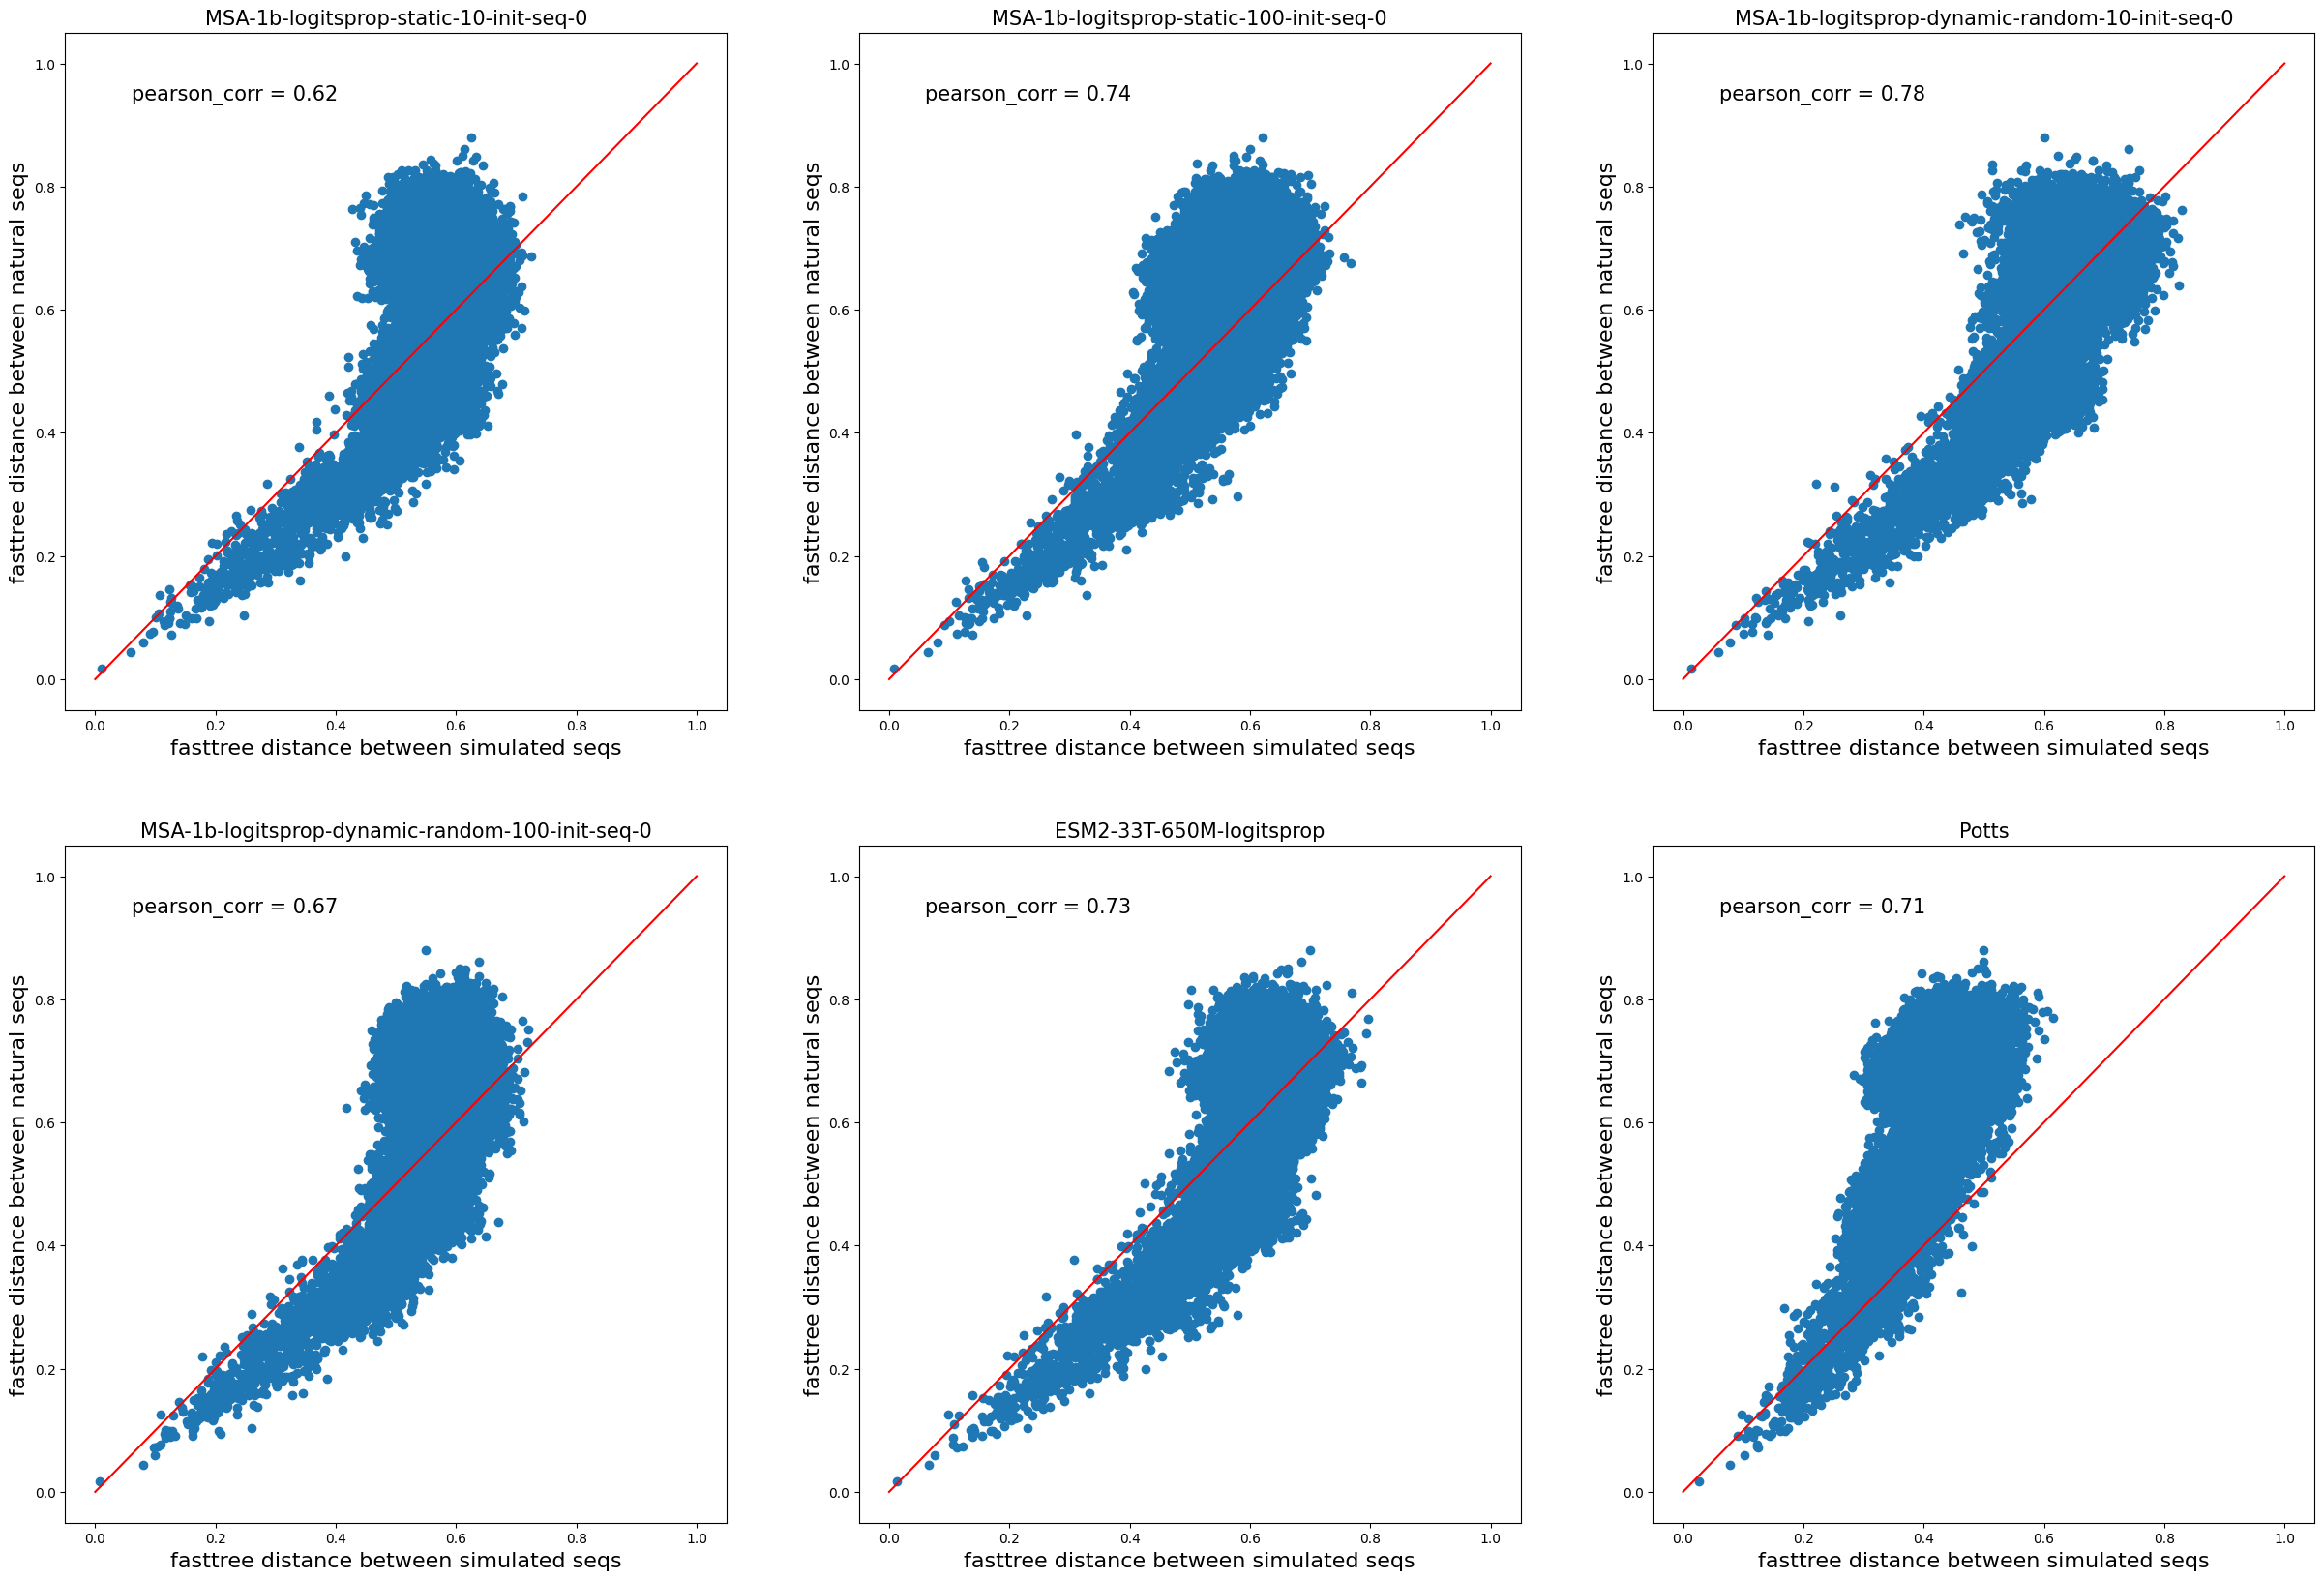

In [158]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from math import floor,ceil
from scipy import stats

plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=16)

ncols = 3
nrows = max(2,int(ceil((len(tool_types) - 1)/3)))

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (30,10 * nrows))

for k in range(len(tool_types)):

    if tool_types[k].startswith("nat"):
        continue

    i = floor(k/3)
    j = k % 3
    
    main_dataframe_tool_sim = fd_dataframe.loc[(fd_dataframe["tool"] == tool_types[k]) & (fd_dataframe["sim_ind"] == sim_ind), :]
    axes[i][j].scatter(main_dataframe_tool_sim["fd_sim"], main_dataframe_tool_sim["fd_corr_nat"])
    axes[i][j].set_title(tool_types[k])
    axes[i][j].set_xlabel("fasttree distance between simulated seqs")
    axes[i][j].set_ylabel("fasttree distance between natural seqs")
    pearson_corr = pearsonr(main_dataframe_tool_sim["fd_sim"], main_dataframe_tool_sim["fd_corr_nat"])
    axes[i][j].annotate(f"pearson_corr = {pearson_corr.statistic:.2f}",xy = (0.1,0.9), xycoords = "axes fraction", fontsize = 15)

    dummy = [0,1]
    axes[i][j].plot(dummy,dummy,'r-')
    # values = np.vstack([main_dataframe_tool_sim["ham_dist_sim"], main_dataframe_tool_sim["ham_dist_corr_nat"]])
    # kernel = stats.gaussian_kde(values)(values)
    # sns.scatterplot(
    #     data=main_dataframe_tool_sim,
    #     x="ham_dist_sim",
    #     y="ham_dist_corr_nat",
    #     ax=axes[i][j],
    # )

    # sns.kdeplot(
    #     data=main_dataframe_tool_sim,
    #     x="fd_sim",
    #     y="fd_corr_nat",
    #     fill=True,
    #     ax=axes[i][j],
    # )

# plt.savefig(f"ham_distances_scatterplots_sim_{sim_ind}.png")

## Initial Processing

#### No Averaging

In [ ]:
all_metrics_dataframe = pd.DataFrame()

for j,folder in enumerate(scores_folders):
    
    main_dataframe = pd.DataFrame()
    family = re.findall("PF[0-9]{5}",folder)[0]
    
    for i,file in enumerate(os.listdir(folder)):

        if not tool_types[j].startswith("nat") and tool_types[j] != "full_sampling":
            file_sim_ind = file.split('.')[0]
            file_sim_ind = int(file_sim_ind.split('-')[1])
        else:
            file_sim_ind = 1

        file_path = os.path.join(folder,file)
        df = pd.read_csv(file_path, delimiter="\t")
        
        df["Tool"] = tool_types[j]
        df["Sim index"] = file_sim_ind
        df["Family"] = family
        df["Model"] = model_order[j]
        df["Proposal"] = proposal_order[j]
        df["Context type"] = context_type_order[j]
        df["Context sampling"] = context_sampling_order[j]
        df["Context size"] = context_size_order[j]
        df["Init seq"] = init_seq_order[j]
        df["Mutations"] = n_mutations[j]
        
        main_dataframe = pd.concat((main_dataframe, df)).reset_index(drop=True)

    main_dataframe = pd.DataFrame(main_dataframe)
    main_dataframe["hmmer_seq_score_normalized"] = main_dataframe["hmmer_seq_score"]/max_nat_hmmer_score[family]
    try:
        main_dataframe["stat_energy_score_z_scored"] = (main_dataframe["stat_energy_scores"] - mean_stat_energy_score[family])/std_stat_energy_score[family]
    except:
        pass
    
    all_metrics_dataframe = pd.concat([all_metrics_dataframe, main_dataframe]).reset_index(drop = True)



for init_seq in init_seqs:
    for family in protein_families:
         msas = read_msa(f"./data/protein-families-msa-seed/{family}_seed.fasta")
         init_seq_id = msas[int(init_seq)][0]
         scores = pd.read_csv(f"scores/protein-families-msa-seed/{family}/{family}_seed.tsv", delimiter = "\t")
         init_seq_scores = scores.loc[scores["sequence_name"] == init_seq_id, :].reset_index(drop = True)
         init_seq_scores["Tool"] = f"init-seq-{init_seq}"
         init_seq_scores["Model"] = f"init-seq-{init_seq}"
         init_seq_scores["Family"] = family
         init_seq_scores["Sim index"] = 1
         init_seq_scores["hmmer_seq_score_normalized"] = init_seq_scores["hmmer_seq_score"]/max_nat_hmmer_score[family]
         try:
            init_seq_scores["stat_energy_score_z_scored"] = (init_seq_scores["stat_energy_scores"] - mean_stat_energy_score[family])/std_stat_energy_score[family]
         except:
            pass

         all_metrics_dataframe = pd.concat([all_metrics_dataframe, init_seq_scores]).reset_index(drop = True)






### No Averaging - Tree Scores

In [ ]:
tree_metrics_dataframe = pd.DataFrame()
bootstrap_common_path = "./scores/bootstrap-seed-trees/"

for j,folder in enumerate(tree_scores_folders):
    
    main_dataframe = pd.DataFrame()
    family = re.findall("PF[0-9]{5}",folder)[0]
    
    for i,file in enumerate(os.listdir(folder)):

        row = {"tool":tool_types[j]}
        file_path = os.path.join(folder,file)
        df = pd.read_csv(file_path, delimiter="\t")
        
        df["Tool"] = tool_types[j]
        df["Sim index"] = file_sim_ind
        df["Family"] = family
        df["Model"] = model_order[j].split('-')[0]
        df["Proposal"] = proposal_order[j]
        df["Context type"] = context_type_order[j]
        df["Context sampling"] = context_sampling_order[j]
        df["Context size"] = context_size_order[j]
        df["Init seq"] = init_seq_order[j]
        
        main_dataframe = pd.concat((main_dataframe, df)).reset_index(drop=True)

    main_dataframe = pd.DataFrame(main_dataframe)
    tree_metrics_dataframe = pd.concat([tree_metrics_dataframe, main_dataframe]).reset_index(drop = True)

for family in protein_families:

        try:
            bootstrap_scores = pd.read_csv(bootstrap_common_path + f"{family}/bootstrap-scores.tsv", delimiter = "\t")
            bootstrap_scores["Family"] = family
            bootstrap_scores["Tool"] = "Bootstrap"
            bootstrap_scores["Model"] = "Bootstrap"
            bootstrap_scores["Context Type"] = "None"

            tree_metrics_dataframe = pd.concat([tree_metrics_dataframe, bootstrap_scores]).reset_index(drop = True)
        except:
             pass



#### Averaging

In [19]:
all_metrics_dataframe = pd.DataFrame()

max_nat_hmmer_scores = {}

for j,folder in enumerate(scores_folders):
    
    main_dataframe = []
    family = re.findall("PF[0-9]{5}",folder)[0]
    
    for i,file in enumerate(os.listdir(folder)):


        if not tool_types[j] == "nat":
            file_sim_ind = file.split('.')[0]
            file_sim_ind = int(file_sim_ind.split('-')[1])
        else:
            file_sim_ind = 1
            # file_path = os.path.join(folder,file)
            # main_dataframe = pd.read_csv(file_path, delimiter="\t").iloc[:,4:]
            # names = [elem + "_mean" for elem in list(main_dataframe.columns)]
            # main_dataframe.columns = names
            # main_dataframe["Tool"] = tool_types[j]
            # main_dataframe["Sim index"] = file_sim_ind
            # main_dataframe["Family"] = re.findall("PF[0-9]{5}",folder)[0]
            # main_dataframe["Tool"] = tool_types[j]
            # main_dataframe["Model"] = model_order[j]
            # main_dataframe["Proposal"] = proposal_order[j]
            # main_dataframe["Context type"] = context_type_order[j]
            # main_dataframe["Context sampling"] = context_sampling_order[j]
            # main_dataframe["Context size"] = context_size_order[j]
            # main_dataframe["Init seq"] = init_seq_order[j]
            # main_dataframe["Mutations"] = n_mutations_order[j]
            
            # main_dataframe["hmmer_seq_score_mean"] = main_dataframe["hmmer_seq_score_mean"]/max_nat_hmmer_score[family]
            # all_metrics_dataframe = pd.concat([all_metrics_dataframe, main_dataframe]).reset_index(drop = True)

            # continue

        row = {"Tool":tool_types[j],"Sim index":file_sim_ind, "Family": family}
        
        file_path = os.path.join(folder,file)
        df = pd.read_csv(file_path, delimiter="\t")
        
        if phylogeny or tool_types[j].startswith("nat"):
            df = df.iloc[:,4:].mean(axis = 0)
        else:
            df = df.iloc[:,2:].mean(axis = 0)

        names = [elem + "_mean" for elem in list(df.index)]
        df.index = names

        record = df.to_dict()
        row.update(record)

        main_dataframe.append(row)

    main_dataframe = pd.DataFrame(main_dataframe)
    main_dataframe["hmmer_seq_score_mean_normalized"] = main_dataframe["hmmer_seq_score_mean"]/max_nat_hmmer_score[family]
    try:
        main_dataframe["stat_energy_scores_mean_z_scored"] = (main_dataframe["stat_energy_scores_mean"] - mean_stat_energy_score[family])/std_stat_energy_score[family]
    except:
        pass

    main_dataframe["Model"] = model_order[j].split('-')[0]
    main_dataframe["Tool"] = tool_types[j]
    main_dataframe["Sim index"] = file_sim_ind
    main_dataframe["Family"] = family
    main_dataframe["Proposal"] = proposal_order[j]
    main_dataframe["Context type"] = context_type_order[j]
    main_dataframe["Context sampling"] = context_sampling_order[j]
    main_dataframe["Context size"] = context_size_order[j]
    main_dataframe["Init seq"] = init_seq_order[j]
    main_dataframe["Mutations"] = n_mutations_order[j]

    all_metrics_dataframe = pd.concat([all_metrics_dataframe, main_dataframe]).reset_index(drop = True)

    for init_seq in init_seqs:
        for family in protein_families:
            msas = read_msa(f"./data/protein-families-msa-seed/{family}_seed.fasta")
            init_seq_id = msas[0][0]
            scores = pd.read_csv(f"scores/protein-families-msa-seed/{family}/{family}_seed.tsv", delimiter = "\t")
            names = [elem + "_mean" for elem in list(scores.columns)[4:]]
            scores.columns = list(scores.columns[:4]) + names
            init_seq_scores = scores.loc[scores["sequence_name"] == init_seq_id, :].reset_index(drop = True)
            init_seq_scores["Tool"] = f"init-seq-{init_seq}"
            init_seq_scores["Family"] = family
            init_seq_scores["Sim index"] = 1
            init_seq_scores["hmmer_seq_score_mean_normalized"] = init_seq_scores["hmmer_seq_score_mean"]/max_nat_hmmer_score[family]
            try:
                init_seq_scores["stat_energy_scores_mean_z_scored"] = (init_seq_scores["stat_energy_scores_mean"] - mean_stat_energy_score[family])/std_stat_energy_score[family]
            except:
                pass
            all_metrics_dataframe = pd.concat([all_metrics_dataframe, init_seq_scores]).reset_index(drop = True)


In [27]:
size_mapping = {"10":"small", "100":"large"}

all_metrics_dataframe["Context size"] = all_metrics_dataframe["Context size"].apply(lambda x: size_mapping[x] if not pd.isna(x) else None)

### Transform Scores to use ESM2 as Reference

In [66]:
from pandarallel import pandarallel

hmmer_seq_score_ESM2_ref = []
stat_energy_scores_ESM2_ref = []
plddt_scores_ESM2_ref = []
max_self_ham_distance_ESM2_ref = []

min_natural_ham_dist_seed_ESM2_ref = []

tool_fam_combos = all_metrics_dataframe[["tool","family"]].drop_duplicates().reset_index(drop = True)

pandarallel.initialize()

for tool, family in zip(tool_fam_combos["tool"], tool_fam_combos["family"]):

    print(tool, family)

    all_metrics_dataframe_esm = all_metrics_dataframe.loc[(all_metrics_dataframe["tool"] == "ESM2-33T-650M-logitsprop") & (all_metrics_dataframe["family"] == family),:].reset_index(drop=True)
    all_metrics_dataframe_fam = all_metrics_dataframe.loc[(all_metrics_dataframe["tool"] == tool) & (all_metrics_dataframe["family"] == family),:].reset_index(drop=True)

    num_scores = len(all_metrics_dataframe_esm)

    ESM2_hmmer_scores = all_metrics_dataframe_esm["hmmer_seq_score"]
    ESM2_stat_scores = all_metrics_dataframe_esm["stat_energy_scores"]
    ESM2_plddt_scores = all_metrics_dataframe_esm["plddt_scores"]
    ESM2_self_ham_dist = all_metrics_dataframe_esm["max_self_ham_distance"]
    ESM2_natural_ham_dist = all_metrics_dataframe_esm["min_natural_ham_dist_seed"]

    # hmmer_seq_score_ESM2_ref += list(all_metrics_dataframe_fam["hmmer_seq_score"].parallel_apply(lambda x: sum(ESM2_hmmer_scores <= x)/num_scores))
    # stat_energy_scores_ESM2_ref += list(all_metrics_dataframe_fam["stat_energy_scores"].parallel_apply(lambda x: sum(ESM2_stat_scores <= x)/num_scores))
    # plddt_scores_ESM2_ref += list(all_metrics_dataframe_fam["plddt_scores"].parallel_apply(lambda x: sum(ESM2_plddt_scores <= x)/num_scores))
    # max_self_ham_distance_ESM2_ref += list(all_metrics_dataframe_fam["max_self_ham_distance"].parallel_apply(lambda x: sum(ESM2_self_ham_dist <= x)/num_scores))
    min_natural_ham_dist_seed_ESM2_ref += list(all_metrics_dataframe_fam["min_natural_ham_dist_seed"].parallel_apply(lambda x: sum(ESM2_natural_ham_dist <= x)/num_scores))

# all_metrics_dataframe["hmmer_seq_score_ESM2_ref"] = hmmer_seq_score_ESM2_ref
# all_metrics_dataframe["stat_energy_scores_ESM2_ref"] = stat_energy_scores_ESM2_ref
# all_metrics_dataframe["plddt_scores_ESM2_ref"] = plddt_scores_ESM2_ref
# all_metrics_dataframe["max_self_ham_distance_ESM2_ref"] = max_self_ham_distance_ESM2_ref
all_metrics_dataframe["min_natural_ham_dist_seed_ESM2_ref"] = min_natural_ham_dist_seed_ESM2_ref



ModuleNotFoundError: No module named 'pandarallel'

In [ ]:
all_metrics_dataframe = pd.read_csv("./ESM2_ref_all_metrics_all_models_all_fams.tsv", delimiter = "\t")

In [ ]:
pfam_metadata = pd.read_csv("./data/pfam-metadata/pfam_metadata.tsv", delimiter = "\t")
all_metrics_dataframe = all_metrics_dataframe.merge(pfam_metadata, left_on = "family", right_on="pfam_id")

### Plotting Options 

In [20]:
x_value = "Model"
hue = None

palette = [(64, 83, 211), (221, 179, 16), (181, 29, 20), (0, 190, 255), (251, 73, 176), (0, 178, 93), (202, 202, 202)]
palette = [(a/255,b/255,c/255) for a,b,c in palette]


### RMSD

/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (7) than needed (5),

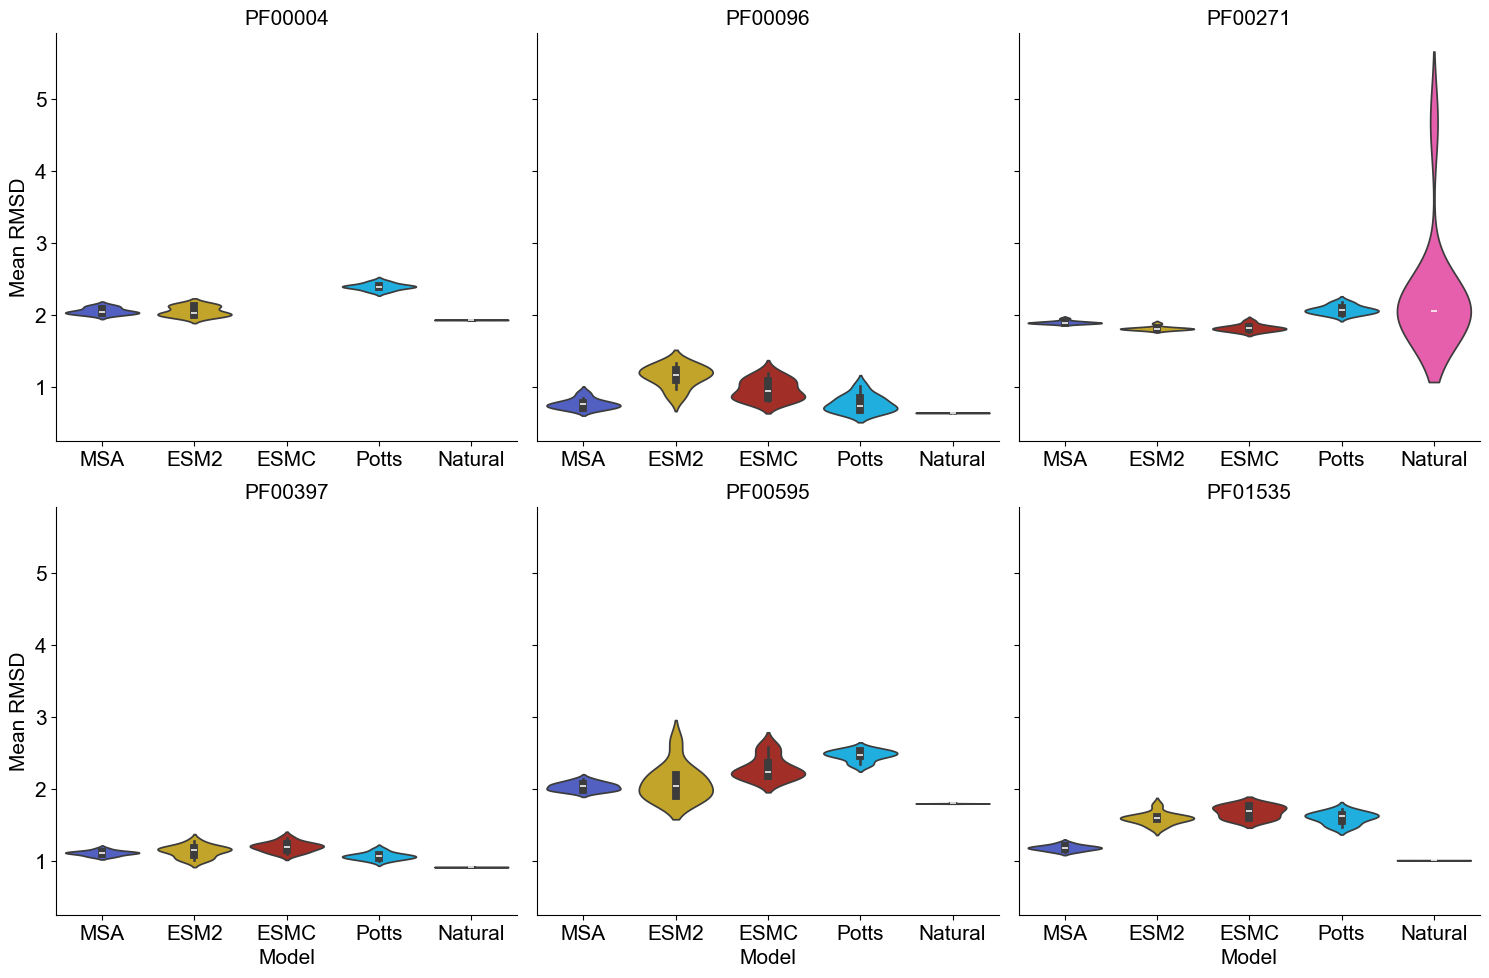

In [21]:
rcParams['figure.figsize'] = 30,10
rcParams["font.family"] = "Arial"

metric = [name for name in list(all_metrics_dataframe.columns) if name.startswith("rmsd")][0]

if "mean" in metric:
    metric_name = "Mean RMSD"
else:
    metric_name = "RMSD"

g = sns.FacetGrid(all_metrics_dataframe, col="Family", col_wrap=3, margin_titles=True, height=5, aspect= 1)
g.map_dataframe(sns.violinplot, x=x_value, y=metric, hue = hue, inner = "box", palette = palette)
# g.figure.suptitle(f"Comparison of Performance across Models ({metric})", size = 20)
# fig = sns.violinplot(data = all_metrics_dataframe, y=metric, x = "family", hue="tool", inner = None)

for i,ax in enumerate(g.axes.flat):
    ax.set_ylabel(metric_name, fontsize = 15)
    ax.set_xlabel(x_value, fontsize = 15)
    ax.tick_params(labelbottom=True, axis='both', labelsize=15)
    if i%3 == 1 and hue is not None:
        ax.legend(loc = "best", title = hue, fontsize = 15, title_fontsize=15)
    ax.set_title(ax.get_title().split(' ')[2], size = 15, )
    
plt.tight_layout()
g.figure.subplots_adjust(top=0.95)

# plt.savefig(f'{x_value}_vs_{metric}.png', bbox_inches='tight')

plt.show()


### PLDDT Scores

/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (7) than needed (5),

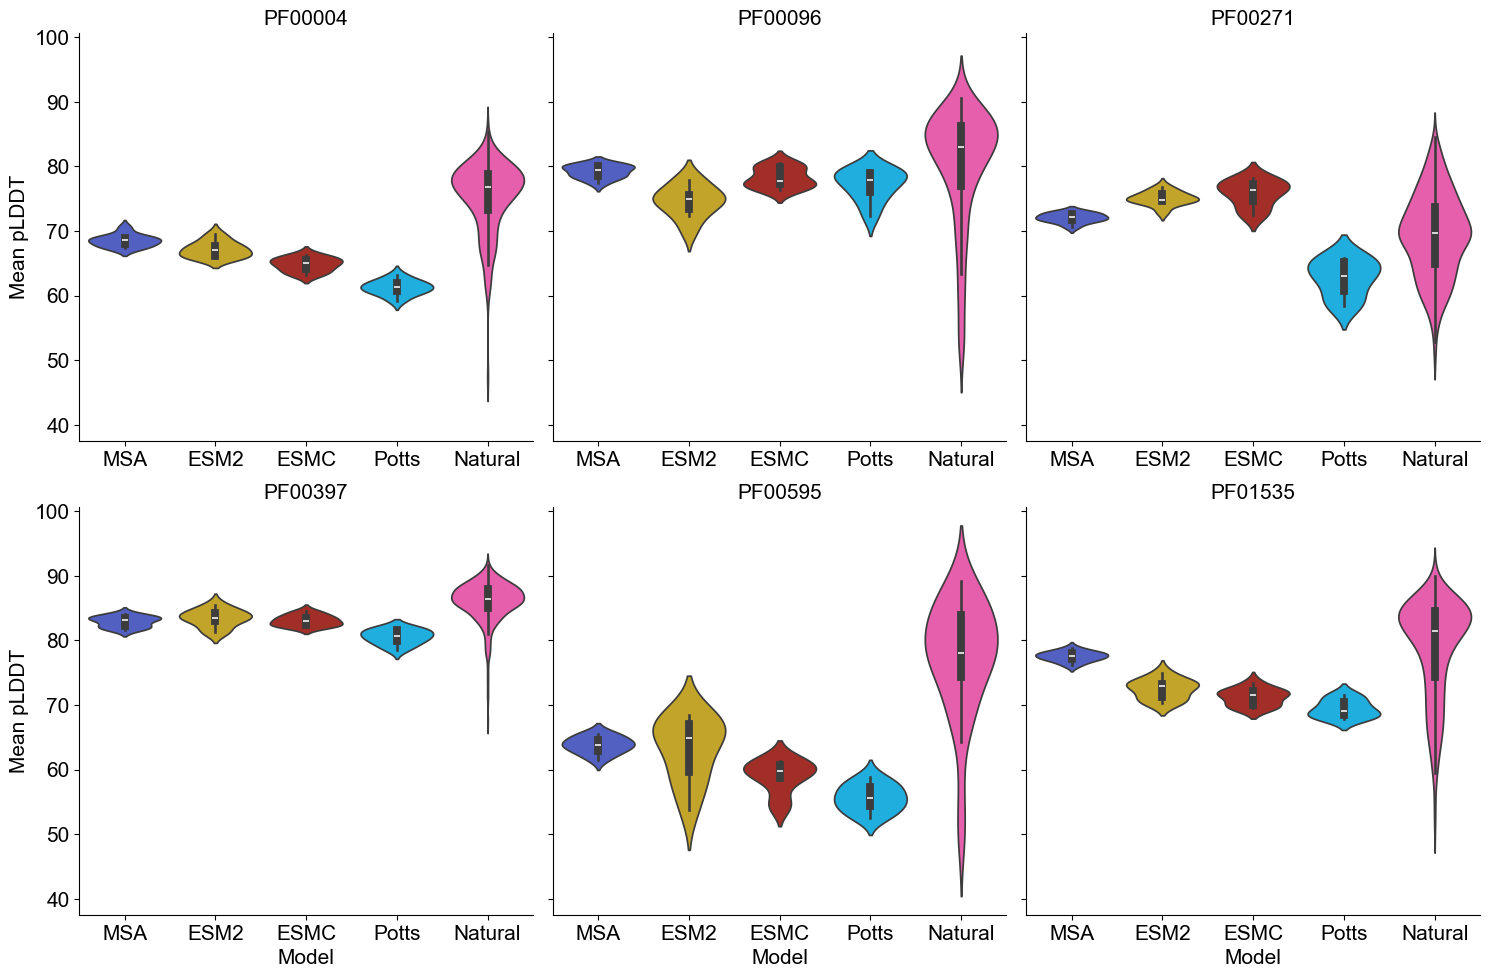

In [245]:
rcParams['figure.figsize'] = 30,10
rcParams["font.family"] = "Arial"

metric = [name for name in list(all_metrics_dataframe.columns) if name.startswith("plddt")][0]

if "mean" in metric:
    metric_name = "Mean pLDDT"
else:
    metric_name = "pLDDT"

g = sns.FacetGrid(all_metrics_dataframe, col="Family", col_wrap=3, margin_titles=True, height=5, aspect= 1)
g.map_dataframe(sns.violinplot, x=x_value, y=metric, hue = hue, inner = "box", palette = palette)
# g.figure.suptitle(f"Comparison of Performance across Models ({metric})", size = 20)
# fig = sns.violinplot(data = all_metrics_dataframe, y=metric, x = "family", hue="tool", inner = None)

for i,ax in enumerate(g.axes.flat):
    ax.set_ylabel(metric_name, fontsize = 15)
    ax.set_xlabel(x_value, fontsize = 15)
    ax.tick_params(labelbottom=True, axis='both', labelsize=15)
    if i%3 == 1 and hue is not None:
        ax.legend(loc = "best", title = hue, fontsize = 15, title_fontsize=15)
    ax.set_title(ax.get_title().split(' ')[2], size = 15, )

plt.tight_layout()
g.figure.subplots_adjust(top=0.95)

plt.savefig(f'{x_value}_vs_{metric}.png', bbox_inches='tight')

plt.show()

### HMMer Scores

/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)


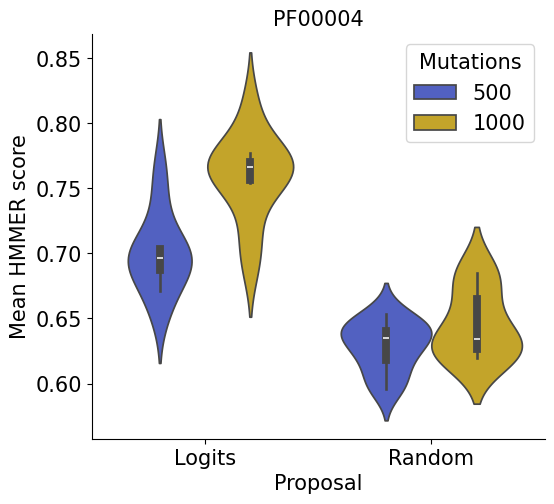

In [ ]:
rcParams['figure.figsize'] = 30,10

metric = [name for name in list(all_metrics_dataframe.columns) if name.startswith("hmmer")][1]

if "mean" in metric:
    metric_name = "Mean HMMER score"
else:
    metric_name = "HMMER score"

g = sns.FacetGrid(all_metrics_dataframe, col="Family", col_wrap=3, margin_titles=True, height=5, aspect= 1)
g.map_dataframe(sns.violinplot, x=x_value, y=metric, hue = hue, inner = "box", palette = palette)
# g.figure.suptitle(f"Comparison of Performance across Models ({metric})", size = 20)
# fig = sns.violinplot(data = all_metrics_dataframe, y=metric, x = "family", hue="tool", inner = None)

for i,ax in enumerate(g.axes.flat):
    ax.set_ylabel(metric_name, fontsize = 15)
    ax.set_xlabel(x_value, fontsize = 15)
    ax.tick_params(labelbottom=True, axis='both', labelsize=15)
    if i%3 == 0 and hue is not None:
        ax.legend(loc = "best", title = hue, fontsize = 15, title_fontsize=15)
    ax.set_title(ax.get_title().split(' ')[2], size = 15, )
    
plt.tight_layout()
g.figure.subplots_adjust(top=0.95)

plt.savefig(f'{x_value}_vs_{metric}.png', bbox_inches='tight')

plt.show()



## Statistical Energy Scores

/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)


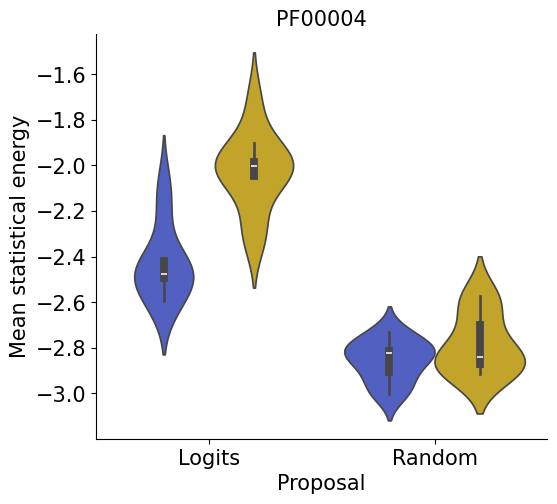

In [53]:
rcParams['figure.figsize'] = 30,10

try:
    all_metrics_non_zero = all_metrics_dataframe.loc[all_metrics_dataframe["stat_energy_scores_ESM2_ref"] > 0, :].reset_index(drop = True)
    metric = [name for name in list(all_metrics_dataframe.columns) if name.startswith("stat")][1]
    fig = sns.violinplot(data = all_metrics_non_zero, y=metric, hue="tool")
except:
    metric = [name for name in list(all_metrics_dataframe.columns) if name.startswith("stat")][1]

if "mean" in metric:
    metric_name = "Mean statistical energy"
else:
    metric_name = "Statistical energy"

g = sns.FacetGrid(all_metrics_dataframe, col="Family", col_wrap=3, margin_titles=True, height=5, aspect= 1)
g.map_dataframe(sns.violinplot, x=x_value, y=metric, hue = hue, inner = "box", palette = palette)
# g.figure.suptitle(f"Comparison of Performance across Models ({metric})", size = 20)
# fig = sns.violinplot(data = all_metrics_dataframe, y=metric, x = "family", hue="tool", inner = None)

for i,ax in enumerate(g.axes.flat):
    ax.set_ylabel(metric_name, fontsize = 15)
    ax.set_xlabel(x_value, fontsize = 15)
    ax.tick_params(labelbottom=True, axis='both', labelsize=15)
    if i%3 == 1 and hue is not None:
        ax.legend(loc = "best", title = hue, fontsize = 15, title_fontsize=15)
    ax.set_title(ax.get_title().split(' ')[2], size = 15, )

plt.tight_layout()
g.figure.subplots_adjust(top=0.95)

plt.savefig(f'{x_value}_vs_{metric}_no_phylo.png', bbox_inches='tight')

plt.show()

## Average Minimum Distance to a Natural Sequence

/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)


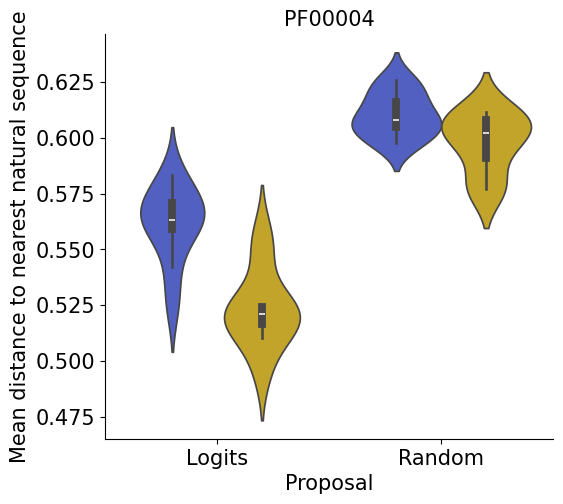

In [54]:
rcParams['figure.figsize'] = 30,10

metric = [name for name in list(all_metrics_dataframe.columns) if name.startswith("min_natural")][0]

nat_tool = [tool for tool in list(all_metrics_dataframe["Tool"].unique()) if tool.startswith("nat") or tool.startswith("init")]

all_metrics_dataframe_no_nat = all_metrics_dataframe.loc[all_metrics_dataframe["Tool"] != nat_tool[0], :].reset_index(drop = True)
all_metrics_dataframe_no_nat = all_metrics_dataframe_no_nat.loc[all_metrics_dataframe_no_nat["Tool"] != nat_tool[1], :].reset_index(drop = True)

if "mean" in metric:
    metric_name = "Mean distance to nearest natural sequence"
else:
    metric_name = "Distance to nearest natural sequence"

g = sns.FacetGrid(all_metrics_dataframe_no_nat, col="Family", col_wrap=3, margin_titles=True, height=5, aspect= 1)
g.map_dataframe(sns.violinplot, x=x_value, y=metric, hue = hue, inner = "box", palette = palette)
# g.figure.suptitle(f"Comparison of Performance across Models ({metric})", size = 20)
# fig = sns.violinplot(data = all_metrics_dataframe, y=metric, x = "family", hue="tool", inner = None)

for i,ax in enumerate(g.axes.flat):
    ax.set_ylabel(metric_name, fontsize = 15)
    ax.set_xlabel(x_value, fontsize = 15)
    ax.tick_params(labelbottom=True, axis='both', labelsize=15)
    if i%3 == 1 and hue is not None:
        ax.legend(loc = "best", title = hue, fontsize = 15, title_fontsize=15)
    ax.set_title(ax.get_title().split(' ')[2], size = 15, )

plt.tight_layout()
g.figure.subplots_adjust(top=0.95)

plt.savefig(f'{x_value}_vs_{metric}_no_phylo.png', bbox_inches='tight')

plt.show()

## Average Maximum Distance within an MSA

/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (7) than needed (2), which may not be intended.
  func(*plot_args, **plot_kwargs)


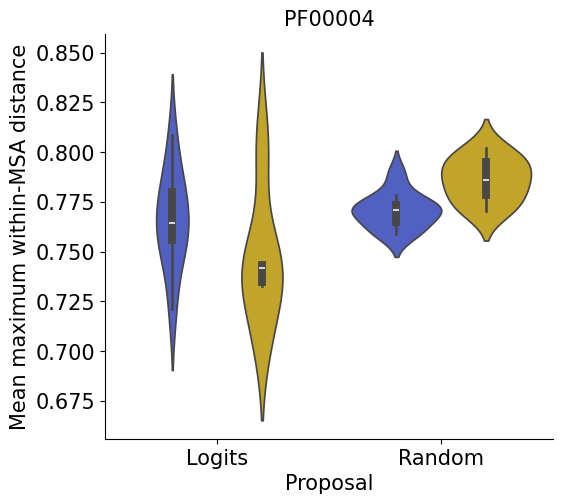

In [ ]:
rcParams['figure.figsize'] = 30, 10

metric = [name for name in list(all_metrics_dataframe.columns) if name.startswith("max_self")][0]

if "mean" in metric:
    metric_name = "Mean maximum within-MSA distance"
else:
    metric_name = "Maximum within-MSA distance"

g = sns.FacetGrid(all_metrics_dataframe, col="Family", col_wrap=3, margin_titles=True, height=5, aspect= 1)
g.map_dataframe(sns.violinplot, x=x_value, y=metric, hue = hue, inner = "box", palette = palette)
# g.figure.suptitle(f"Comparison of Performance across Models ({metric})", size = 20)
# fig = sns.violinplot(data = all_metrics_dataframe, y=metric, x = "family", hue="tool", inner = None)

for i,ax in enumerate(g.axes.flat):
    ax.set_ylabel(metric_name, fontsize = 15)
    ax.set_xlabel(x_value, fontsize = 15)
    ax.tick_params(labelbottom=True, axis='both', labelsize=15)
    if i%3 == 1 and hue is not None:
        ax.legend(loc = "best", title = hue, fontsize = 15, title_fontsize=15)
    ax.set_title(ax.get_title().split(' ')[2], size = 15, )
plt.tight_layout()
g.figure.subplots_adjust(top=0.95)

plt.savefig(f'{x_value}_vs_{metric}.png', bbox_inches='tight')

plt.show()

### Tree Metrics - Normalized RF

/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (7) than needed (5),

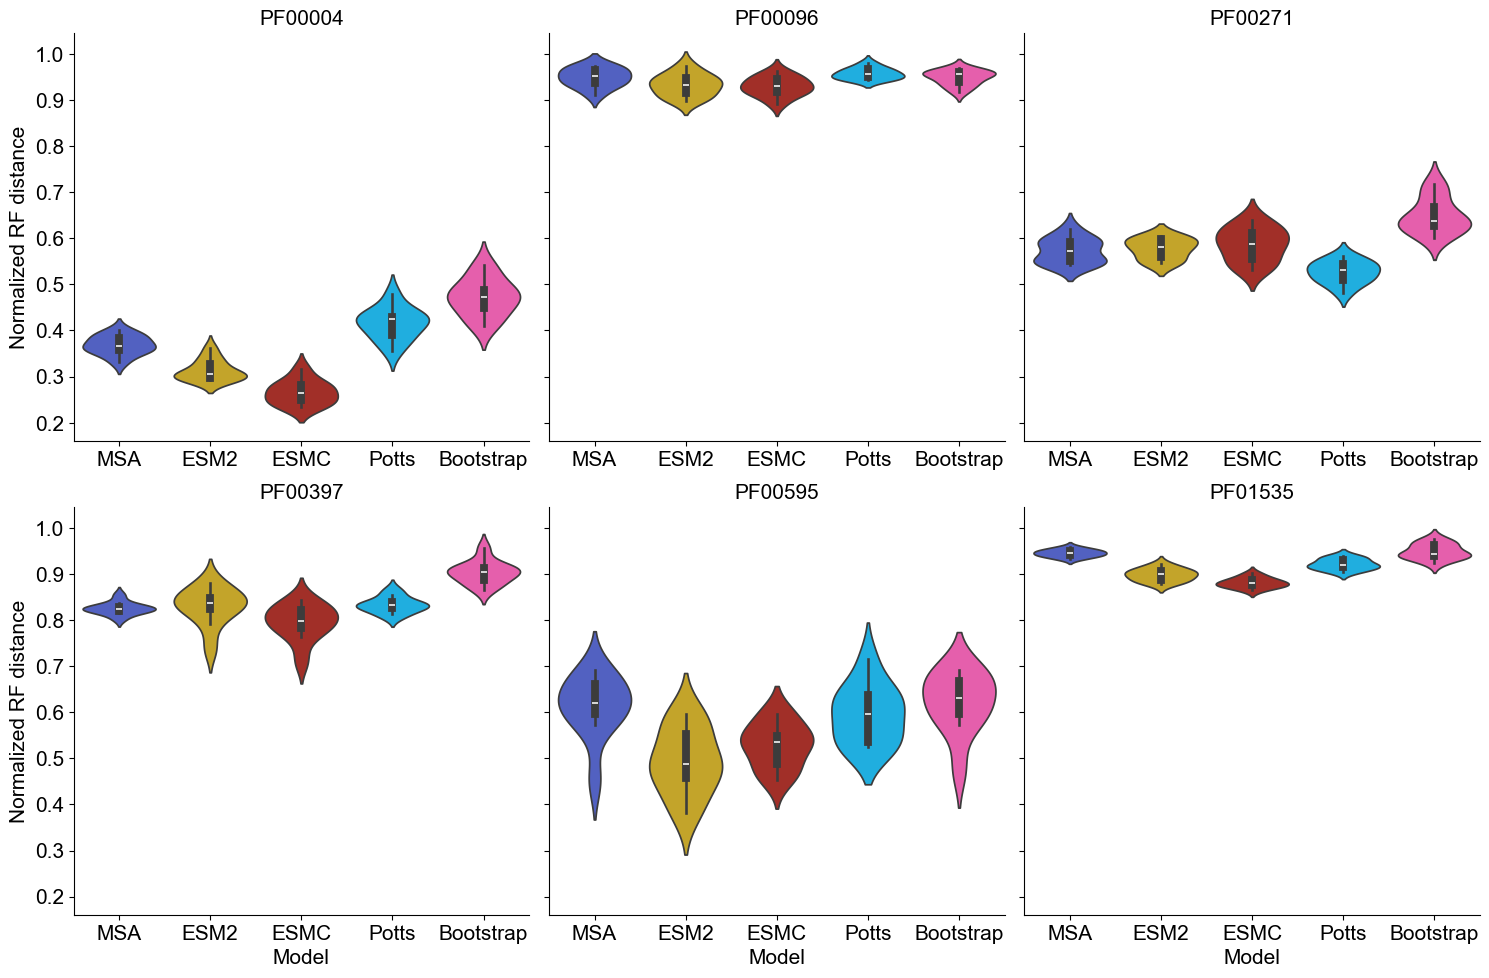

In [226]:
rcParams['figure.figsize'] = 35,10

metric = [name for name in list(tree_metrics_dataframe.columns) if name.startswith("norm")][0]

metric_name = "Normalized RF distance"

g = sns.FacetGrid(tree_metrics_dataframe, col="Family", col_wrap=3, margin_titles=True, height=5, aspect= 1)
g.map_dataframe(sns.violinplot, x=x_value, y=metric, hue = hue, inner = "box", palette = palette)
# g.figure.suptitle(f"Comparison of Performance across Models ({metric})", size = 20)
# fig = sns.violinplot(data = all_metrics_dataframe, y=metric, x = "family", hue="tool", inner = None)

for i,ax in enumerate(g.axes.flat):
    ax.set_ylabel(metric_name, fontsize = 15)
    ax.set_xlabel(x_value, fontsize = 15)
    ax.tick_params(labelbottom=True, axis='both', labelsize=15)
    if i%3 == 1 and hue is not None:
        ax.legend(loc = "best", title = hue, fontsize = 15, title_fontsize=15)
    ax.set_title(ax.get_title().split(' ')[2], size = 15, )
plt.tight_layout()
g.figure.subplots_adjust(top=0.95)

plt.savefig(f'{x_value}_vs_{metric}.png', bbox_inches='tight')

plt.show()

### Tree Metrics - MAE

/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (7) than needed (5),

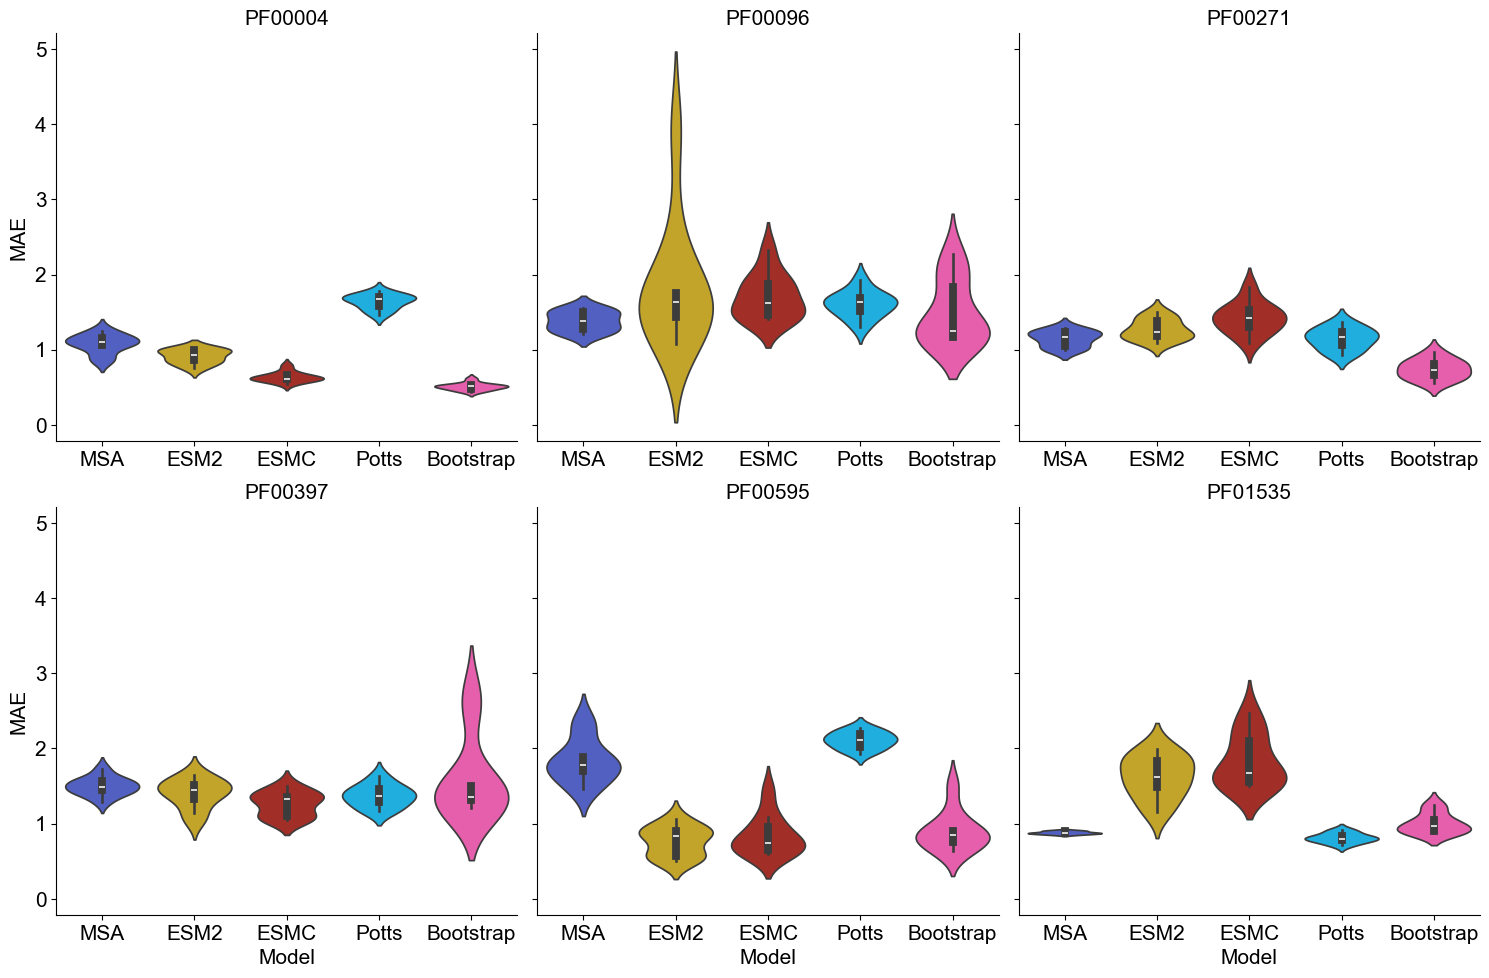

In [233]:
rcParams['figure.figsize'] = 35,10

metric = [name for name in list(tree_metrics_dataframe.columns) if name.startswith("MAE")][0]

metric_name = "MAE"

g = sns.FacetGrid(tree_metrics_dataframe, col="Family", col_wrap=3, margin_titles=True, height=5, aspect= 1)
g.map_dataframe(sns.violinplot, x=x_value, y=metric, hue = hue, inner = "box", palette = palette)
# g.figure.suptitle(f"Comparison of Performance across Models ({metric})", size = 20)
# fig = sns.violinplot(data = all_metrics_dataframe, y=metric, x = "family", hue="tool", inner = None)

for i,ax in enumerate(g.axes.flat):
    ax.set_ylabel(metric_name, fontsize = 15)
    ax.set_xlabel(x_value, fontsize = 15)
    ax.tick_params(labelbottom=True, axis='both', labelsize=15)
    if i%3 == 1 and hue is not None:
        ax.legend(loc = "best", title = hue, fontsize = 15, title_fontsize=15)
    ax.set_title(ax.get_title().split(' ')[2], size = 15, )
plt.tight_layout()
g.figure.subplots_adjust(top=0.95)

plt.savefig(f'{x_value}_vs_{metric}.png', bbox_inches='tight')

plt.show()

### Tree Metrics - KF Distance

/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (7) than needed (5),

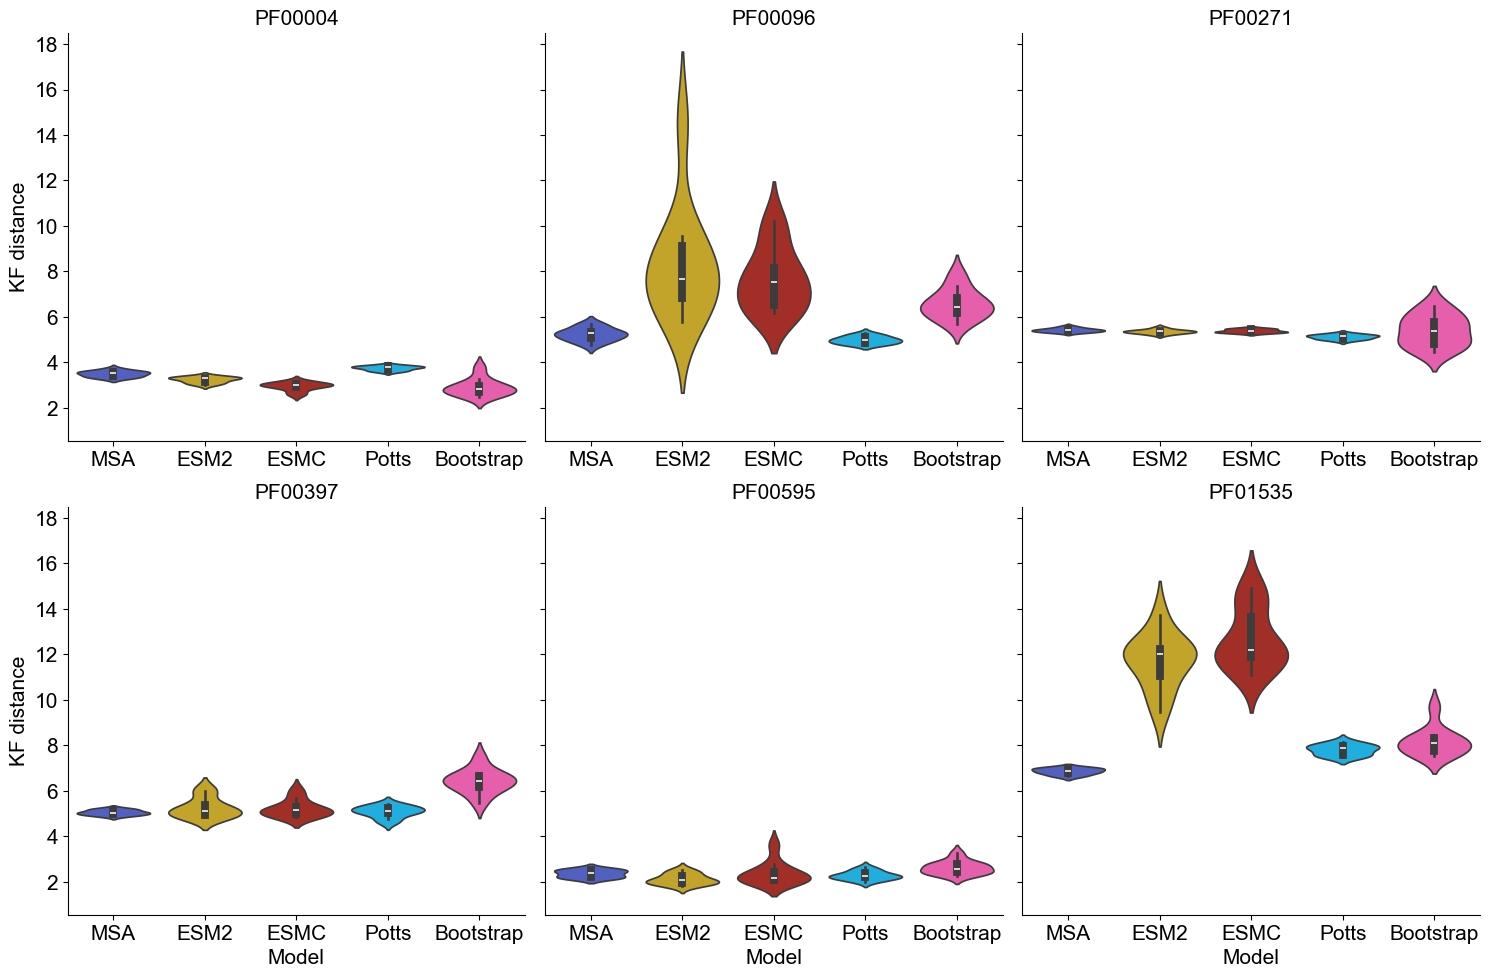

In [234]:
rcParams['figure.figsize'] = 35,10

metric = [name for name in list(tree_metrics_dataframe.columns) if name.startswith("kf")][0]

metric_name = "KF distance"

g = sns.FacetGrid(tree_metrics_dataframe, col="Family", col_wrap=3, margin_titles=True, height=5, aspect= 1)
g.map_dataframe(sns.violinplot, x=x_value, y=metric, hue = hue, inner = "box", palette = palette)
# g.figure.suptitle(f"Comparison of Performance across Models ({metric})", size = 20)
# fig = sns.violinplot(data = all_metrics_dataframe, y=metric, x = "family", hue="tool", inner = None)

for i,ax in enumerate(g.axes.flat):
    ax.set_ylabel(metric_name, fontsize = 15)
    ax.set_xlabel(x_value, fontsize = 15)
    ax.tick_params(labelbottom=True, axis='both', labelsize=15)
    if i%3 == 1 and hue is not None:
        ax.legend(loc = "best", title = hue, fontsize = 15, title_fontsize=15)
    ax.set_title(ax.get_title().split(' ')[2], size = 15, )
plt.tight_layout()
g.figure.subplots_adjust(top=0.95)

plt.savefig(f'{x_value}_vs_{metric}.png', bbox_inches='tight')

plt.show()

### Tree Metrics - Median Clade Support

/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (7) than needed (5), which may not be intended.
  func(*plot_args, **plot_kwargs)
/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/samant/miniconda/envs/msa-explore/lib/python3.8/site-packages/seaborn/axisgrid.py:854: UserWarning: The palette list has more values (7) than needed (5),

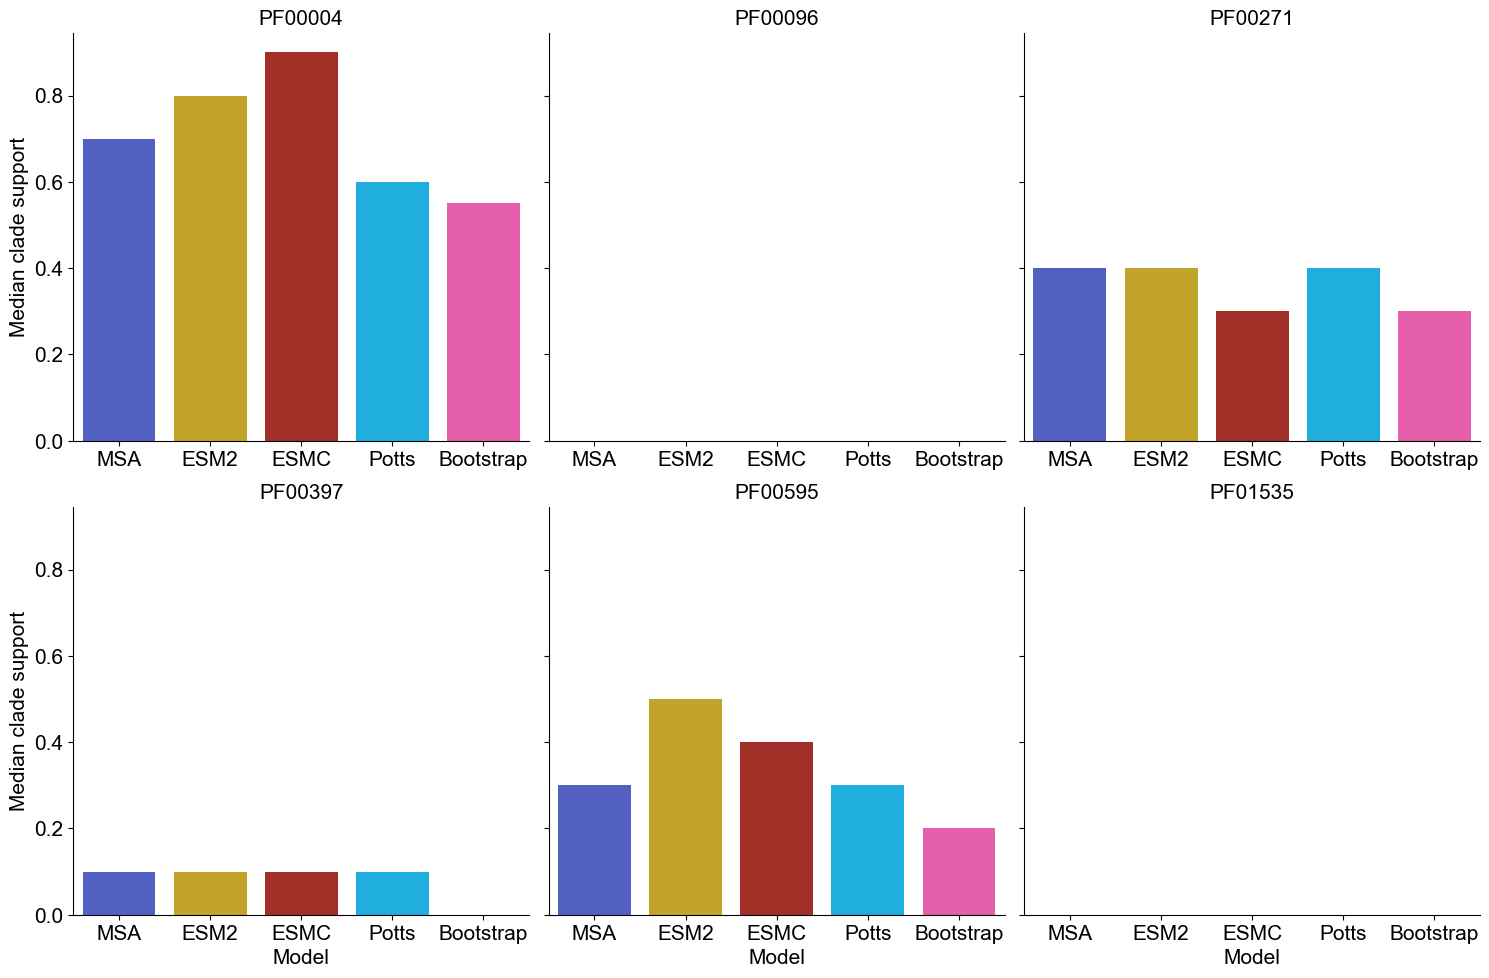

In [236]:
rcParams['figure.figsize'] = 30,10

metric = [name for name in list(tree_metrics_dataframe.columns) if name.startswith("median")][0]

metric_name = "Median clade support"

g = sns.FacetGrid(tree_metrics_dataframe, col="Family", col_wrap=3, margin_titles=True, height=5, aspect= 1)
g.map_dataframe(sns.barplot, x=x_value, y=metric, hue = hue, palette = palette)
# g.figure.suptitle(f"Comparison of Performance across Models ({metric})", size = 20)
# fig = sns.violinplot(data = all_metrics_dataframe, y=metric, x = "family", hue="tool", inner = None)

for i,ax in enumerate(g.axes.flat):
    ax.set_ylabel(metric_name, fontsize = 15)
    ax.set_xlabel(x_value, fontsize = 15)
    ax.tick_params(labelbottom=True, axis='both', labelsize=15)
    if i%3 == 1 and hue is not None:
        ax.legend(loc = "best", title = hue, fontsize = 15, title_fontsize=15)
    ax.set_title(ax.get_title().split(' ')[2], size = 15, )
plt.tight_layout()
g.figure.subplots_adjust(top=0.95)

plt.savefig(f'{x_value}_vs_{metric}.png', bbox_inches='tight')

plt.show()

### HMMer Convergence

In [61]:
hmmer_data = pd.read_csv("./figures/PF00004/hmmer_convergence/seed_8/hmmer_convergence_seed_8_20000_muts.tsv", sep = "\t")
hmmer_data.loc[hmmer_data["proposal_type"] == "msa_prob_dist", "proposal_type"] = "logits"
hmmer_data["proposal_type"] = hmmer_data["proposal_type"].apply(lambda x: x.capitalize())

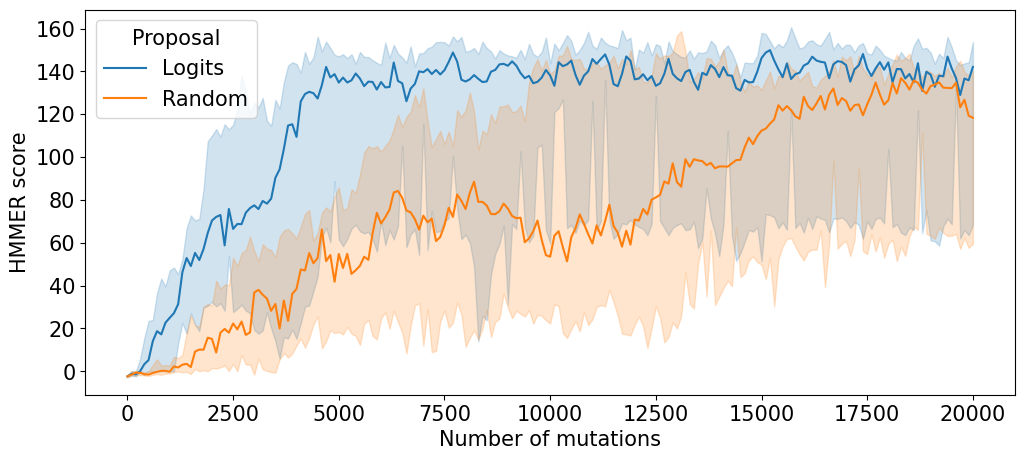

In [65]:
fig, axes = plt.subplots(figsize = (12,5)) 

sns.lineplot(data = hmmer_data, x ="n_mutations", y = "hmmer_seq_score", hue = "proposal_type", estimator="median", ax = axes)

axes.set_ylabel("HMMER score", fontsize = 15)
axes.set_xlabel("Number of mutations", fontsize = 15)
axes.tick_params(labelbottom=True, axis='both', labelsize=15)
axes.legend(loc = "best", title = "Proposal", fontsize = 15, title_fontsize = 15)
# axes.set_title("Growth of HMMer Score with MSA-guided mutations", size = 20)

plt.savefig('hmmer_covergence.jpeg')




### State-Space Exploration


In [39]:
n_sequences = 100

MI_decay_values_folder_logitsprop = f"other-analyses/MI_decay_MSAs/20-mutation-interval/{n_sequences}-sequences/100-rounds/msa-seed-simulations/MSA-1b/init-seq-sampled/logits-proposal/context-size-10/PF00004/"
MI_decay_values_folder_randomprop = f"other-analyses/MI_decay_MSAs/20-mutation-interval/{n_sequences}-sequences/100-rounds/msa-seed-simulations/MSA-1b/init-seq-sampled/random-proposal/context-size-10/PF00004/"

folder_paths = [MI_decay_values_folder_logitsprop, MI_decay_values_folder_randomprop]

seed_MSA = "data/protein-families-msa-seed/PF00004_seed.fasta"
seed_MSA = [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(seed_MSA, "fasta")]

np.random.seed(42)

state_space_counter = []



for k,MI_decay_values_folder in enumerate(folder_paths):

    if k == 0:
        proposal_type = "logits"
    else:
        proposal_type = "random"

    for file in os.listdir(MI_decay_values_folder):
        
        
        if os.path.isdir(os.path.join(MI_decay_values_folder, file)):
            continue

        sim_ind = int(file.split(".")[-2].split("-")[-1])

        sim_df = pd.read_csv(os.path.join(MI_decay_values_folder, file), delimiter = "\t")

        n_mutations_list = list(sim_df["n_mutations"].unique())
        max_mutations = sim_df["n_mutations"].max()

        sim_df_end = sim_df.loc[sim_df["n_mutations"] == max_mutations, :]
        sim_df_ref = sim_df.loc[sim_df["n_mutations"] == 0, :]

        sim_array_end = pd.DataFrame([list(seq) for seq in sim_df_end["sequence"]])
        sim_array_ref = pd.DataFrame([list(seq) for seq in sim_df_ref["sequence"]])
        
        for i in range(sim_array_ref.shape[1]):
                
                num_states_df = pd.DataFrame({"column_1":list(sim_array_ref.iloc[:,i]), "column_2":list(sim_array_end.iloc[:,i])})
                
                num_states = len(num_states_df.drop_duplicates())
                state_space_counter.append({"proposal_type":proposal_type, "sim_ind":sim_ind, "column_number":i,"number_of_observed_states":num_states})

state_space_counter = pd.DataFrame(state_space_counter)

nat_state_space_counter = []

for j in range(10):

    random_ind = list(np.random.choice(range(1,len(seed_MSA)),n_sequences, replace = False))
    rand_MSA_1 = [seed_MSA[i] for i in random_ind]

    random_ind = list(np.random.choice(range(1,len(seed_MSA)),n_sequences, replace = False))
    rand_MSA_2 = [seed_MSA[i] for i in random_ind]

    sim_array_1 = pd.DataFrame([list(seq[1]) for seq in rand_MSA_1]) 
    sim_array_2 = pd.DataFrame([list(seq[1]) for seq in rand_MSA_2]) 

    for i in range(sim_array_1.shape[1]):
               
        num_states_df = pd.DataFrame({"column_1":list(sim_array_1.iloc[:,i]), "column_2":list(sim_array_2.iloc[:,i])})         
        num_states = len(num_states_df.drop_duplicates())
        nat_state_space_counter.append({"proposal_type":"natural", "sim_ind":j + 1, "column_number":i,"number_of_observed_states":num_states})

nat_state_space_counter = pd.DataFrame(nat_state_space_counter)

<Axes: xlabel='number_of_observed_states', ylabel='Count'>

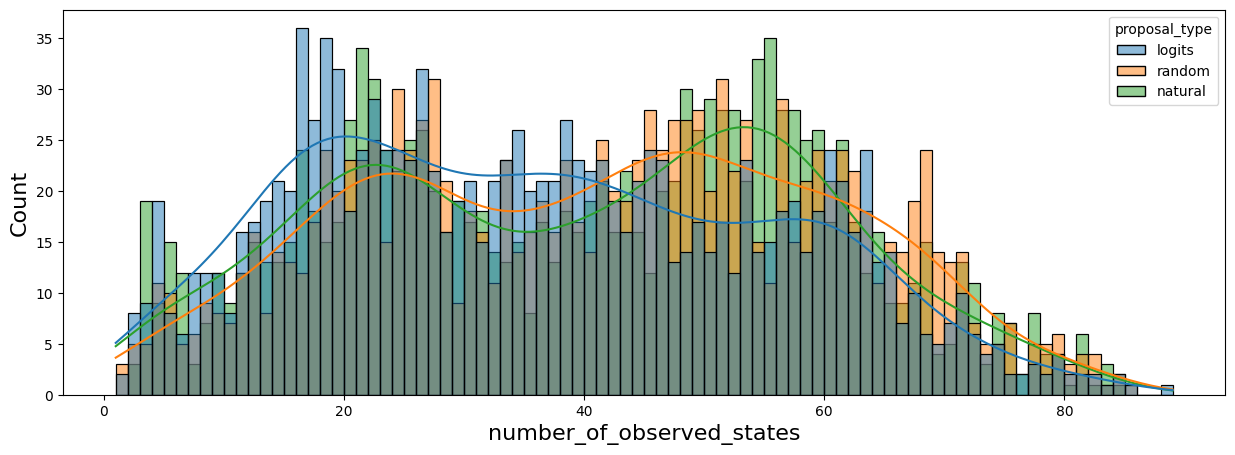

In [94]:
fig, axes = plt.subplots(1,1, figsize = (15,5))

all_data = pd.concat([state_space_counter, nat_state_space_counter]).reset_index(drop = True)

sim_ind = 1
all_data_sim = all_data.loc[all_data["sim_ind"] == sim_ind, :].reset_index(drop = True)

sns.histplot(x="number_of_observed_states", hue="proposal_type", data=all_data, binwidth=1, kde=True)


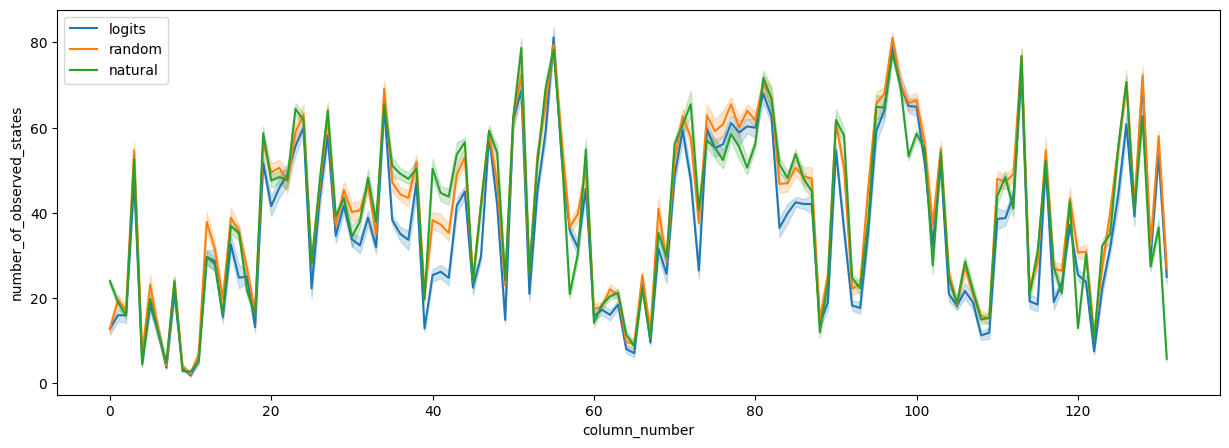

In [32]:
fig, axes = plt.subplots(1,1, figsize = (15,5))

sns.lineplot(data=state_space_counter, x="column_number",y = "number_of_observed_states",hue="proposal_type", ax=axes)
sns.lineplot(data=nat_state_space_counter, x="column_number",y = "number_of_observed_states", ax=axes, label="natural")

plt.legend()

In [25]:
n_sequences = 100

MI_decay_values_folder_logitsprop = f"data/MI_decay_MSAs/20-mutation-interval/{n_sequences}-sequences/100-rounds/msa-seed-simulations/MSA-1b/init-seq-sampled/logits-proposal/context-size-10/PF00004/"
MI_decay_values_folder_randomprop = f"data/MI_decay_MSAs/20-mutation-interval/{n_sequences}-sequences/100-rounds/msa-seed-simulations/MSA-1b/init-seq-sampled/random-proposal/context-size-10/PF00004/"

folder_paths = [MI_decay_values_folder_logitsprop, MI_decay_values_folder_randomprop]

seed_MSA = "data/protein-families-msa-seed/PF00004_seed.fasta"
seed_MSA = [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(seed_MSA, "fasta")]

np.random.seed(42)

state_space_counter = []


for k,MI_decay_values_folder in enumerate(folder_paths):

    if k == 0:
        proposal_type = "logits"
    else:
        proposal_type = "random"

    for file in os.listdir(MI_decay_values_folder):
        
        
        if os.path.isdir(os.path.join(MI_decay_values_folder, file)):
            continue

        sim_ind = int(file.split(".")[-2].split("-")[-1])

        sim_df = pd.read_csv(os.path.join(MI_decay_values_folder, file), delimiter = "\t")

        sim_df_ref = sim_df.loc[sim_df["n_mutations"] == 0, :]
        sim_array_ref = pd.DataFrame([list(seq) for seq in sim_df_ref["sequence"]])

        n_mutations_list = list(sim_df["n_mutations"].unique())

        for n_mutation in n_mutations_list:

            sim_df_cur = sim_df.loc[sim_df["n_mutations"] == n_mutation, :]
            
            sim_array_cur = pd.DataFrame([list(seq) for seq in sim_df_cur["sequence"]])
            
            for i in range(sim_array_ref.shape[1]):
                    
                    num_states_df = pd.DataFrame({"column_1":list(sim_array_ref.iloc[:,i]), "column_2":list(sim_array_cur.iloc[:,i])})
                    num_states = len(num_states_df.drop_duplicates())
                    state_space_counter.append({"proposal_type":proposal_type, "sim_ind":sim_ind, "column_number":i,"n_mutations":n_mutation, "number_of_observed_states":num_states})

state_space_counter = pd.DataFrame(state_space_counter)

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (15,5))

column_number = 128

state_space_counter_col = state_space_counter.loc[state_space_counter["column_number"] == column_number, :]
nat_state_space_counter_col = nat_state_space_counter.loc[nat_state_space_counter["column_number"] == column_number, :]

nat_state_space_counter_col_mean = nat_state_space_counter_col["number_of_observed_states"].mean()
nat_state_space_counter_col_err = nat_state_space_counter_col["number_of_observed_states"].std()

sns.lineplot(data=state_space_counter, x="n_mutations",y = "number_of_observed_states",hue="proposal_type", ax=axes)
axes.errorbar(x=[0,max_mutations], y = 2 *[nat_state_space_counter_col_mean], yerr = nat_state_space_counter_col_err, label = "natural", linestyle = "--", )

plt.legend()

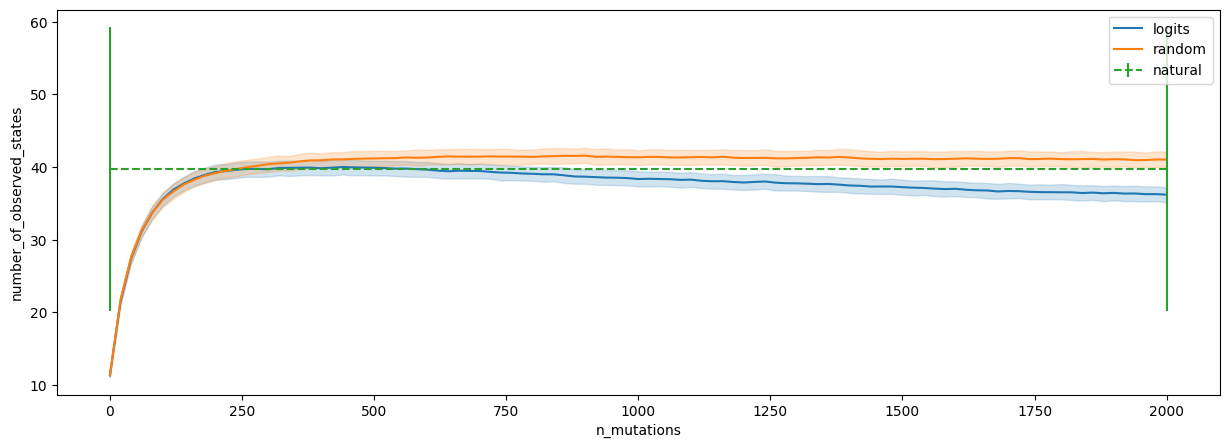

In [ ]:
fig, axes = plt.subplots(1,1, figsize = (15,5))


nat_state_space_counter_mean = nat_state_space_counter["number_of_observed_states"].mean()
nat_state_space_counter_std = nat_state_space_counter["number_of_observed_states"].std()

sns.lineplot(data=state_space_counter, x="n_mutations",y = "number_of_observed_states",hue="proposal_type", ax=axes, estimator="median")
axes.errorbar(x=[0,max_mutations], y = 2 *[nat_state_space_counter_mean], yerr = nat_state_space_counter_std, label = "natural", linestyle = "--", )

plt.legend()

In [ ]:
family = "PF00004"

## Shannon Entropy Comparison (Simulated Vs Natural)

In [21]:
tool_types

['MSA-1b_logits_static_10_init-seq-0',
 'ESM2-33T-650M-logits',
 'ESMC-logits',
 'Potts',
 'nat',
 'nat-bootstrap']

In [22]:
model_order

['MSA', 'ESM2', 'ESMC', 'Potts', 'Natural', 'Natural']

In [23]:
scores_folders

['./scores/msa-seed-simulations/MSA-1b/PF00004/init-seq-0/logits-proposal/static-context/10/',
 './scores/msa-seed-simulations/ESM2-33T-650M/PF00004/init-seq-0/logits-proposal/',
 './scores/msa-seed-simulations/ESMC/PF00004/init-seq-0/logits-proposal/',
 './scores/msa-seed-simulations/Potts/PF00004/init-seq-0/',
 './scores/protein-families-msa-seed/PF00004/',
 './scores/sequences-bootstrap-seed-msa/PF00004/']

In [65]:
from scipy.stats import entropy

se_dataframe = pd.DataFrame(columns=["tool","sim_ind","column_number","shannon_entropy_sim","shannon_entropy_corr_nat"])

for j,folder in enumerate(scores_folders):

    family = re.findall("PF[0-9]{5}",folder)[0]
        
    for i,file in enumerate(os.listdir(folder)):

        if tool_types[j].startswith("nat"):
            continue

        if not tool_types[j].startswith("nat") and tool_types[j] != "full_sampling":
            file_sim_ind = file.split('.')[0]
            file_sim_ind = int(file_sim_ind.split('-')[1])
        else:
            file_sim_ind = 1
            
        file_path = os.path.join(folder,file)
        dist_dataframe = pd.DataFrame()
        
        df = pd.read_csv(file_path, delimiter="\t") 
        
        sim_array = pd.DataFrame([list(seq) for seq in df["sequence"]]) 
        nat_array = pd.DataFrame([list(seq) for seq in df["corr_nat_seq"]])

        entropy_df = []

        for k in range(sim_array.shape[1]):

            entropy_sim = entropy(sim_array.iloc[:,k].value_counts())
            entropy_nat = entropy(nat_array.iloc[:,k].value_counts())

            entropy_df.append({"tool":tool_types[j],"sim_ind": file_sim_ind, "column_number": k + 1, 
                               "shannon_entropy_sim":entropy_sim,"shannon_entropy_corr_nat":entropy_nat}) 

        entropy_df = pd.DataFrame(entropy_df)

        se_dataframe = pd.concat((se_dataframe, entropy_df)).reset_index(drop=True)

se_dataframe_stats = se_dataframe.groupby(["tool","column_number"]).describe().reset_index()
se_dataframe_stats.columns = ["tool","column_number"] + [f"{tup1}_{tup2}" for tup1, tup2 in list(se_dataframe_stats.columns)[2:]]
se_dataframe_stats = se_dataframe_stats.iloc[:,:12].drop("shannon_entropy_corr_nat_count", axis = 1).rename(columns  = {"shannon_entropy_corr_nat_mean":"shannon_entropy_corr_nat"})

/tmp/ipykernel_1915070/294558135.py:44: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = "shannon_entropy_sim_mean", y = "shannon_entropy_corr_nat",
/tmp/ipykernel_1915070/294558135.py:44: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = "shannon_entropy_sim_mean", y = "shannon_entropy_corr_nat",
/tmp/ipykernel_1915070/294558135.py:44: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = "shannon_entropy_sim_mean", y = "shannon_entropy_corr_nat",
/tmp/ipykernel_1915070/294558135.py:44: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x = "shannon_entropy_sim_mean", y = "shannon_entropy_corr_nat",


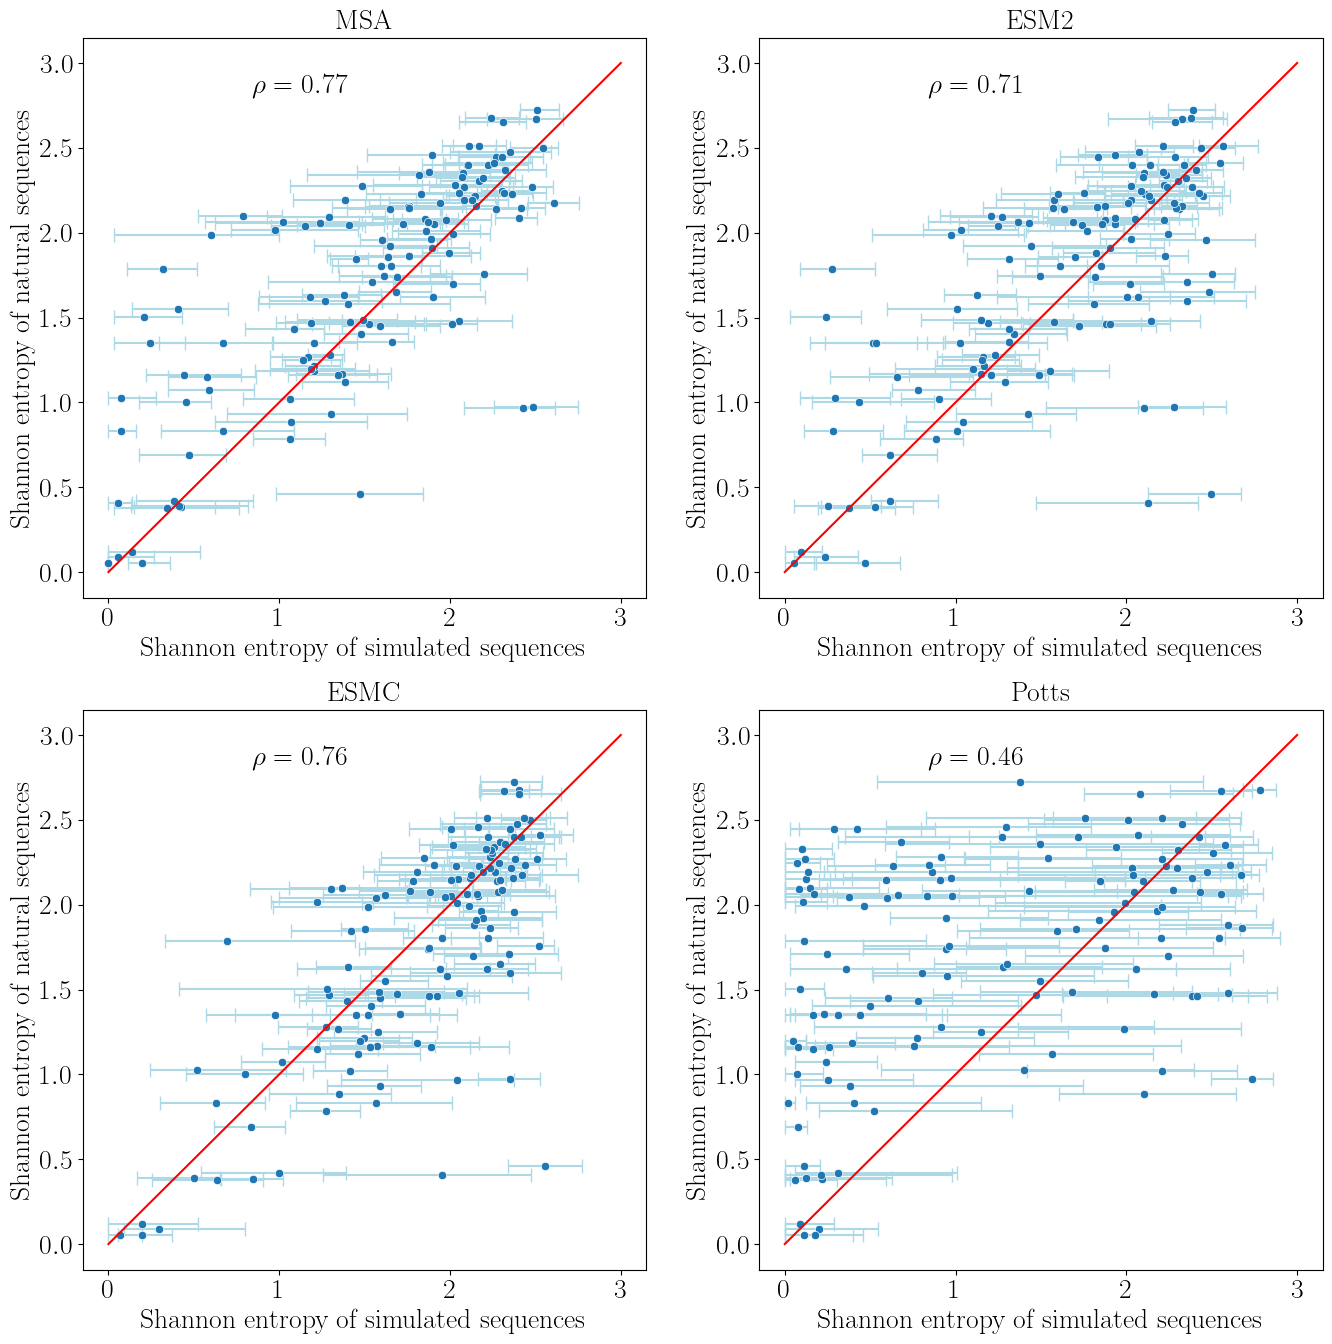

In [66]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from math import floor,ceil
import seaborn as sns

rcParams["font.family"] = "Arial"

plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=16)
plt.rcParams['text.usetex'] = True

ncols = 2
nrows = max(2,int(ceil((len(tool_types) - 1)/3)))

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (8 * ncols,8 * nrows))

for k in range(len(tool_types)):

    if tool_types[k].startswith("nat"):
        continue

    i = floor(k/ncols)
    j = k % ncols

    main_dataframe_tool_sim_stats = se_dataframe_stats.loc[(se_dataframe_stats["tool"] == tool_types[k]), :]

    xerr_min = main_dataframe_tool_sim_stats["shannon_entropy_sim_mean"] - main_dataframe_tool_sim_stats["shannon_entropy_sim_min"]
    xerr_max = main_dataframe_tool_sim_stats["shannon_entropy_sim_max"] - main_dataframe_tool_sim_stats["shannon_entropy_sim_mean"]
    std_dev = main_dataframe_tool_sim_stats["shannon_entropy_sim_std"].copy()

    axes[i][j].errorbar(main_dataframe_tool_sim_stats["shannon_entropy_sim_mean"], main_dataframe_tool_sim_stats["shannon_entropy_corr_nat"],
                      xerr = [xerr_min,xerr_max], fmt = "none", ecolor = "lightblue",  capsize = 5, zorder = 1)
    
    axes[i][j].plot([0,3],[0,3],'r-')
    axes[i][j].set_title(model_order[k], fontsize = 20)
    axes[i][j].set_xlabel("Shannon entropy of simulated sequences", fontsize = 20)
    axes[i][j].set_ylabel("Shannon entropy of natural sequences", fontsize = 20)
    pearson_corr = pearsonr(main_dataframe_tool_sim_stats["shannon_entropy_sim_mean"], main_dataframe_tool_sim_stats["shannon_entropy_corr_nat"])
    axes[i][j].annotate(r'$\rho = {:.2f}$'.format(pearson_corr.statistic),xy = (0.3,0.9), xycoords = "axes fraction", fontsize = 20)
    axes[i][j].tick_params(axis ="both", labelsize = 20)



    sns.scatterplot(x = "shannon_entropy_sim_mean", y = "shannon_entropy_corr_nat", 
                               data = main_dataframe_tool_sim_stats, palette = "viridis", ax=axes[i][j], alpha = 1)

plt.savefig(f"shannon_entropy_scatterplots_error_bars_{protein_families[0]}.png")

## Mutual Information

In [69]:
from sklearn.metrics import mutual_info_score
from tqdm.notebook import tqdm, trange

mi_dataframe = pd.DataFrame(columns=["tool","sim_ind","column_numbers","mi_sim","mi_nat"])
sim_ind = 1

for j,folder in enumerate(scores_folders):

    files_list = os.listdir(folder)
    
    for i,file in tqdm(enumerate(files_list)):

        if  not tool_types[j].startswith("nat") and tool_types[j] != "full_sampling":
            file_sim_ind = file.split('.')[0]
            file_sim_ind = int(file_sim_ind.split('-')[1])
        else:
            file_sim_ind = sim_ind

        if tool_types[j].startswith("nat"):
            continue
        
        if file_sim_ind != sim_ind:
            continue
            
        file_path = os.path.join(folder,file)
        dist_dataframe = pd.DataFrame()
        
        df = pd.read_csv(file_path, delimiter="\t") 
        
        sim_array = pd.DataFrame([list(seq) for seq in df["sequence"]]) 
        nat_array = pd.DataFrame([list(seq) for seq in df["corr_nat_seq"]])

        mi_df = []

        for k in range(sim_array.shape[1]):

            for l in range(k + 1, sim_array.shape[1]):

                mi_sim = mutual_info_score(list(sim_array.iloc[:,k]),list(sim_array.iloc[:,l]))
                mi_nat = mutual_info_score(list(nat_array.iloc[:,k]),list(nat_array.iloc[:,l]))
    
                mi_df.append({"tool":model_order[j],"sim_ind": file_sim_ind, "column_numbers": (k + 1, l +1), 
                                   "mi_sim":mi_sim,"mi_nat": mi_nat}) 

        mi_df = pd.DataFrame(mi_df) 

        mi_dataframe = pd.concat((mi_dataframe, mi_df)).reset_index(drop=True)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

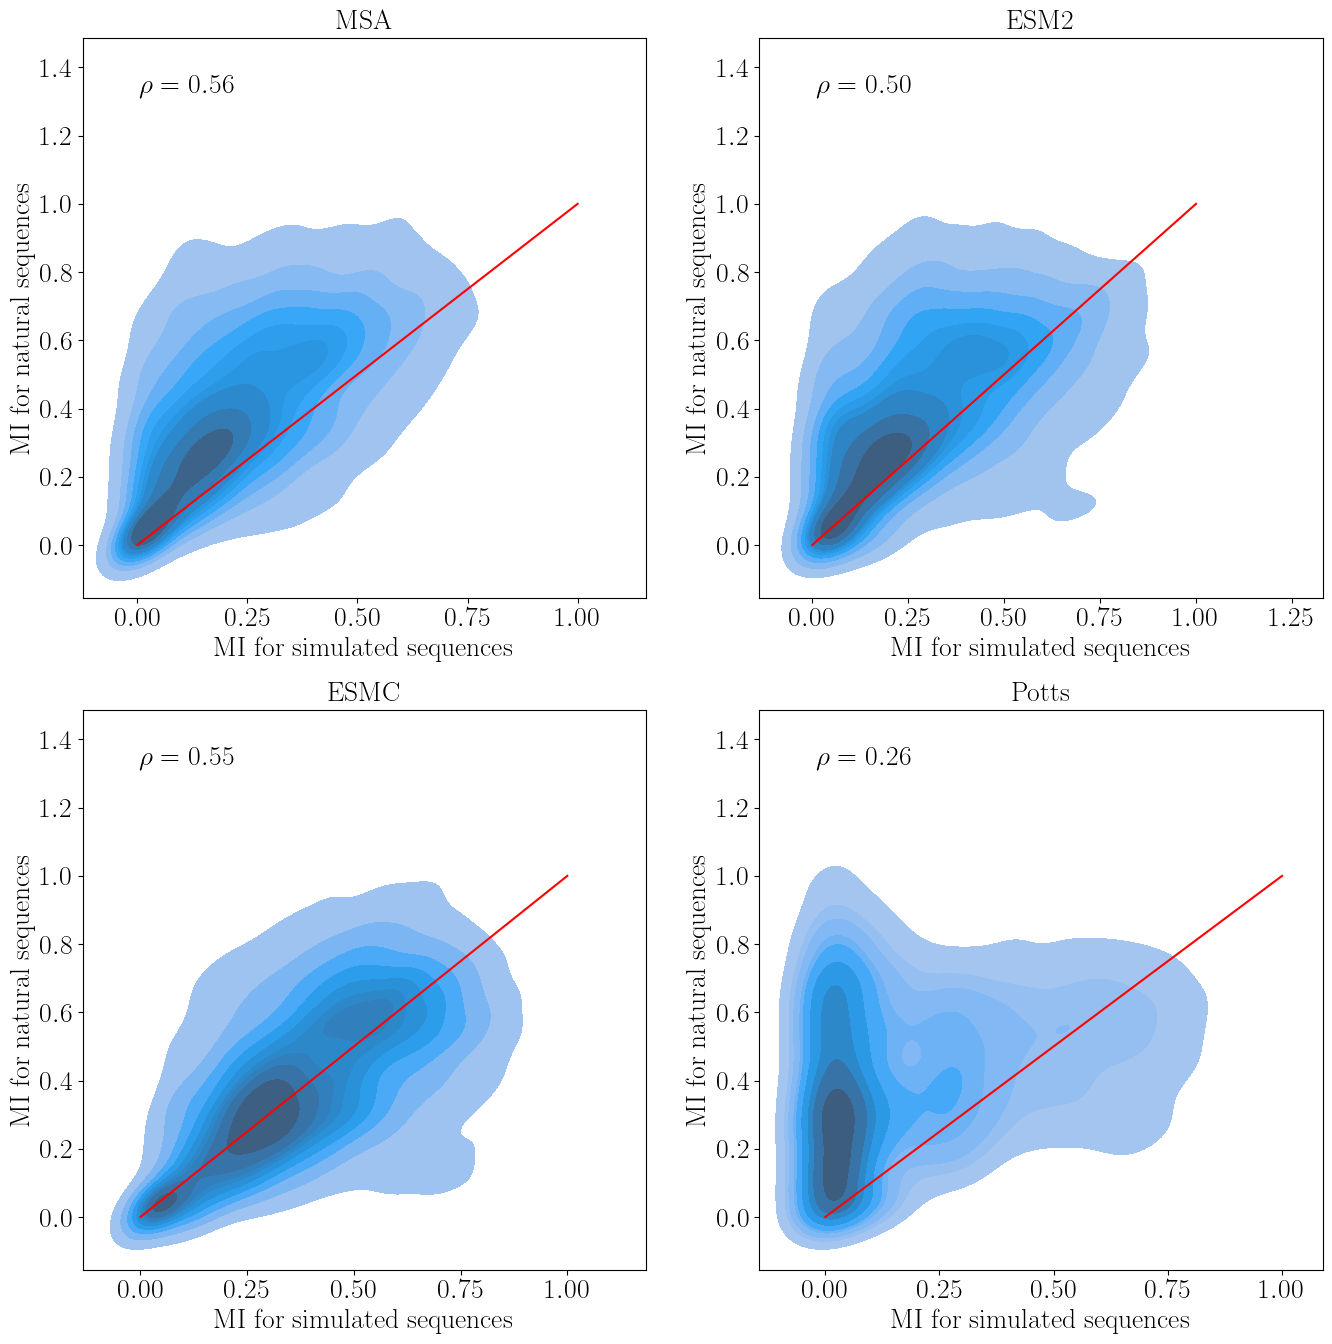

In [68]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from math import floor,ceil

rcParams["font.family"] = "Arial"

plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=16)

ncols = 2
nrows = max(2,int(ceil((len(tool_types) - 1)/3)))

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (8 *ncols ,8 * nrows))

for k in range(len(model_order)):

    if model_order[k].startswith("Nat"):
        continue

    i = floor(k/ncols)
    j = k % ncols
    
    main_dataframe_tool_sim = mi_dataframe.loc[(mi_dataframe["tool"] == model_order[k]) , :]
    # axes[i][j].scatter(main_dataframe_tool_sim["mi_sim"], main_dataframe_tool_sim["mi_nat"])
    axes[i][j].plot([0,1],[0,1], 'r-')
    axes[i][j].set_title(model_order[k], fontsize = 20)
    axes[i][j].set_xlabel("MI for simulated sequences", fontsize = 20)
    axes[i][j].set_ylabel("MI for natural sequences", fontsize = 20)
    pearson_corr = pearsonr(main_dataframe_tool_sim["mi_sim"], main_dataframe_tool_sim["mi_nat"])
    axes[i][j].annotate(r'$\rho = {:.2f}$'.format(pearson_corr.statistic),xy = (0.1,0.9), xycoords = "axes fraction", fontsize = 20)
    axes[i][j].tick_params(axis ="both", labelsize = 20)

    # values = np.vstack([main_dataframe_tool_sim["mi_sim"], main_dataframe_tool_sim["mi_nat"]])
    # kernel = stats.gaussian_kde(values)(values)
    # sns.scatterplot(
    #     data=tips,
    #     x="mi_sim",
    #     y="mi_nat",
    #     c=kernel,
    #     cmap="viridis",
    #     ax=axes[i][j],
    # )
    sns.kdeplot(data = main_dataframe_tool_sim, x="mi_sim",y="mi_nat",fill=True, ax=axes[i][j])

plt.savefig(f"MI_scatterplots_sim_{sim_ind}_{protein_families[0]}.png")

## Hamming Distance Between Tree Leaves Comparison  (Simulated vs Natural)

## Hamming Distance Distributions

In [40]:
hd_dist_dataframe = pd.DataFrame(columns=["tool","sim_ind","ham_dist"])

for j,folder in enumerate(scores_folders):
        
    for i,file in enumerate(os.listdir(folder)):

        if not tool_types[j].startswith("nat"):
            file_sim_ind = file.split('.')[0]
            file_sim_ind = int(file_sim_ind.split('-')[1])
        else:
            file_sim_ind = 1

        file_path = os.path.join(folder,file)
        dist_dataframe = pd.DataFrame()
        
        df = pd.read_csv(file_path, delimiter="\t") 
        num_seq_array = np.array([list(seq) for seq in df["sequence"]], dtype=np.bytes_).view(np.uint8)
        
        distance_matrix = cdist(num_seq_array,num_seq_array, "hamming")
        pairwise_distances = np.triu(distance_matrix).flatten()
        mask = pairwise_distances != 0
        pairwise_distances = pairwise_distances[mask]

        dist_dataframe["ham_dist"] = list(pairwise_distances)
        dist_dataframe["tool"] = tool_types[j]
        dist_dataframe["sim_ind"] = file_sim_ind

        main_dataframe = pd.concat((main_dataframe, dist_dataframe))

In [18]:
sim_number = 1

hd_dist_dataframe.loc[hd_dist_dataframe["tool"] == "nat","sim_ind"] = sim_number
hd_dist_dataframe_one_sim = main_dataframe.loc[main_dataframe["sim_ind"] == sim_number, :]

fig = px.violin(main_dataframe_one_sim, y="ham_dist", x="tool",color = "sim_ind", box = True, points = False)
fig.show()

## Contact Prediction Analysis

In [24]:
from typing import List, Tuple, Optional, Dict, NamedTuple, Union, Callable
import itertools
import os
import string
from pathlib import Path

import numpy as np
import torch
from scipy.spatial.distance import squareform, pdist, cdist
import matplotlib.pyplot as plt
import matplotlib as mpl
from Bio import SeqIO
import biotite.structure as bs
from biotite.structure.io.pdbx import PDBxFile, get_structure
from biotite.database import rcsb
from tqdm import tqdm
import pandas as pd

import esm

torch.set_grad_enabled(False)

def plot_contacts_and_predictions(
    predictions: Union[torch.Tensor, np.ndarray],
    contacts: Union[torch.Tensor, np.ndarray],
    ax: Optional[mpl.axes.Axes] = None,
    # artists: Optional[ContactAndPredictionArtists] = None,
    cmap: str = "Blues",
    ms: float = 1,
    title: Union[bool, str, Callable[[float], str]] = True,
    animated: bool = False,
) -> None:

    if isinstance(predictions, torch.Tensor):
        predictions = predictions.detach().cpu().numpy()
    if isinstance(contacts, torch.Tensor):
        contacts = contacts.detach().cpu().numpy()
    if ax is None:
        ax = plt.gca()

    seqlen = contacts.shape[0]
    relative_distance = np.add.outer(-np.arange(seqlen), np.arange(seqlen))
    bottom_mask = relative_distance < 0
    masked_image = np.ma.masked_where(bottom_mask, predictions)
    invalid_mask = np.abs(np.add.outer(np.arange(seqlen), -np.arange(seqlen))) < 6
    predictions = predictions.copy()
    predictions[invalid_mask] = float("-inf")

    topl_val = np.sort(predictions.reshape(-1))[-seqlen]
    pred_contacts = predictions >= topl_val
    true_positives = contacts & pred_contacts & ~bottom_mask
    false_positives = ~contacts & pred_contacts & ~bottom_mask
    other_contacts = contacts & ~pred_contacts & ~bottom_mask

    if isinstance(title, str):
        title_text: Optional[str] = title
    elif title:
        long_range_pl = compute_precisions(predictions, contacts, minsep=24)[
            "P@L"
        ].item()
        if callable(title):
            title_text = title(long_range_pl)
        else:
            title_text = f"Long Range P@L: {100 * long_range_pl:0.1f}"
    else:
        title_text = None

    img = ax.imshow(masked_image, cmap=cmap, animated=animated)
    oc = ax.plot(*np.where(other_contacts), "o", c="grey", ms=ms)[0]
    fn = ax.plot(*np.where(false_positives), "o", c="r", ms=ms)[0]
    tp = ax.plot(*np.where(true_positives), "o", c="b", ms=ms)[0]
    ti = ax.set_title(title_text) if title_text is not None else None
    # artists = ContactAndPredictionArtists(img, oc, fn, tp, ti)

    ax.axis("square")
    ax.set_xlim([0, seqlen])
    ax.set_ylim([0, seqlen])

In [14]:
def extend(a, b, c, L, A, D):
    """
    input:  3 coords (a,b,c), (L)ength, (A)ngle, and (D)ihedral
    output: 4th coord
    """

    def normalize(x):
        return x / np.linalg.norm(x, ord=2, axis=-1, keepdims=True)

    bc = normalize(b - c)
    n = normalize(np.cross(b - a, bc))
    m = [bc, np.cross(n, bc), n]
    d = [L * np.cos(A), L * np.sin(A) * np.cos(D), -L * np.sin(A) * np.sin(D)]
    return c + sum([m * d for m, d in zip(m, d)])


def contacts_from_pdb(
    structure: bs.AtomArray,
    distance_threshold: float = 8.0,
    chain: Optional[str] = None,
) -> np.ndarray:
    
    mask = ~structure.hetero
    
    if chain is not None:
        mask &= structure.chain_id == chain
    
    N = structure.coord[mask & (structure.atom_name == "N")]
    CA = structure.coord[mask & (structure.atom_name == "CA")]
    C = structure.coord[mask & (structure.atom_name == "C")]

    Cbeta = extend(C, N, CA, 1.522, 1.927, -2.143)
    dist = squareform(pdist(Cbeta))
    
    contacts = dist < distance_threshold
    contacts = contacts.astype(np.int64)
    contacts[np.isnan(dist)] = -1
    return contacts

def compute_precisions(
    predictions: torch.Tensor,
    targets: torch.Tensor,
    src_lengths: Optional[torch.Tensor] = None,
    minsep: int = 6,
    maxsep: Optional[int] = None,
    override_length: Optional[int] = None,  # for casp
):
    if isinstance(predictions, np.ndarray):
        predictions = torch.from_numpy(predictions)
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    if predictions.dim() == 2:
        predictions = predictions.unsqueeze(0)
    if targets.dim() == 2:
        targets = targets.unsqueeze(0)
    override_length = (targets[0, 0] >= 0).sum()

    # Check sizes
    if predictions.size() != targets.size():
        raise ValueError(
            f"Size mismatch. Received predictions of size {predictions.size()}, "
            f"targets of size {targets.size()}"
        )
    device = predictions.device

    batch_size, seqlen, _ = predictions.size()
    seqlen_range = torch.arange(seqlen, device=device)

    sep = seqlen_range.unsqueeze(0) - seqlen_range.unsqueeze(1)
    sep = sep.unsqueeze(0)
    valid_mask = sep >= minsep
    valid_mask = valid_mask & (targets >= 0)  # negative targets are invalid

    if maxsep is not None:
        valid_mask &= sep < maxsep

    if src_lengths is not None:
        valid = seqlen_range.unsqueeze(0) < src_lengths.unsqueeze(1)
        valid_mask &= valid.unsqueeze(1) & valid.unsqueeze(2)
    else:
        src_lengths = torch.full([batch_size], seqlen, device=device, dtype=torch.long)

    predictions = predictions.masked_fill(~valid_mask, float("-inf"))

    x_ind, y_ind = np.triu_indices(seqlen, minsep)
    predictions_upper = predictions[:, x_ind, y_ind]
    targets_upper = targets[:, x_ind, y_ind]

    topk = seqlen if override_length is None else max(seqlen, override_length)
    indices = predictions_upper.argsort(dim=-1, descending=True)[:, :topk]
    topk_targets = targets_upper[torch.arange(batch_size).unsqueeze(1), indices]
    if topk_targets.size(1) < topk:
        topk_targets = F.pad(topk_targets, [0, topk - topk_targets.size(1)])

    cumulative_dist = topk_targets.type_as(predictions).cumsum(-1)

    gather_lengths = src_lengths.unsqueeze(1)
    if override_length is not None:
        gather_lengths = override_length * torch.ones_like(
            gather_lengths, device=device
        )

    gather_indices = (
        torch.arange(0.1, 1.1, 0.1, device=device).unsqueeze(0) * gather_lengths
    ).type(torch.long) - 1

    binned_cumulative_dist = cumulative_dist.gather(1, gather_indices)
    binned_precisions = binned_cumulative_dist / (gather_indices + 1).type_as(
        binned_cumulative_dist
    )

    pl5 = binned_precisions[:, 1]
    pl2 = binned_precisions[:, 4]
    pl = binned_precisions[:, 9]
    auc = binned_precisions.mean(-1)

    return {"AUC": auc, "P@L": pl, "P@L2": pl2, "P@L5": pl5}


def evaluate_prediction(
    predictions: torch.Tensor,
    targets: torch.Tensor,
) -> Dict[str, float]:
    if isinstance(targets, np.ndarray):
        targets = torch.from_numpy(targets)
    contact_ranges = [
        ("local", 3, 6),
        ("short", 6, 12),
        ("medium", 12, 24),
        ("long", 24, None),
    ]
    metrics = {}
    targets = targets.to(predictions.device)
    for name, minsep, maxsep in contact_ranges:
        rangemetrics = compute_precisions(
            predictions,
            targets,
            minsep=minsep,
            maxsep=maxsep,
        )
        for key, val in rangemetrics.items():
            metrics[f"{name}_{key}"] = val.item()
    return metrics

In [15]:
def extract_domain_indices(seq):

    chars = list(seq)
    j = 0
    domain_ind_list = []
    for i in range(len(chars)):
        if chars[i].lower() == chars[i] and chars[i] != "-":
            j += 1
        else:
            domain_ind_list.append(j)
            j += 1

    return domain_ind_list
            

In [ ]:
import esm
import torch
import matplotlib.pyplot as plt
from math import floor, ceil

sim_ind = 1
pdb_id = "4D81"
pfam_fam = "PF00004"

pfam_fam_a2m_file = f"./data/protein-families-msa-seed/{pfam_fam}_pdb.a2m"
pdb_seq = [(record.description, str(record.seq)) for record in SeqIO.parse(pfam_fam_a2m_file, "fasta")]
pdb_seq = pdb_seq[0][1]

domain_indices = extract_domain_indices(pdb_seq)

structure = get_structure(PDBxFile.read(rcsb.fetch(pdb_id, "cif")))[0]
contacts = contacts_from_pdb(structure, chain="A") 

contacts = contacts[domain_indices, :]
contacts = contacts[:, domain_indices]

hmmer_score_cutoff_percentile = 0.5

device = "cuda" if torch.cuda.is_available() else "cpu"

msa_transformer, msa_transformer_alphabet = esm.pretrained.esm_msa1b_t12_100M_UR50S()
msa_transformer = msa_transformer.eval().to(device)
msa_transformer_batch_converter = msa_transformer_alphabet.get_batch_converter()

msa_transformer_results = []

for mode in ["full"]:
    
    fig, axes = plt.subplots(nrows = int(ceil(len(msa_a2m_folders)/3)), ncols = 3, figsize = (30,10 * int(ceil(len(msa_a2m_folders)/3))))

    for j,folder in enumerate(msa_a2m_folders):
    
        r = floor(j/3)
        c = j % 3
            
        for i,file in enumerate(os.listdir(folder)):
    
            torch.cuda.empty_cache()
    
            if not tool_types[j].startswith("nat"):
                file_sim_ind = file.split('.')[0]
                file_sim_ind = int(file_sim_ind.split('-')[1])
            else:
                file_sim_ind = sim_ind
    
            if file_sim_ind != sim_ind:
                continue
    
            a2m_msa_path = os.path.join(folder,file)
            
            seqs = [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(a2m_msa_path, "fasta")]
    
            _, _, batch_tokens = msa_transformer_batch_converter([seqs])
            batch_tokens = batch_tokens.to(next(msa_transformer.parameters()).device)
            msa_transformer_predictions = msa_transformer.predict_contacts(batch_tokens)[0].cpu()
    
            metrics = {"id": "PF00004", "tool": tool_types[j], "mode":mode}
            metrics.update(evaluate_prediction(msa_transformer_predictions, contacts))
            msa_transformer_results.append(metrics)
            
            del batch_tokens
            torch.cuda.empty_cache()
        
            # fig, axes = plt.subplots(figsize=(18, 6), ncols=)
            prediction = msa_transformer_predictions
            target = contacts
            plot_contacts_and_predictions(
                prediction, target, ax=axes[r][c], title = f"{mode}-{tool_types[j]}"
            )
    
    plt.show()

msa_transformer_results = pd.DataFrame(msa_transformer_results)        

## Hamming Distance Matrices (Arranged According to Tree Structure)

In [70]:
def reorder_seqs(tree_root, all_nat_seqs_dict):

    output = []
    
    def reorder_seqs_recur(tree_root, all_nat_seqs_dict):
    
        b = tree_root.clades
        
        if len(b)>0:
            for clade in b:
               reorder_seqs_recur(clade, all_nat_seqs_dict) 
        else:
            counter = len(output)
            output.append((tree_root.name,all_nat_seqs_dict[tree_root.name]))

    reorder_seqs_recur(tree_root, all_nat_seqs_dict)

    return output

In [73]:
model_order

['MSA', 'ESM2', 'ESMC', 'Potts', 'Natural', 'Natural']

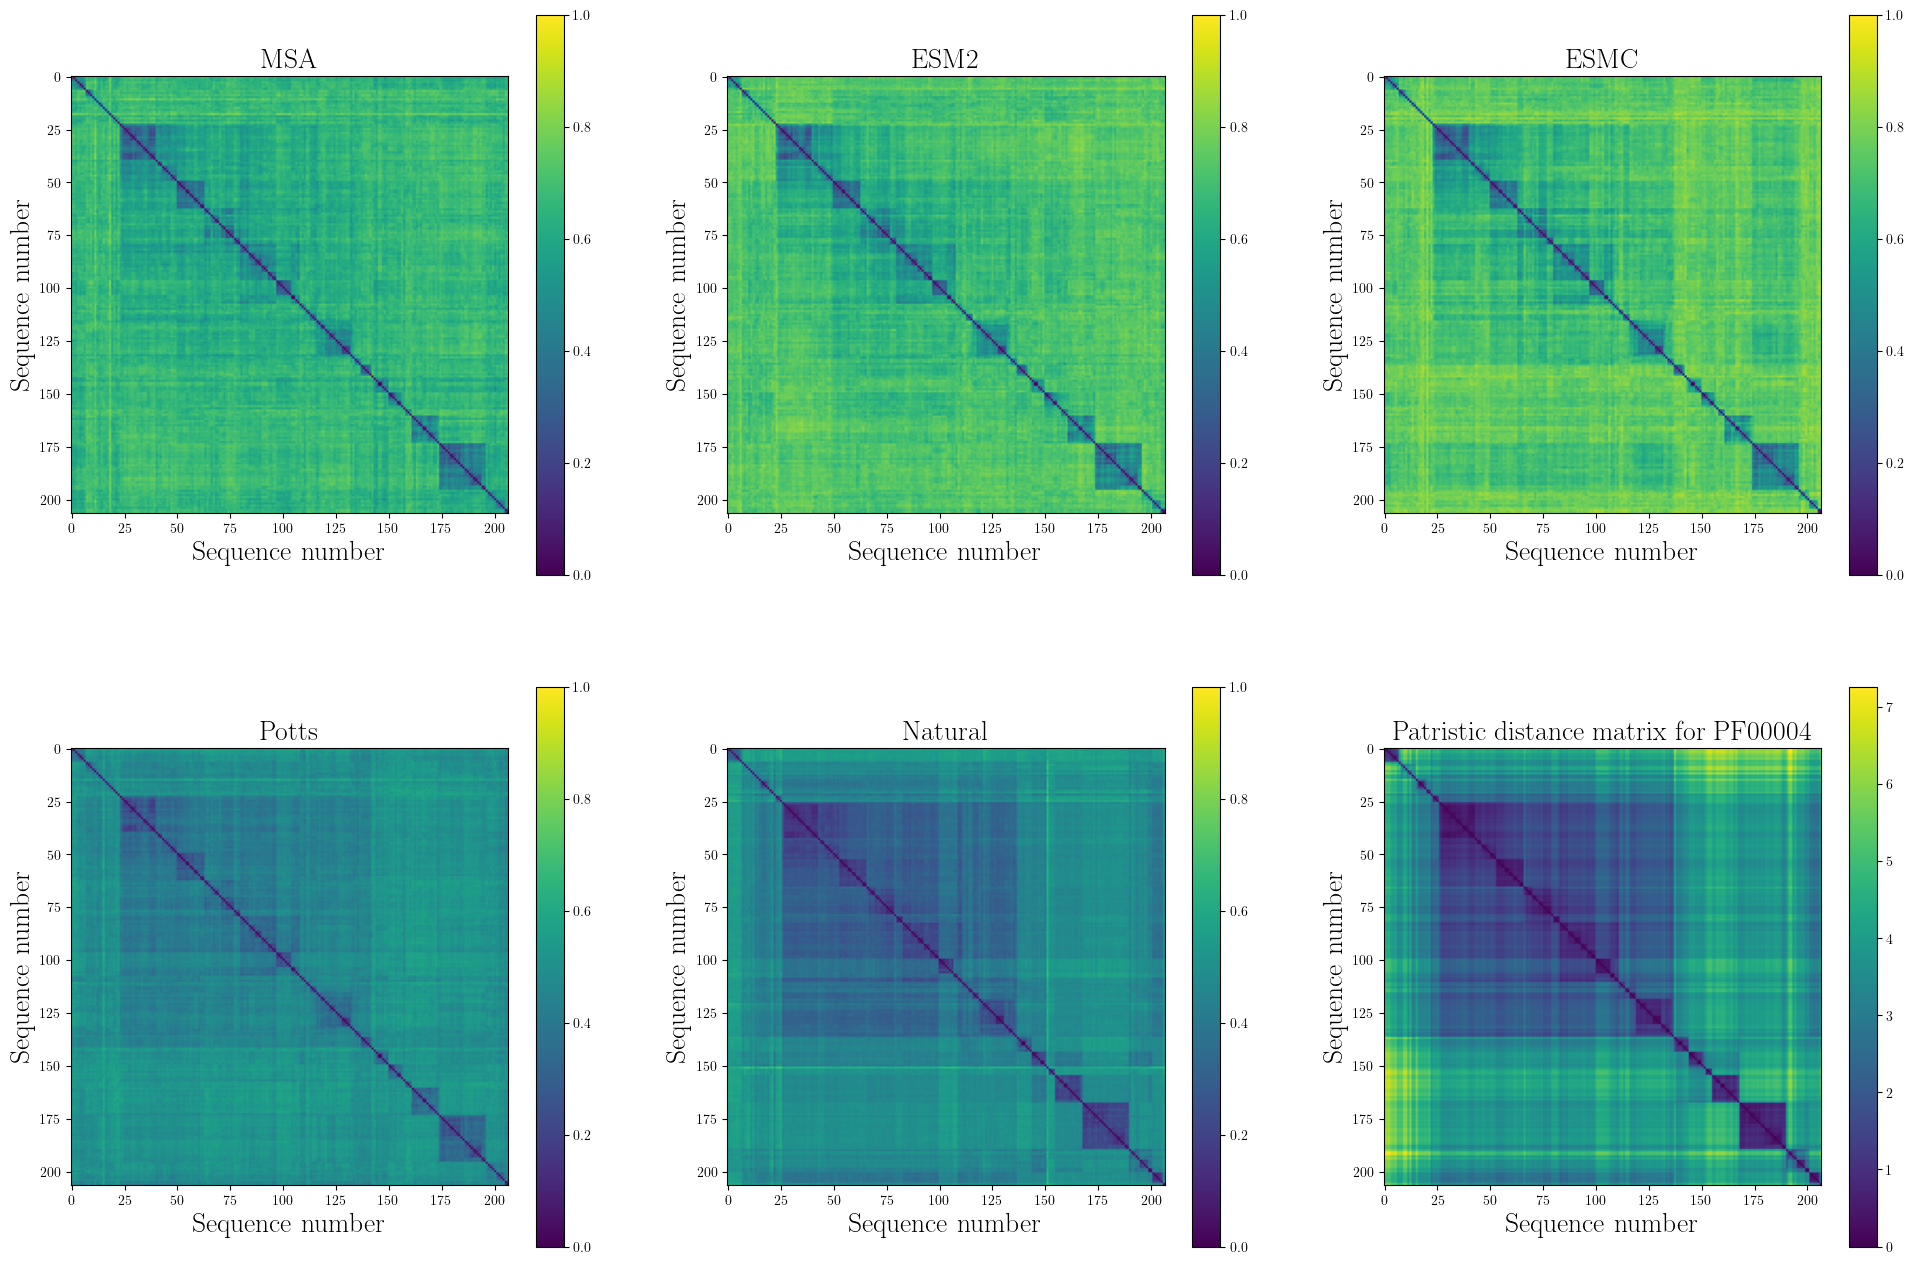

In [78]:
from math import floor,ceil
import matplotlib.pyplot as plt

nat_msa_path = f"./data/protein-families-msa-seed/{family}_seed.fasta"

ncols = 3
nrows = int(ceil((len(tool_types))/ncols))

plt.rc('axes', titlesize=15)
plt.rc('axes', labelsize=16)

fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = (8 * ncols, 8 * nrows))
sim_ind = 1

for j,folder in enumerate(msas_folders):

    r = floor(j/ncols)
    c = j % ncols
        
    if tool_types[j].startswith("nat"):
        continue
        
    for i,file in enumerate(os.listdir(folder)):

        if not tool_types[j].startswith("nat"):
            file_sim_ind = file.split('.')[0]
            file_sim_ind = int(file_sim_ind.split('-')[1])
        else:
            file_sim_ind = sim_ind

        if file_sim_ind != sim_ind:
            continue

        file_path = os.path.join(folder,file)
        dist_dataframe = pd.DataFrame()

        all_seqs = [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(file_path, "fasta")]
                
        num_sim_array = np.array([list(seq[1]) for seq in all_seqs], dtype=np.bytes_).view(np.uint8)
        distance_matrix_sim = cdist(num_sim_array,num_sim_array, "hamming") 
    
        a = axes[r][c].imshow(distance_matrix_sim,cmap='viridis', vmin=0, vmax=1)
        axes[r][c].set_title(model_order[j], fontsize = 20)
        axes[r][c].set_xlabel("Sequence number", fontsize = 20)
        axes[r][c].set_ylabel("Sequence number", fontsize = 20)

        cbar = fig.colorbar(a, ax=axes[r][c])

all_nat_seqs = [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(nat_msa_path, "fasta")]

ordered_seqs = reorder_seqs(tree.clade, dict(all_nat_seqs))
ordered_seqs_names = [seq[0] for seq in ordered_seqs]

num_nat_array = np.array([list(seq[1]) for seq in ordered_seqs], dtype=np.bytes_).view(np.uint8)
distance_matrix_nat = cdist(num_nat_array,num_nat_array, "hamming")

a = axes[r][c].imshow(distance_matrix_nat,cmap='viridis', vmin=0, vmax=1)
axes[r][c].set_title(model_order[j], fontsize = 20)
axes[r][c].set_xlabel("Sequence number", fontsize = 20)
axes[r][c].set_ylabel("Sequence number", fontsize = 20)

cbar = fig.colorbar(a, ax=axes[r][c])

if c == ncols - 1:
    r += 1
    c = 0
else:
    c += 1


patristic_distance_matrix = np.zeros((len(ordered_seqs_names), len(ordered_seqs_names)))

for a in range(len(ordered_seqs_names)):
    for b in range(a + 1, len(ordered_seqs_names)):
        patristic_distance_matrix[a][b] = tree.distance(ordered_seqs_names[a],ordered_seqs_names[b])
        patristic_distance_matrix[b][a] = patristic_distance_matrix[a][b]


a = axes[r][c].imshow(patristic_distance_matrix,cmap='viridis')
axes[r][c].set_title(f"Patristic distance matrix for {family}", fontsize = 20)
axes[r][c].set_xlabel("Sequence number", fontsize = 20)
axes[r][c].set_ylabel("Sequence number", fontsize = 20)

cbar = fig.colorbar(a, ax=axes[r][c])

plt.savefig(f"hamming_distance_matrices_sim_{sim_ind}_{protein_families[0]}")

plt.show()

## Analyzing Clade Differences?

In [86]:
def clade_assigner(clade_root, all_nat_seqs_dict):

    output = []
    clade_id_counter = 0
    clade_id_list = [0]
    dummy_clade_array = []
    
    def clade_assigner_recur(tree_root, all_nat_seqs_dict, clade_id_list):
    
        b = tree_root.clades

        dummy_clade_array.append(0)
        
        if len(b)>0:
             
            for clade in b:               
     
                clade_assigner_recur(clade, all_nat_seqs_dict, clade_id_list + [len(dummy_clade_array)]) 
                
        else:
            counter = len(output)
            output.append({"corr_nat_seq_name":tree_root.name, 
                           "corr_nat_seq":all_nat_seqs_dict[tree_root.name], "clade_ids":clade_id_list})

    clade_assigner_recur(clade_root, all_nat_seqs_dict, clade_id_list)

    return pd.DataFrame(output)

### Hamming Distances separated by clades

In [88]:
main_dataframe = pd.DataFrame(columns=["tool","sim_ind","clade_id","ham_dist_sim","ham_dist_corr_nat"])

depth = 1

nat_file_path = "./data/protein-families-msa-seed/PF00004_seed.fasta"
all_nat_seqs = [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(nat_file_path, "fasta")] 

clade_ids_df = clade_assigner(tree.clade, dict(all_nat_seqs))
clade_ids_df[f"clade_id_depth_{depth}"] = [clade_ids[depth] for clade_ids in clade_ids_df["clade_ids"]]

for j,folder in enumerate(msa_folders):
        
    for i,file in enumerate(os.listdir(folder)):

        if tool_types[j].startswith("nat") and file == "PF00004_seed.fasta":
            continue
            
        if not tool_types[j].startswith("nat"):
            file_sim_ind = file.split('.')[0]
            file_sim_ind = int(file_sim_ind.split('-')[1])
        else:
            file_sim_ind = 1
        
        file_path = os.path.join(folder,file)

        all_seqs = [(record.description, remove_insertions(str(record.seq))) for record in SeqIO.parse(file_path, "fasta")]
        
        
        df = pd.DataFrame(all_seqs, columns=["seq_name","sequence"])

        df = pd.concat((df,clade_ids_df), axis = 1).reset_index(drop = True)
    
        for clade_id in list(df[f"clade_id_depth_{depth}"].unique()):

            dist_dataframe = pd.DataFrame()

            df_clade = df.loc[df[f"clade_id_depth_{depth}"] == clade_id,:]
            
            num_sim_array = np.array([list(seq) for seq in df_clade["sequence"]], dtype=np.bytes_).view(np.uint8)
            
            distance_matrix_sim = cdist(num_sim_array,num_sim_array, "hamming")
            pairwise_distances_sim = distance_matrix_sim[np.triu_indices_from(distance_matrix_sim, k=1)]
    
            num_nat_array = np.array([list(seq) for seq in df_clade["corr_nat_seq"]], dtype=np.bytes_).view(np.uint8)
            
            distance_matrix_nat = cdist(num_nat_array,num_nat_array, "hamming")
            pairwise_distances_nat = distance_matrix_nat[np.triu_indices_from(distance_matrix_nat, k=1)]
    
            dist_dataframe["ham_dist_sim"] = list(pairwise_distances_sim)
            dist_dataframe["ham_dist_corr_nat"] = list(pairwise_distances_nat)
   
            dist_dataframe["tool"] = tool_types[j]
            dist_dataframe["sim_ind"] = i + 1
            dist_dataframe["clade_id"] = clade_id
            
            main_dataframe = pd.concat((main_dataframe, dist_dataframe)).reset_index(drop=True)

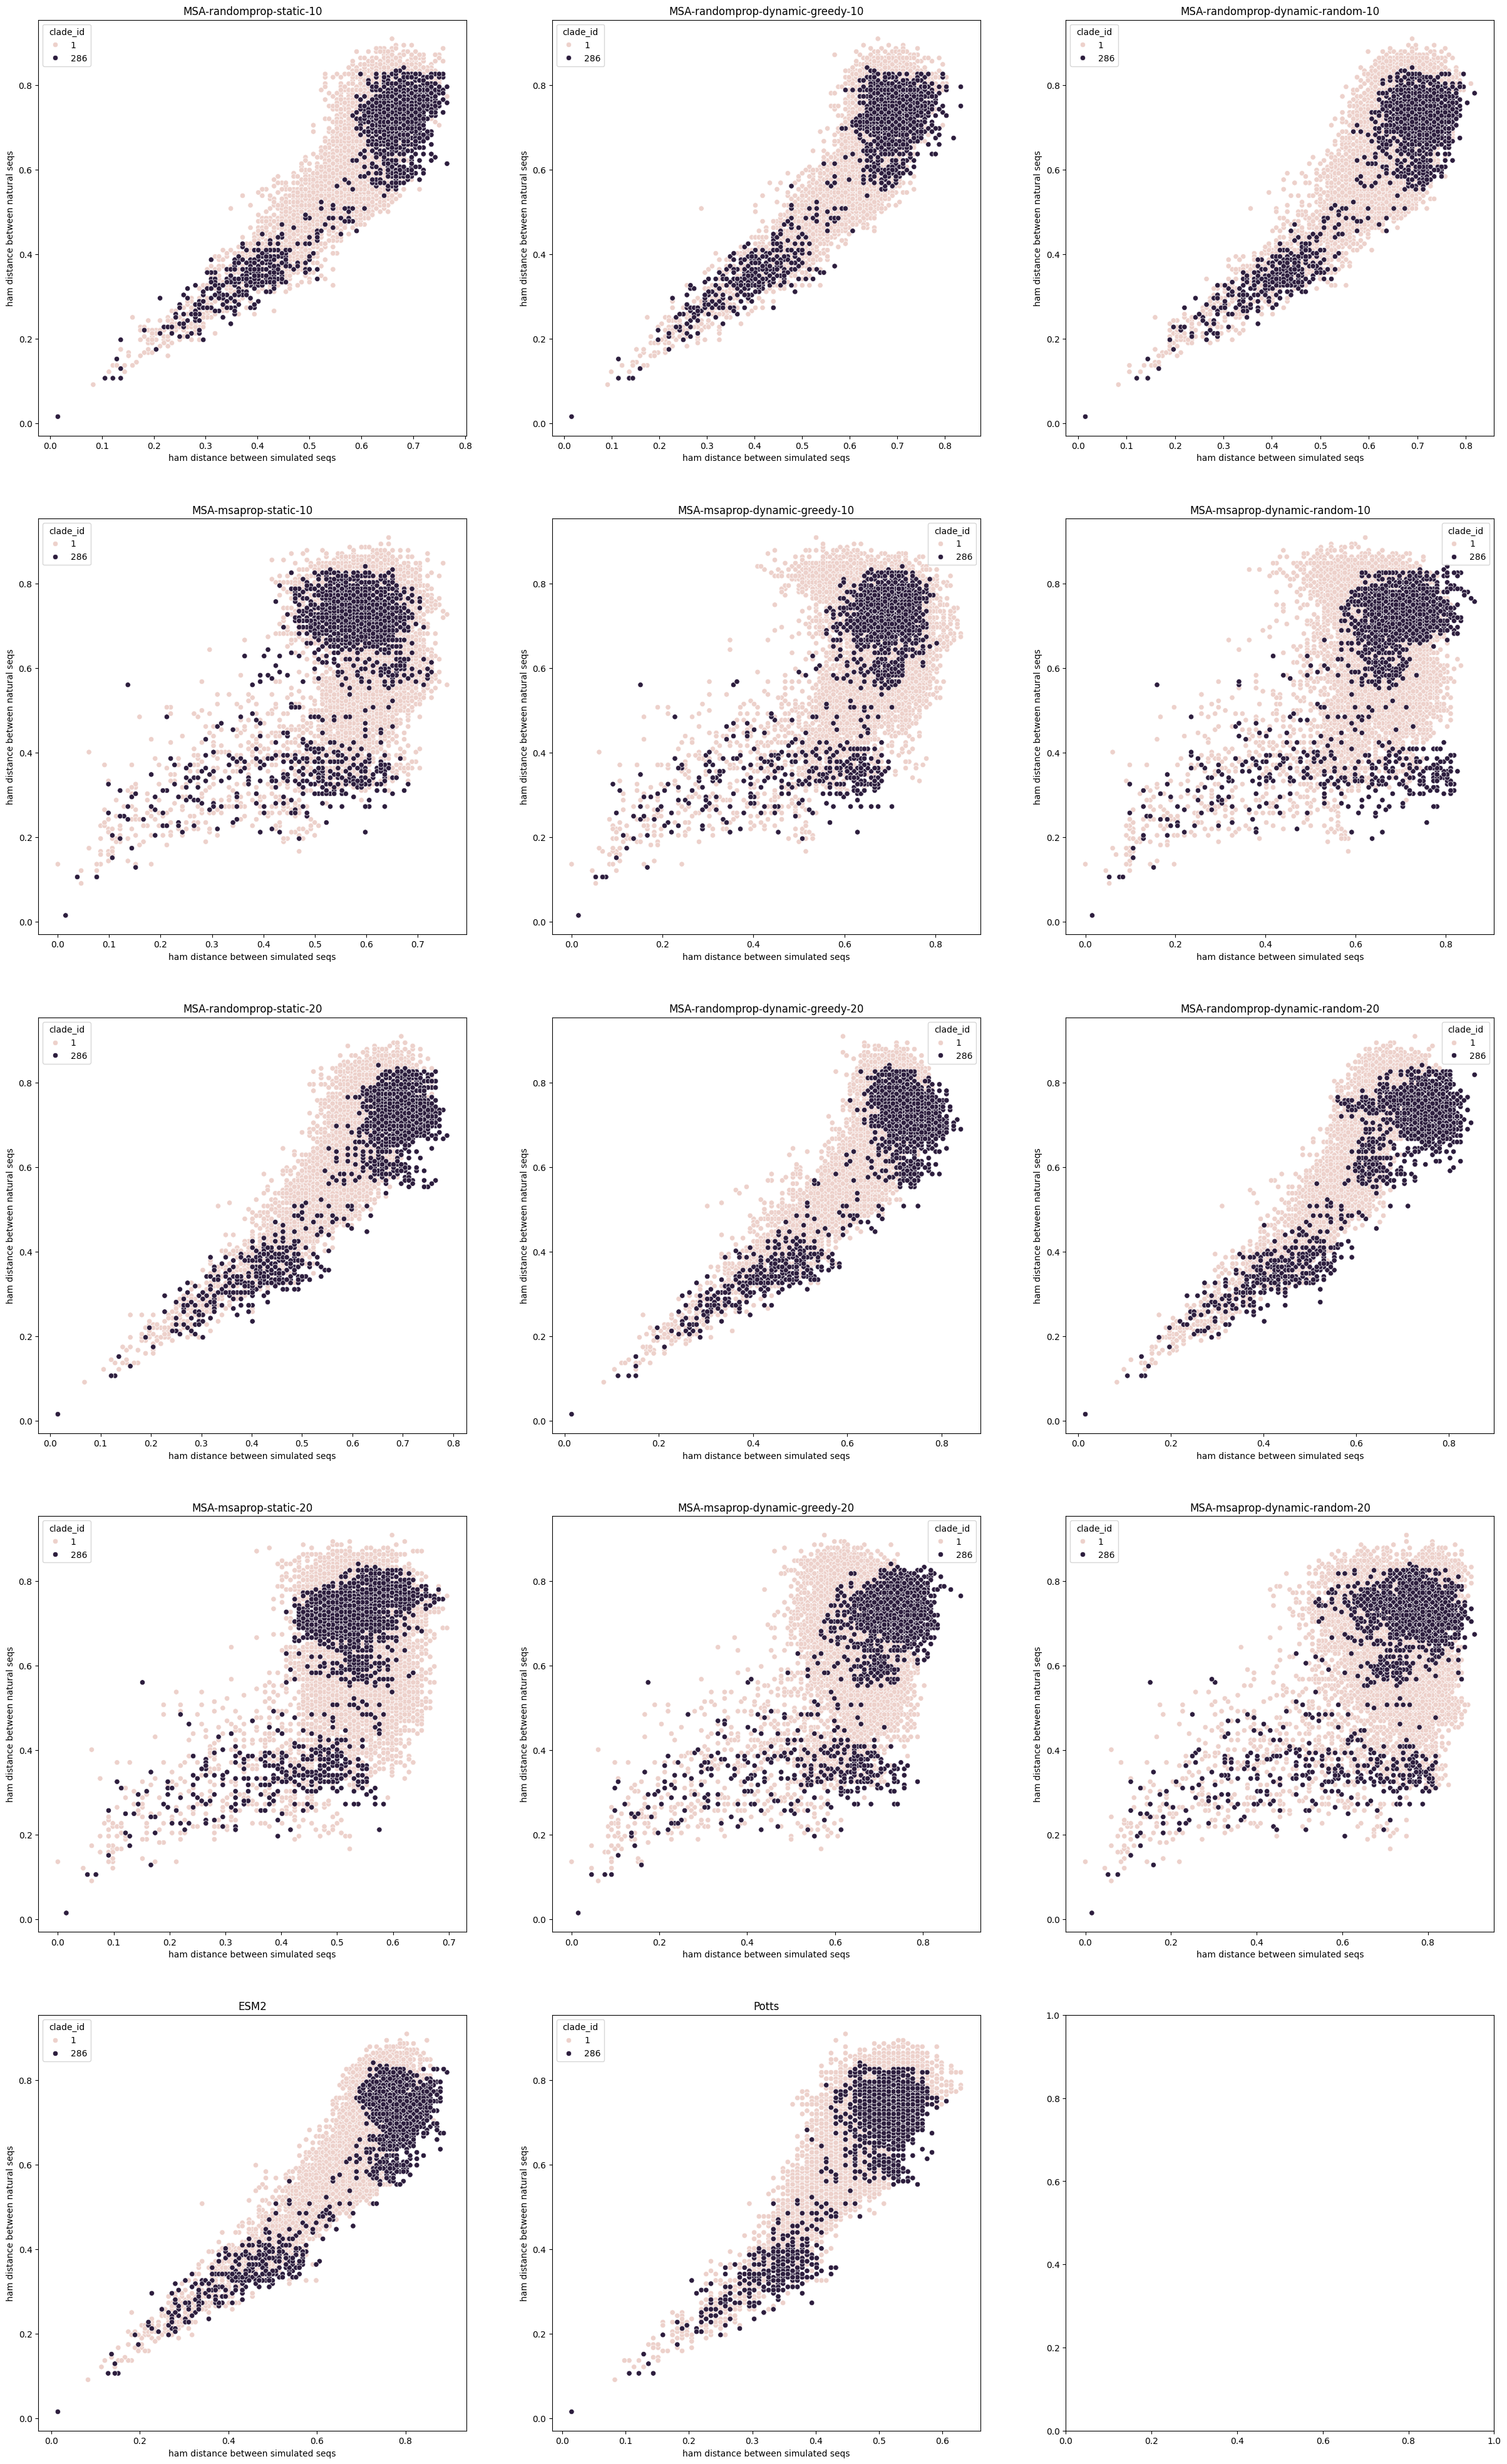

In [89]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from math import floor,ceil

fig, axes = plt.subplots(nrows = int(ceil(len(tool_types)/3)), ncols = 3, figsize = (30,10 * int(ceil(len(tool_types)/3))))
sim_ind = 1

for k in range(len(tool_types)):

    if tool_types[k] == "nat":
        continue

    i = floor(k/3)
    j = k % 3
    
    main_dataframe_tool_sim = main_dataframe.loc[(main_dataframe["tool"] == tool_types[k]) & (main_dataframe["sim_ind"] == sim_ind), :]
    
    sns.scatterplot(x = "ham_dist_sim", y = "ham_dist_corr_nat", 
                               data = main_dataframe_tool_sim, hue = "clade_id", ax=axes[i][j], alpha = 1)
    axes[i][j].set_title(tool_types[k])
    axes[i][j].set_xlabel("ham distance between simulated seqs")
    axes[i][j].set_ylabel("ham distance between natural seqs")
    # pearson_corr = pearsonr(main_dataframe_tool_sim["ham_dist_sim"], main_dataframe_tool_sim["ham_dist_corr_nat"])
    # axes[i][j].annotate(f"pearson_corr = {pearson_corr.statistic:.2f}",xy = (0.1,0.9), xycoords = "axes fraction")

plt.savefig(f"ham_distances_scatterplots_depth_{depth}.png")